# 数据读取

In [4]:
import numpy as np
import pandas as pd

# 读取原始因子库
df_raw = pd.read_excel("因子库_10.xlsx")
df_raw.set_index("date", inplace=True)

# ----------- 特征清洗流程 -----------
df = df_raw.copy()

# 1) 删除一行里超过一半缺失的记录（周末/节假日等）
df = df.dropna(thresh=df.shape[1] / 2)

# 2) 删除缺失过半的列（前端缺失过多，没用）
for col in df.columns:
    if df[col].isnull().sum() > df.shape[0] / 2:
        print(f"{col} 前端缺失过多，已删除。")
        df.drop(columns=[col], inplace=True)

# 3) 将列转为数值型，并处理异常值
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    # Z-score 绝对值 >5 判定为异常值 → NaN
    mean, std = df[col].mean(), df[col].std()
    df[col] = df[col].apply(lambda x: np.nan if abs((x - mean) / std) > 5 else x)
    # 线性插值填补缺失
    df[col] = df[col].interpolate(method="linear", axis=0)

# 4) 其余缺失补 0
df.fillna(0, inplace=True)

# ----------- 构造标签列 value_sort -----------
# 用“二级5yYTM”的下一期涨跌作为标签
# 基于差分构造标签：下期 - 当前期 > 0 记为 1，否则 0
df["value_sort"] = (df["二级5yYTM"].shift(-1) - df["二级5yYTM"]).apply(lambda x: 0 if x > 0 else 1)

# 删除最后一行（因为 shift(-1) 导致最后一行没有标签）
df_clean = df.iloc[:-1]


print(df_clean.info())
print(df_clean.head())

TL当季价格 前端缺失过多，已删除。
TL下季价格 前端缺失过多，已删除。
TL成交量 前端缺失过多，已删除。
TL持仓量 前端缺失过多，已删除。
TL跨期价差 前端缺失过多，已删除。
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1658 entries, 2019-01-08 to 2025-08-27
Columns: 149 entries, 国债1yYTM to value_sort
dtypes: float64(148), int64(1)
memory usage: 1.9 MB
None
            国债1yYTM  国债3yYTM  国债5yYTM  国债7yYTM  国债10yYTM  国债30yYTM  国开1yYTM  \
date                                                                          
2019-01-08   2.3528   2.7530   2.8796   3.0836    3.1211    3.6757   2.4806   
2019-01-09   2.3777   2.7604   2.8745   3.1010    3.1106    3.7007   2.4945   
2019-01-10   2.3627   2.7736   2.8954   3.1050    3.1006    3.7182   2.6011   
2019-01-11   2.4065   2.7920   2.9100   3.0939    3.1058    3.7157   2.6308   
2019-01-14   2.4260   2.7927   2.9496   3.1075    3.1297    3.7257   2.6519   

            国开3yYTM  国开5yYTM  国开7yYTM  ...  二级2yYTM_20dMA  二级3yYTM_20dMA  \
date                                   ...                                 
2019-01-

C:\Users\86198\AppData\Local\Temp\ipykernel_15144\701915629.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["value_sort"] = (df["二级5yYTM"].shift(-1) - df["二级5yYTM"]).apply(lambda x: 0 if x > 0 else 1)


In [5]:
print(df_clean['value_sort'].value_counts())
print(df_clean['value_sort'].value_counts(normalize=True))  # 占比

value_sort
1    955
0    703
Name: count, dtype: int64
value_sort
1    0.575995
0    0.424005
Name: proportion, dtype: float64


## 差分版

In [6]:
import numpy as np
import pandas as pd

df_raw = pd.read_excel('因子库_10.xlsx')
df_raw.set_index('date', inplace=True)
#df_raw = df_raw.loc[df_raw.index > '2021-08-13']#永续回测需要
df = pd.DataFrame(index=df_raw.index)
df = pd.concat([df, df_raw.iloc[:, 0:63].diff(1)], axis=1)
df = pd.concat([df, df_raw.iloc[:, 63:65].fillna(method='ffill').diff(1)], axis=1)
df = pd.concat([df, df_raw.iloc[:, 65:]], axis=1)

df = df.dropna(thresh=df.shape[1] / 2)  # 删除一行超过20各na的数据，主要涉及周末
for col in df.columns:  # 删除na过多的列，主要涉及永续收益率
    if df[col].isnull().sum() > df.shape[0] / 2:
        print(col, '前端缺失，已删除。')
        df.drop([col], axis=1, inplace=True)
# 将各列由object转换为数值,将异常值替换为缺失值，然后对缺失值进行线性插补
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
    # z-score绝对值大于5判定为异常值
    df[col] = df[col].apply(lambda x: np.nan if abs(
        (x - df[col].mean()) / df[col].std()) > 5 else x)
    df[col] = df[col].interpolate(method='linear', axis=0)  # 线性插补
# data = data.set_index('日期')
df.fillna(0, inplace=True)
df_clean = df.dropna()
print(df_clean.info())

df_clean['value_sort'] = df_clean['二级5yYTM'].shift(-1).apply(lambda x: 1 if x > 0 else 0)
df_clean = df_clean.iloc[:-1]

C:\Users\86198\AppData\Local\Temp\ipykernel_15144\2035252600.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.concat([df, df_raw.iloc[:, 63:65].fillna(method='ffill').diff(1)], axis=1)


TL当季价格 前端缺失，已删除。
TL下季价格 前端缺失，已删除。
TL成交量 前端缺失，已删除。
TL持仓量 前端缺失，已删除。
TL跨期价差 前端缺失，已删除。
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1643 entries, 2019-01-08 to 2025-08-28
Columns: 148 entries, 国债1yYTM to 永续5yYTM_20dMA
dtypes: float64(148)
memory usage: 1.9 MB
None


## 含有滞后项

In [22]:
import numpy as np
import pandas as pd


# =========================
# 配置区（按需修改）
# =========================
INPUT_XLSX = '因子库_10.xlsx'   # 输入文件名
DATE_COL = 'date'               # 日期列名
TARGET_COL = '二级5yYTM'        # 用于打标签的列（这里是差分后的 ΔYTM）
LAG_K = 2                        # 生成 1..K 阶滞后
LAG_COLS = None                  # None = 对全部数值列生成滞后；或传入列名列表
LAG_DROP_ORIGINAL = False        # 是否丢弃原始列，只保留滞后列
LAG_NA_STRATEGY = "drop"         # "drop" | "fill0"，滞后后产生的前 K 行 NaN 的处理
ROW_NA_RATIO_DROP = 0.5          # 行缺失比例阈值（> 该比例则丢行）
COL_NA_RATIO_DROP = 0.5          # 列缺失比例阈值（> 该比例则丢列）
ZSCORE_OUTLIER = 5               # |z|>阈值 视为异常置 NaN
FILLNA_ZERO_AFTER_CLEAN = True   # 清洗后是否将剩余 NaN 填 0


# =========================
# 工具函数
# =========================
def to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    """对 DataFrame 每列执行 to_numeric(errors='coerce')。"""
    return df.apply(lambda s: pd.to_numeric(s, errors='coerce'))


def add_lag_features(
    df: pd.DataFrame,
    cols: list[str] | None = None,
    K: int = 3,
    drop_original: bool = False,
    na_strategy: str = "drop"  # "drop" | "fill0"
) -> pd.DataFrame:
    """
    为 df 中的指定列添加 1..K 阶滞后特征。
    - cols=None 时对所有数值列添加
    - drop_original=True 时只保留滞后列
    - na_strategy: 生成滞后后前 K 行会出现 NaN，选择丢弃或填 0
    """
    if cols is None:
        cols = df.select_dtypes(include="number").columns.tolist()
    else:
        cols = [c for c in cols if c in df.columns]

    if len(cols) == 0:
        return df.copy()

    lagged_parts = []
    for k in range(1, K + 1):
        shifted = df[cols].shift(k)
        shifted.columns = [f"{c}_lag{k}" for c in cols]
        lagged_parts.append(shifted)

    out = pd.concat([df if not drop_original else df.drop(columns=cols)] + lagged_parts, axis=1)

    if na_strategy == "drop":
        out = out.dropna()
    elif na_strategy == "fill0":
        out = out.fillna(0)

    return out


# =========================
# 主流程
# =========================
def main():
    # 读取
    df_raw = pd.read_excel(INPUT_XLSX)
    if DATE_COL not in df_raw.columns:
        raise ValueError(f"未找到日期列 '{DATE_COL}'")
    df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors='coerce')
    df_raw = df_raw.set_index(DATE_COL).sort_index()

    # 构建输出骨架
    df = pd.DataFrame(index=df_raw.index)

    # --- 0:63 直接差分（保持原逻辑）+ 数值化以避免类型错误 ---
    part0 = to_numeric_df(df_raw.iloc[:, 0:63]).diff(1)

    # --- 63:65 先前向填充再差分（保持原逻辑） ---
    part1 = to_numeric_df(df_raw.iloc[:, 63:65]).ffill().diff(1)

    # --- 65: 之后 先前向填充再差分（唯一改动，保持你的设定） ---
    part2 = to_numeric_df(df_raw.iloc[:, 65:]).ffill().diff(1)

    # 合并
    df = pd.concat([df, part0, part1, part2], axis=1)

    # ========== 行/列缺失清理 ==========
    # 1) 丢弃缺失超过比例阈值的行（例如周末/节假日）
    df = df.dropna(thresh=int(df.shape[1] * (1 - ROW_NA_RATIO_DROP)))

    # 2) 丢弃缺失超过比例阈值的列
    cols_to_drop = []
    for col in df.columns:
        if df[col].isnull().sum() > df.shape[0] * COL_NA_RATIO_DROP:
            cols_to_drop.append(col)
    if cols_to_drop:
        print("前端缺失过多的列，已删除：", cols_to_drop)
        df = df.drop(columns=cols_to_drop)

    # ========== 二次数值化 + 异常值置 NaN + 线性插值 ==========
    #（部分列可能因上一步 drop/concat 再次出现类型问题，这里统一 to_numeric）
    for col in df.columns:
        s = pd.to_numeric(df[col], errors='coerce')
        mu, std = s.mean(), s.std()
        if pd.notna(std) and std > 0:
            # |z|>阈值 置 NaN
            z = (s - mu) / std
            s = s.mask(z.abs() > ZSCORE_OUTLIER, np.nan)
        df[col] = s.interpolate(method='linear', axis=0)

    if FILLNA_ZERO_AFTER_CLEAN:
        df = df.fillna(0)

    # 此处不再额外 df.dropna()，避免把合法 0 也冲掉
    df_clean = df.copy()

    # ========== 生成 K 阶滞后特征（在打标签之前） ==========
    if LAG_COLS is None:
        # 默认：对所有数值列生成滞后
        lag_target_cols = df_clean.select_dtypes(include="number").columns.tolist()
    else:
        lag_target_cols = [c for c in LAG_COLS if c in df_clean.columns]

    df_with_lags = add_lag_features(
        df_clean,
        cols=lag_target_cols,
        K=LAG_K,
        drop_original=LAG_DROP_ORIGINAL,
        na_strategy=LAG_NA_STRATEGY
    )

    # ========== 构造标签（下一期 Δ(TARGET_COL) 是否 > 0）==========
    if TARGET_COL not in df_with_lags.columns:
        raise ValueError(f"用于打标签的列 '{TARGET_COL}' 不在数据中，请检查列名或生成流程。")

    df_with_lags['value_sort'] = df_with_lags[TARGET_COL].shift(-1).apply(lambda x: 1 if x > 0 else 0)
    df_with_lags = df_with_lags.iloc[:-1]  # 去掉最后一行（因 shift(-1) 产生 NaN 标签）

    # 打印信息
    lag_feature_count = df_with_lags.filter(like='_lag').shape[1]
    print(f"shape: {df_with_lags.shape}, 生成滞后特征数量: {lag_feature_count}")
    print(df_with_lags.info())

    # 需要的话可保存
    # df_with_lags.to_parquet('df_with_lags.parquet')  # 更快更稳
    # 或者：
    # df_with_lags.to_csv('df_with_lags.csv', encoding='utf-8-sig')


if __name__ == "__main__":
    main()


前端缺失过多的列，已删除： ['TL当季价格', 'TL下季价格', 'TL成交量', 'TL持仓量', 'TL跨期价差']
shape: (1714, 445), 生成滞后特征数量: 296
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1714 entries, 2019-01-11 to 2025-08-27
Columns: 445 entries, 国债1yYTM to value_sort
dtypes: float64(444), int64(1)
memory usage: 5.8 MB
None


### 含有标签的滞后项

In [10]:
import numpy as np
import pandas as pd


# =========================
# 配置区（按需修改）
# =========================
INPUT_XLSX = '因子库_10.xlsx'   # 输入文件名
DATE_COL = 'date'               # 日期列名
TARGET_COL = '二级5yYTM'        # 用于打标签的列（这里是差分后的 ΔYTM）
LAG_K = 2                        # 生成 1..K 阶滞后
LAG_COLS = None                  # None = 对全部数值列生成滞后；或传入列名列表
LAG_DROP_ORIGINAL = False        # 是否丢弃原始列，只保留滞后列
LAG_NA_STRATEGY = "drop"         # "drop" | "fill0"，滞后后产生的前 K 行 NaN 的处理
ROW_NA_RATIO_DROP = 0.5          # 行缺失比例阈值（> 该比例则丢行）
COL_NA_RATIO_DROP = 0.5          # 列缺失比例阈值（> 该比例则丢列）
ZSCORE_OUTLIER = 5               # |z|>阈值 视为异常置 NaN
FILLNA_ZERO_AFTER_CLEAN = True   # 清洗后是否将剩余 NaN 填 0


# =========================
# 工具函数
# =========================
def to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    """对 DataFrame 每列执行 to_numeric(errors='coerce')。"""
    return df.apply(lambda s: pd.to_numeric(s, errors='coerce'))


def add_lag_features(
    df: pd.DataFrame,
    cols: list[str] | None = None,
    K: int = 3,
    drop_original: bool = False,
    na_strategy: str = "drop"  # "drop" | "fill0"
) -> pd.DataFrame:
    """
    为 df 中的指定列添加 1..K 阶滞后特征。
    - cols=None 时对所有数值列添加
    - drop_original=True 时只保留滞后列
    - na_strategy: 生成滞后后前 K 行会出现 NaN，选择丢弃或填 0
    """
    if cols is None:
        cols = df.select_dtypes(include="number").columns.tolist()
    else:
        cols = [c for c in cols if c in df.columns]

    if len(cols) == 0:
        return df.copy()

    lagged_parts = []
    for k in range(1, K + 1):
        shifted = df[cols].shift(k)
        shifted.columns = [f"{c}_lag{k}" for c in cols]
        lagged_parts.append(shifted)

    out = pd.concat([df if not drop_original else df.drop(columns=cols)] + lagged_parts, axis=1)

    if na_strategy == "drop":
        out = out.dropna()
    elif na_strategy == "fill0":
        out = out.fillna(0)

    return out


# =========================
# 主流程
# =========================

# 读取
df_raw = pd.read_excel(INPUT_XLSX)
if DATE_COL not in df_raw.columns:
    raise ValueError(f"未找到日期列 '{DATE_COL}'")
df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors='coerce')
df_raw = df_raw.set_index(DATE_COL).sort_index()

# 构建输出骨架
df = pd.DataFrame(index=df_raw.index)

# --- 0:63 直接差分（保持原逻辑）+ 数值化以避免类型错误 ---
part0 = to_numeric_df(df_raw.iloc[:, 0:63]).diff(1)

# --- 63:65 先前向填充再差分（保持原逻辑） ---
part1 = to_numeric_df(df_raw.iloc[:, 63:65]).ffill().diff(1)

# --- 65: 之后 先前向填充再差分（保持你的设定） ---
part2 = to_numeric_df(df_raw.iloc[:, 65:]).ffill().diff(1)

# 合并
df = pd.concat([df, part0, part1, part2], axis=1)

# ========== 重点：优先删除 TARGET_COL 为空的行 ==========
if TARGET_COL in df.columns:
    before_drop = df.shape[0]
    df = df[df[TARGET_COL].notna()]
    print(f"删除 {before_drop - df.shape[0]} 行 '{TARGET_COL}' 为空的数据")
else:
    raise ValueError(f"找不到目标列 '{TARGET_COL}'（请检查列名或差分切片）")

# ========== 行/列缺失清理 ==========
# 1) 丢弃缺失超过比例阈值的行（例如周末/节假日）
df = df.dropna(thresh=int(df.shape[1] * (1 - ROW_NA_RATIO_DROP)))

# 2) 丢弃缺失超过比例阈值的列
cols_to_drop = []
for col in df.columns:
    if df[col].isnull().sum() > df.shape[0] * COL_NA_RATIO_DROP:
        cols_to_drop.append(col)
if cols_to_drop:
    print("前端缺失过多的列，已删除：", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# ========== 二次数值化 + 异常值置 NaN + 线性插值 ==========
#（部分列可能因上一步 drop/concat 再次出现类型问题，这里统一 to_numeric）
for col in df.columns:
    s = pd.to_numeric(df[col], errors='coerce')
    mu, std = s.mean(), s.std()
    if pd.notna(std) and std > 0:
        # |z|>阈值 置 NaN
        z = (s - mu) / std
        s = s.mask(z.abs() > ZSCORE_OUTLIER, np.nan)
    # 对异常后的空值做线性插值
    df[col] = s.interpolate(method='linear', axis=0)

if FILLNA_ZERO_AFTER_CLEAN:
    df = df.fillna(0)

# 不再额外 df.dropna()，避免把合法 0 也冲掉
df_clean = df.copy()

# ========== 构造“历史涨跌方向因子” ytm_up_lag1..K（不引入未来信息） ==========
# 等价于：先构造 value_sort 再做滞后；但直接基于 TARGET_COL 的历史值生成，更清晰更安全
if TARGET_COL not in df_clean.columns:
    raise ValueError(f"用于生成涨跌方向因子的列 '{TARGET_COL}' 不在数据中，请检查处理流程。")
for k in range(1, LAG_K + 1):
    val = df_clean[TARGET_COL].shift(k)
    # 保留前k期的 NaN（由后续 LAG_NA_STRATEGY 统一处理）
    df_clean[f"ytm_up_lag{k}"] = np.where(val.isna(), np.nan, (val > 0).astype(int))

# ========== 生成 K 阶滞后特征（在打标签之前） ==========
if LAG_COLS is None:
    # 默认：对所有数值列生成滞后；但排除我们刚加的 ytm_up_lag*，避免二次滞后
    lag_target_cols = df_clean.select_dtypes(include="number").columns.tolist()
    lag_target_cols = [c for c in lag_target_cols if not c.startswith("ytm_up_lag")]
else:
    lag_target_cols = [c for c in LAG_COLS if c in df_clean.columns and not c.startswith("ytm_up_lag")]

df_with_lags = add_lag_features(
    df_clean,
    cols=lag_target_cols,
    K=LAG_K,
    drop_original=LAG_DROP_ORIGINAL,
    na_strategy=LAG_NA_STRATEGY
)

# ========== 构造标签（下一期 Δ(TARGET_COL) 是否 > 0）==========
if TARGET_COL not in df_with_lags.columns:
    raise ValueError(f"用于打标签的列 '{TARGET_COL}' 不在数据中，请检查列名或生成流程。")

df_with_lags['value_sort'] = df_with_lags[TARGET_COL].shift(-1).apply(lambda x: 1 if x > 0 else 0)
df_with_lags = df_with_lags.iloc[:-1]  # 去掉最后一行（因 shift(-1) 产生 NaN 标签）

# 最终输出
df_clean = df_with_lags.copy()

# 打印信息
lag_feature_count = df_with_lags.filter(like='_lag').shape[1]
print(f"shape: {df_with_lags.shape}, 生成滞后特征数量: {lag_feature_count}")
print(df_with_lags.info())
print(df_clean.info())

# 可保存
# df_with_lags.to_parquet('df_with_lags.parquet')  # 更快更稳
# 或者：
# df_with_lags.to_csv('df_with_lags.csv', encoding='utf-8-sig')


删除 166 行 '二级5yYTM' 为空的数据
前端缺失过多的列，已删除： ['TL当季价格', 'TL下季价格', 'TL成交量', 'TL持仓量', 'TL跨期价差']
shape: (1611, 447), 生成滞后特征数量: 298
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1611 entries, 2019-01-11 to 2025-08-27
Columns: 447 entries, 国债1yYTM to value_sort
dtypes: float64(446), int64(1)
memory usage: 5.5 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1611 entries, 2019-01-11 to 2025-08-27
Columns: 447 entries, 国债1yYTM to value_sort
dtypes: float64(446), int64(1)
memory usage: 5.5 MB
None


## 全特征差分

In [1]:
import numpy as np
import pandas as pd

df_raw = pd.read_excel('因子库_10.xlsx')
df_raw.set_index('date', inplace=True)
#df_raw = df_raw.loc[df_raw.index > '2021-08-13']#永续回测需要

df = pd.DataFrame(index=df_raw.index)

# 0:63 直接差分（保持原逻辑）
df = pd.concat([df, df_raw.iloc[:, 0:63].diff(1)], axis=1)

# 63:65 先前向填充再差分（保持原逻辑）
df = pd.concat([df, df_raw.iloc[:, 63:65].fillna(method='ffill').diff(1)], axis=1)

# 65: 之后 —— 改为先前向填充再差分（这是唯一改动）
df = pd.concat([df, df_raw.iloc[:, 65:].fillna(method='ffill').diff(1)], axis=1)

# 行/列缺失清理
df = df.dropna(thresh=df.shape[1] / 2)  # 删除一行超过一半 NaN（周末等）
for col in df.columns:  # 删除 NaN 过多的列
    if df[col].isnull().sum() > df.shape[0] / 2:
        print(col, '前端缺失，已删除。')
        df.drop([col], axis=1, inplace=True)

# 转数值 + 异常值置 NaN + 线性插补
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
    # z-score 绝对值大于 5 判定为异常
    df[col] = df[col].apply(lambda x: np.nan if abs((x - df[col].mean()) / df[col].std()) > 5 else x)
    df[col] = df[col].interpolate(method='linear', axis=0)
    
df.fillna(0, inplace=True)
df_clean = df.dropna()
print(df_clean.info())

# 标签：下一期 Δ(二级5yYTM) 是否 > 0
df_clean['value_sort'] = df_clean['二级5yYTM'].shift(-1).apply(lambda x: 1 if x > 0 else 0)
df_clean = df_clean.iloc[:-1]

C:\Users\86198\AppData\Local\Temp\ipykernel_9344\4059330280.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.concat([df, df_raw.iloc[:, 63:65].fillna(method='ffill').diff(1)], axis=1)
C:\Users\86198\AppData\Local\Temp\ipykernel_9344\4059330280.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.concat([df, df_raw.iloc[:, 65:].fillna(method='ffill').diff(1)], axis=1)


TL当季价格 前端缺失，已删除。
TL下季价格 前端缺失，已删除。
TL成交量 前端缺失，已删除。
TL持仓量 前端缺失，已删除。
TL跨期价差 前端缺失，已删除。
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1717 entries, 2019-01-09 to 2025-08-28
Columns: 148 entries, 国债1yYTM to 永续5yYTM_20dMA
dtypes: float64(148)
memory usage: 2.0 MB
None


In [8]:
print(df_clean['value_sort'].value_counts())
print(df_clean['value_sort'].value_counts(normalize=True))  # 占比

value_sort
0    1013
1     703
Name: count, dtype: int64
value_sort
0    0.590326
1    0.409674
Name: proportion, dtype: float64


In [ ]:
print(df_clean.head())

            国债1yYTM  国债3yYTM  国债5yYTM  国债7yYTM  国债10yYTM  国债30yYTM  国开1yYTM  \
date                                                                          
2019-01-09   0.0249   0.0074  -0.0051   0.0174   -0.0105    0.0250   0.0139   
2019-01-10  -0.0150   0.0132   0.0209   0.0040   -0.0100    0.0175   0.1066   
2019-01-11   0.0438   0.0184   0.0146  -0.0111    0.0052   -0.0025   0.0297   
2019-01-14   0.0195   0.0007   0.0396   0.0136    0.0239    0.0100   0.0211   
2019-01-15   0.0085  -0.0005  -0.0012   0.0144    0.0086    0.0150   0.0023   

            国开3yYTM  国开5yYTM  国开7yYTM  ...  二级2yYTM_20dMA  二级3yYTM_20dMA  \
date                                   ...                                 
2019-01-09   0.0126   0.0045   0.0138  ...            0.0            0.0   
2019-01-10   0.0087   0.0000   0.0155  ...            0.0            0.0   
2019-01-11   0.0161   0.0081   0.0063  ...            0.0            0.0   
2019-01-14   0.0175   0.0233   0.0332  ...            0.0         

# 特征工程

## 相关性

### 皮尔曼

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 与标签的相关性
corr = df_clean.corr(method="spearman")["value_sort"].sort_values(ascending=False)

print(corr.head(20))  # 前20个最相关的特征

value_sort         1.000000
国开5yYTM            0.271364
国开3yYTM            0.260847
Shibor5Y           0.250022
Repo5Y             0.243261
国债5yYTM            0.241402
国债10yYTM           0.239240
国债7yYTM            0.229914
国债30yYTM           0.228545
国开10yYTM           0.227306
国开7yYTM            0.226947
国开30yYTM           0.222246
Shibor1Y           0.209649
Repo1Y             0.202434
二级3yYTM            0.201906
二级4yYTM            0.200056
国债3yYTM            0.196997
二级5yYTM            0.191995
value_sort_lag1    0.188173
二级2yYTM            0.181139
Name: value_sort, dtype: float64


### 单变量分类

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = df_clean.drop(columns=["value_sort"])
y = df_clean["value_sort"]

mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series.head(20))

国债30yYTM           0.049931
国债5yYTM            0.048825
二级2yYTM_20dMA      0.040243
国开3yYTM            0.038041
国债10yYTM           0.037635
国开7yYTM            0.036857
国债7yYTM            0.034485
T当季价格              0.034170
value_sort_lag1    0.034079
Shibor1Y           0.033681
国开10yYTM_5dMA      0.033474
DR001_5dMA         0.032520
二级1y-永续1y          0.030042
MLF1y              0.029389
R001_5dMA          0.029381
Repo5Y             0.028866
二级3yYTM_20dMA      0.028750
国开30yYTM           0.028219
TF当季价格             0.027332
国开5yYTM            0.027299
dtype: float64


## 降维

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_clean.drop(columns=["value_sort"])
y = df_clean["value_sort"]

# 标准化
X_scaled = StandardScaler().fit_transform(X)

# PCA 保留 95% 方差
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("原始维度:", X.shape[1])
print("降维后维度:", X_pca.shape[1])
print("各主成分解释方差比:", pca.explained_variance_ratio_)

原始维度: 153
降维后维度: 41
各主成分解释方差比: [0.4073065  0.13708688 0.07532114 0.03888846 0.02885398 0.025713
 0.02159664 0.01656583 0.01467308 0.01310582 0.01188485 0.01130209
 0.01062086 0.0091354  0.00826316 0.00767272 0.00722691 0.00690114
 0.00662806 0.00653288 0.00603544 0.00565417 0.00553543 0.00518841
 0.00514494 0.00491476 0.00483587 0.00460845 0.00451809 0.0043515
 0.00396087 0.00376823 0.00352193 0.00336438 0.00304395 0.0029582
 0.00291263 0.00285803 0.00280741 0.00254637 0.00242228]


### LDA

d:\conda\envs\lau\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda\envs\lau\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda\envs\lau\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda\envs\lau\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\conda\envs\lau\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

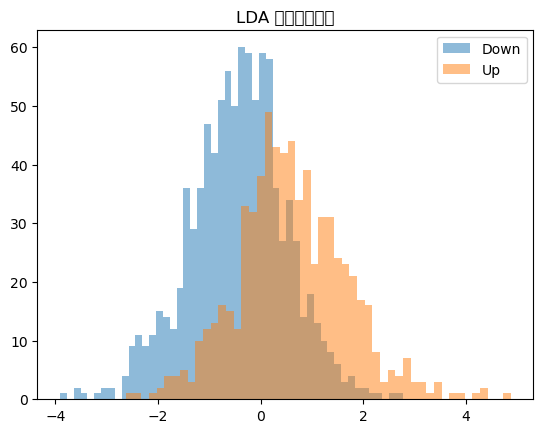

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

plt.hist(X_lda[y==0], bins=50, alpha=0.5, label="Down")
plt.hist(X_lda[y==1], bins=50, alpha=0.5, label="Up")
plt.legend()
plt.title("LDA 投影后的分布")
plt.show()

# LightGBM

## PCA+非timeseries 验证

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, log_loss
from lightgbm import LGBMClassifier, early_stopping

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ========== 数据 & 切分 ==========
# df_clean: 索引建议为日期；包含数值特征列 + 标签列 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 方式A：按日期阈值切分（需要 DatetimeIndex）
cutoff_date = None  # 例如 "2024-12-31"；若保持 None，则使用方式B
if cutoff_date is not None:
    assert isinstance(df_clean.index, pd.DatetimeIndex), "需将 df_clean.index 设为 DatetimeIndex 才能按日期切分"
    tr_mask = df_clean.index <= pd.to_datetime(cutoff_date)
    te_mask = df_clean.index >  pd.to_datetime(cutoff_date)
    X_tr_raw, y_tr = X_all[tr_mask], y_all[tr_mask]
    X_te_raw, y_te = X_all[te_mask], y_all[te_mask]
else:
    # 方式B：按比例时间切分（前80%为训练，后20%为测试）
    split_pt = int(len(df_clean) * 0.8)
    X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
    X_te_raw, y_te = X_all[split_pt:], y_all[split_pt:]

print(f"Train size: {len(y_tr)}, Test size: {len(y_te)}")

# ========== 工具函数 ==========
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

# ========== 仅在训练集上做内层CV调参 ==========
inner_cv = TimeSeriesSplit(n_splits=5)

def objective(trial: optuna.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    auc_list = []
    for tr_idx, va_idx in inner_cv.split(X_tr_raw):
        X_tr_in, y_tr_in = X_tr_raw[tr_idx], y_tr[tr_idx]
        X_va_in, y_va_in = X_tr_raw[va_idx], y_tr[va_idx]

        # 标准化 & PCA 仅基于该折训练集
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr_in)
        X_va_s = scaler.transform(X_va_in)

        pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
        X_tr_p = pca.fit_transform(X_tr_s)
        X_va_p = pca.transform(X_va_s)

        lgbm = LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            n_estimators=2000,
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
            **params
        )

        lgbm.fit(
            X_tr_p, y_tr_in,
            eval_set=[(X_va_p, y_va_in)],
            eval_metric="auc",
            callbacks=[early_stopping(100)]
        )
        y_va_prob = lgbm.predict_proba(X_va_p)[:, 1]
        auc = safe_auc(y_va_in, y_va_prob)
        auc_list.append(auc)

    mean_auc = float(np.nanmean(auc_list))
    print(f"Trial {trial.number:>3}: AUC={mean_auc:.4f}")
    return mean_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params
print("\nBest inner-CV AUC:", f"{study.best_value:.6f}")
print("Best Params:", best_params)

# ========== 用训练集训练最终模型（早停验证使用训练集末尾10%） ==========
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))

X_tr_fit_raw, y_tr_fit = X_tr_raw[:val_start], y_tr[:val_start]   # 真正用于拟合（早停前的训练部分）
X_val_fit_raw, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:] # 仅用于早停验证
assert len(y_val_fit) > 0, "训练集过小，无法切出验证集用于早停。请调大训练集或调小 val_tail_ratio。"

# 拟合阶段的标准化 & PCA（仅基于训练部分，不含验证/测试）
scaler = StandardScaler()
X_tr_fit_s = scaler.fit_transform(X_tr_fit_raw)
X_val_fit_s = scaler.transform(X_val_fit_raw)
X_te_s     = scaler.transform(X_te_raw)

pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
X_tr_fit_p = pca.fit_transform(X_tr_fit_s)
X_val_fit_p = pca.transform(X_val_fit_s)
X_te_p      = pca.transform(X_te_s)

final_model = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    n_estimators=5000,      # 允许更大上限，由早停控制
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    **best_params
)

final_model.fit(
    X_tr_fit_p, y_tr_fit,
    eval_set=[(X_val_fit_p, y_val_fit)],
    eval_metric="auc",
    callbacks=[early_stopping(200)]
)

# ========== 在测试集上预测并输出“测试集上的表现” ==========
y_te_prob = final_model.predict_proba(X_te_p)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (held-out) ====")
print(f"AUC:           {test_auc:.6f}")
print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Accuracy:      {test_acc:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")


Train size: 1309, Test size: 328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.51746	valid_0's binary_logloss: 0.693141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.662753	valid_0's binary_logloss: 0.691832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.530655	valid_0's binary_logloss: 0.693332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.708774	valid_0's binary_logloss: 0.691817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.630331	valid_0's binary_logloss: 0.692643
Trial   0: AUC=0.6100
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.51746	valid_0's binary_loglo

### 面向测试集调参 auc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
from lightgbm import LGBMClassifier, early_stopping
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（如需按日期切，改这里）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te_raw, y_te = X_all[split_pt:], y_all[split_pt:]

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

# 训练内的早停验证：训练集最后10%当val（不碰测试集）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit_raw, y_tr_fit = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit_raw, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# 预先拟合数据处理（仅基于训练部分）
scaler_base = StandardScaler().fit(X_tr_fit_raw)
pca_base = PCA(n_components=0.95, svd_solver="full", random_state=42).fit(scaler_base.transform(X_tr_fit_raw))

def transform_with_base(X):
    return pca_base.transform(scaler_base.transform(X))

X_tr_fit = transform_with_base(X_tr_fit_raw)
X_val_fit = transform_with_base(X_val_fit_raw)
X_te      = transform_with_base(X_te_raw)

# ===== 目标函数：以“测试集AUC”作为最优标准 =====
def objective(trial: optuna.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    clf = LGBMClassifier(
        objective="binary", class_weight="balanced",
        n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **params
    )
    clf.fit(
        X_tr_fit, y_tr_fit,
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200)]
    )
    # 用测试集打分：这一步就是你要求的“以测试集表现定义最优参数”
    y_te_prob = clf.predict_proba(X_te)[:, 1]
    test_auc = safe_auc(y_te, y_te_prob)
    return float(test_auc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

# ===== 用最优参数重训（同样仅用训练集），训练后立即在测试集评估 =====
final_model = LGBMClassifier(
    objective="binary", class_weight="balanced",
    n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **best_params
)
final_model.fit(
    X_tr_fit, y_tr_fit,
    eval_metric="auc",
    eval_set=[(X_val_fit, y_val_fit)],
    callbacks=[early_stopping(200)]
)

y_te_prob = final_model.predict_proba(X_te)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection) ====")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Accuracy:      {test_acc:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test AUC) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.490054	valid_0's binary_logloss: 0.693244
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.538172	valid_0's binary_logloss: 0.693167
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.504704	valid_0's binary_logloss: 0.693188
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.526882	valid_0's binary_logloss: 0.686234
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.501882	valid_0's binary_logloss: 0.693205
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.579435	valid_0's binary_logloss: 0.726782
Training until validation scores don'

### 面向测试集调参 acc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
from lightgbm import LGBMClassifier, early_stopping
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（如需按日期切，改这里）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te_raw, y_te = X_all[split_pt:], y_all[split_pt:]

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def acc_from_prob(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return accuracy_score(y_true, y_pred)

# 训练内的早停验证：训练集最后10%当val（不碰测试集）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit_raw, y_tr_fit = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit_raw, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# 预先拟合数据处理（仅基于训练部分）
scaler_base = StandardScaler().fit(X_tr_fit_raw)
pca_base = PCA(n_components=0.95, svd_solver="full", random_state=42).fit(scaler_base.transform(X_tr_fit_raw))

def transform_with_base(X):
    return pca_base.transform(scaler_base.transform(X))

X_tr_fit = transform_with_base(X_tr_fit_raw)
X_val_fit = transform_with_base(X_val_fit_raw)
X_te      = transform_with_base(X_te_raw)

# ===== 目标函数：以“测试集Accuracy@0.5”作为最优标准 =====
def objective(trial: optuna.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    clf = LGBMClassifier(
        objective="binary", class_weight="balanced",
        n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **params
    )
    clf.fit(
        X_tr_fit, y_tr_fit,
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200)]
    )
    # 用测试集Accuracy(阈值0.5)挑选最优trial
    y_te_prob = clf.predict_proba(X_te)[:, 1]
    test_acc = acc_from_prob(y_te, y_te_prob, thr=0.5)
    return float(test_acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

# ===== 用最优参数重训（同样仅用训练集），训练后立即在测试集评估 =====
final_model = LGBMClassifier(
    objective="binary", class_weight="balanced",
    n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **best_params
)
final_model.fit(
    X_tr_fit, y_tr_fit,
    eval_metric="auc",
    eval_set=[(X_val_fit, y_val_fit)],
    callbacks=[early_stopping(200)]
)

y_te_prob = final_model.predict_proba(X_te)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection: Accuracy@0.5) ====")
print(f"Accuracy:      {test_acc:.6f}")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test Accuracy) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.553201	valid_0's binary_logloss: 0.675377
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.584211	valid_0's binary_logloss: 0.68268
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.581508	valid_0's binary_logloss: 0.687505
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.576814	valid_0's binary_logloss: 0.676272
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.567568	valid_0's binary_logloss: 0.68053
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.584637	valid_0's binary_logloss: 0.692806
Training until validation scores don't

## 不含PCA

### 阈值+特征稳定性

In [11]:
# ========= 全量可运行脚本：漂移检查 + 阈值策略 + 贝叶斯超参搜索（静默日志，兼容新版LightGBM） =========
# 依赖：
#   pip install numpy pandas scipy scikit-learn lightgbm optuna

import os
os.environ["LIGHTGBM_VERBOSITY"] = "-1"  # 兜底关闭底层日志

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import optuna

# ========= 公共工具 =========

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

# ========= 1) 特征稳定性 / 漂移检查 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    """Population Stability Index (PSI) for continuous variables. 使用训练分位数分箱"""
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna(); te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)

def cat_psi(train_s: pd.Series, test_s: pd.Series):
    """PSI for categorical distributions."""
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)

def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    """连续：两样本KS；类别：卡方独立性（p越小漂移越显著）"""
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}

def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    """生成漂移报告（相对 df_ref）"""
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]

# ========= 2) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    """返回 best_thr, metrics_at_thr(dict), table(DataFrame: 各阈值指标)"""
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1
        pos_rate = pred.mean()

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

# ========= 3) 分数 PSI =========

def score_psi(ref_scores, new_scores, bins=10):
    ref = pd.Series(ref_scores)
    new = pd.Series(new_scores)
    return psi_for_series(ref, new, bins=bins)

# ========= 4) 数据准备（日期阈值 / 比例切分） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    """
    返回: X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols
    """
    assert label_col in df_clean.columns
    df = df_clean.copy().sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

# ========= 2.5) 统一评估接口（支持阈值与非阈值类指标） =========

def _compute_metrics_at_thr(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tnr = tn / max(1, (tn + fp))
    youdenJ = (recall_score(y_true, y_pred, zero_division=0) + tnr - 1.0)
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "youden":    youdenJ,
        "pos_rate":  y_pred.mean()
    }

def evaluate_with_optional_threshold(
    y_true, y_prob,
    optimize_metric="f1",     # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",        # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5,
    constraint_min_precision=None,
    constraint_min_recall=None,
    target_pos_rate=None
):
    """
    返回 (score, used_thr, aux_row)
    - 非阈值类：auc/ap/logloss 不取阈值，used_thr=None
      · auc: roc_auc_score
      · ap : average_precision_score
      · logloss: 取负号以“最大化”
    - 阈值类：accuracy/precision/recall/f1/youden
      先依据 thr_source 决定阈值，再在该阈值上计算所选 optimize_metric
    """
    y_true = np.asarray(y_true).astype(int)

    # 非阈值类指标
    if optimize_metric in {"auc", "ap", "logloss"}:
        if len(np.unique(y_true)) < 2:
            return (-np.inf if optimize_metric == "logloss" else np.nan), None, {}
        if optimize_metric == "auc":
            return float(roc_auc_score(y_true, y_prob)), None, {}
        elif optimize_metric == "ap":
            return float(average_precision_score(y_true, y_prob)), None, {}
        else:  # logloss -> 最大化 -logloss
            ll = log_loss(y_true, np.vstack([1 - y_prob, y_prob]).T, labels=[0, 1])
            return float(-ll), None, {"raw_logloss": ll}

    # 阈值类指标：先确定 thr
    if thr_source == "auto":
        # 缺省让阈值来源与指标一致（youden->youden，其它->f1）
        thr_source = "youden" if optimize_metric == "youden" else "f1"

    if   thr_source == "f1":
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")
    elif thr_source == "youden":
        thr, row, _ = choose_threshold(y_true, y_prob, method="youden")
    elif thr_source == "constraint":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="constraint",
            min_precision=constraint_min_precision, min_recall=constraint_min_recall
        )
    elif thr_source == "posrate":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="posrate", target_pos_rate=target_pos_rate
        )
    elif thr_source == "fixed":
        thr = float(fixed_thr)
        row = _compute_metrics_at_thr(y_true, y_prob, thr)
    else:
        # 回退到 F1
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")

    # 在该阈值上取所需指标
    if optimize_metric not in {"accuracy", "precision", "recall", "f1", "youden"}:
        # 防御：如果给了不认识的指标名，退回 F1
        optimize_metric = "f1"
    score = float(row[optimize_metric])
    return score, float(thr), row

# ========= 5) Optuna + LightGBM 搜索（静默） =========

def run_optuna_lgbm(
    X_tr, y_tr, X_val, y_val,
    n_trials=50,
    # 旧参数（向后兼容）：控制阈值如何选
    method_for_thr="f1",
    constraint_min_precision=None, constraint_min_recall=None, target_pos_rate=None,
    # 新增：控制“评优指标”与阈值来源
    optimize_metric="f1",      # 可选：f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",         # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5
):
    """
    若 optimize_metric ∈ {auc, ap, logloss}，不走阈值；其它指标先按 thr_source 取阈值再评估。
    注意：logloss 会以 -logloss 作为“要最大化”的目标。
    """
    # 向后兼容：若用户仍传了旧参数 method_for_thr，就用它覆盖 thr_source
    if thr_source == "auto":
        # 保持原脚本默认：在验证集上先找阈值（F1）再算F1
        thr_source = method_for_thr

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 16, 512, log=True),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
            "objective": "binary",
            "verbosity": -1,
        }

        model = LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )

        val_prob = model.predict_proba(X_val)[:, 1]
        score, used_thr, row = evaluate_with_optional_threshold(
            y_val, val_prob,
            optimize_metric=optimize_metric,
            thr_source=thr_source,
            fixed_thr=fixed_thr,
            constraint_min_precision=constraint_min_precision,
            constraint_min_recall=constraint_min_recall,
            target_pos_rate=target_pos_rate
        )

        # 记录可追踪信息
        trial.set_user_attr("metric", optimize_metric)
        trial.set_user_attr("thr_source", thr_source)
        trial.set_user_attr("thr", used_thr)
        # 常用阈值类指标都记录一下
        for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate"]:
            if k in row:
                trial.set_user_attr(k, row[k])
        if "raw_logloss" in row:
            trial.set_user_attr("raw_logloss", row["raw_logloss"])

        # Optuna 默认 maximize；logloss 已转为 -logloss
        return float(score)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study

# ========= 6) 主流程 =========

if __name__ == "__main__":
    # ======= 读取/准备数据 =======
    # 请自行提供 df_clean（含列 value_sort，索引建议为 DatetimeIndex）
    # 例：
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns
    raise_if_no_data = False  # 若你在复制后尚未加载数据，可将其设为 True 以防误运行

    if raise_if_no_data:
        raise RuntimeError("请先加载 df_clean（包含列 value_sort）。示例见注释。")

    # ======= 切分：二选一 =======
    cutoff_date = None  # 例如 "2024-12-31"
    # X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
    #     df_clean, label_col="value_sort", cutoff_date=cutoff_date,
    #     test_size_ratio=0.2, val_size_ratio=0.2
    # )

    # ---- 示例：若你希望脚本可直接跑通，这里用一个伪造数据演示（请替换为你的 df_clean） ----
    # （演示用：二分类、1000行、20特征，其中后200行为“测试集时间段”）
    

    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=None,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test） =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= 贝叶斯优化（可自由切换评优指标与阈值来源） =======
    # 你可以把 optimize_metric 改成 'auc'/'ap'/'logloss' 等；非阈值类会忽略 thr_source
    study = run_optuna_lgbm(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=100,                    # 演示缩小一点，实际可调大如 300
        # —— 评优指标 —— 
        optimize_metric="f1",           # f1 / accuracy / precision / recall / youden / auc / ap / logloss
        # —— 阈值来源（仅当评优指标是阈值类时生效）——
        thr_source="f1",                # auto / f1 / youden / constraint / posrate / fixed
        fixed_thr=0.5,                  # thr_source="fixed" 时生效
        # 若用到 constraint/posrate，可给下列约束：
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None,
        # 兼容旧参数：不影响新逻辑
        method_for_thr="precision",
    )

    print("\n==== Optuna Best (VAL by chosen metric) ====")
    print("Optimize metric:", study.best_trial.user_attrs.get("metric"))
    print("Best score:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr_source:", study.best_trial.user_attrs.get("thr_source"))
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    # 如果是阈值类指标，还会记录这些：
    for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate", "raw_logloss"]:
        if k in study.best_trial.user_attrs:
            print(f"Best VAL {k}:", study.best_trial.user_attrs[k])

    # ======= 用最优参数重新训练最终模型 =======
    best_params = study.best_trial.params
    final_model = LGBMClassifier(
        **best_params, objective="binary", random_state=42, n_jobs=-1, verbosity=-1
    )
    final_model.fit(
        X_tr_fit_raw, y_tr_fit,
        eval_set=[(X_val_fit_raw, y_val_fit)],
        eval_metric="auc",
        callbacks=[
            early_stopping(stopping_rounds=100, verbose=False),
            log_evaluation(period=0)  # 关闭 eval 输出
        ]
    )

    # ======= 在验证集上选“生产用阈值”（与 Optuna 评优逻辑保持一致，便于对齐） =======
    val_prob = final_model.predict_proba(X_val_fit_raw)[:, 1]
    # 例：使用 F1 选阈值，并在该阈值上报告 F1
    _, chosen_thr, row_any = evaluate_with_optional_threshold(
        y_val_fit, val_prob,
        optimize_metric="precision",   # 你也可以换成 accuracy/recall/precision/youden
        thr_source="precision"         # 与上面 study 中一致即可（或你想要的策略）
    )
    print(f"\n[Threshold] VAL selected via F1: t*={chosen_thr:.3f}, "
          f"P={row_any.get('precision', np.nan):.4f}, R={row_any.get('recall', np.nan):.4f}, "
          f"F1={row_any.get('f1', np.nan):.4f}, Acc={row_any.get('accuracy', np.nan):.4f}, "
          f"Youden={row_any.get('youden', np.nan):.4f}")

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = final_model.predict_proba(X_te_raw)[:, 1]
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = final_model.predict_proba(X_tr_fit_raw)[:, 1]
    val_scores = final_model.predict_proba(X_val_fit_raw)[:, 1]
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")

[I 2025-09-09 22:41:43,867] A new study created in memory with name: no-name-4d09b475-e3be-4bf6-8515-e90811dd9744



==== Top Drifted Features (TrainFit vs Test) ====
           feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
         二级1y-永续1y           False 3.4954     0.0000   0.4124       0.0000       0.0000        0.0000
    二级1y-永续1y_lag2           False 3.4680     0.0000   0.4103       0.0000       0.0000        0.0000
    二级1y-永续1y_lag1           False 3.4601     0.0000   0.4134       0.0000       0.0000        0.0000
 永续5yYTM_5dMA_lag2           False 2.8482     0.0000   0.3918       0.0000       0.0000        0.0000
 永续5yYTM_5dMA_lag1           False 2.7386     0.0000   0.3940       0.0000       0.0000        0.0000
永续1yYTM_20dMA_lag1           False 2.7195     0.0000   0.4497       0.0000       0.0000        0.0000
     永续1yYTM_20dMA           False 2.7195     0.0000   0.4487       0.0000       0.0000        0.0000
永续1yYTM_20dMA_lag2           False 2.7159     0.0000   0.4506       0.0000       0.0000        0.0000
      永续5yYTM_5dMA           Fa

[I 2025-09-09 22:41:47,091] Trial 0 finished with value: 0.568 and parameters: {'n_estimators': 1732, 'learning_rate': 0.0034810997758004804, 'num_leaves': 249, 'min_child_samples': 20, 'subsample': 0.8266742512730378, 'colsample_bytree': 0.886507798179608, 'reg_alpha': 0.019975559321955192, 'reg_lambda': 0.0572392733579684}. Best is trial 0 with value: 0.568.
[I 2025-09-09 22:41:47,618] Trial 1 finished with value: 0.5538461538461539 and parameters: {'n_estimators': 1986, 'learning_rate': 0.008812578381734515, 'num_leaves': 30, 'min_child_samples': 194, 'subsample': 0.7786259535538393, 'colsample_bytree': 0.7313008347641077, 'reg_alpha': 0.0005842965638147646, 'reg_lambda': 0.043858262268075966}. Best is trial 0 with value: 0.568.
[I 2025-09-09 22:41:48,151] Trial 2 finished with value: 0.5895522388059702 and parameters: {'n_estimators': 281, 'learning_rate': 0.0024907550995343967, 'num_leaves': 29, 'min_child_samples': 128, 'subsample': 0.5046689396232729, 'colsample_bytree': 0.95598


==== Optuna Best (VAL by chosen metric) ====
Optimize metric: f1
Best score: 0.6015037593984962
Best params: {'n_estimators': 1639, 'learning_rate': 0.0030630495991850067, 'num_leaves': 33, 'min_child_samples': 128, 'subsample': 0.7520027944498934, 'colsample_bytree': 0.8592225638147261, 'reg_alpha': 2.4825811621522984, 'reg_lambda': 0.48356841287628977}
Best VAL thr_source: f1
Best VAL thr: 0.41000000000000003
Best VAL precision: 0.4624277456647399
Best VAL recall: 0.8602150537634409
Best VAL f1: 0.6015037593984962
Best VAL pos_rate: 0.6731517509727627

[Threshold] VAL selected via F1: t*=0.410, P=0.4624, R=0.8602, F1=0.6015, Acc=nan, Youden=nan

==== Test Performance (held-out, with chosen threshold) ====
AUC:           0.581692
AveragePrecision(PR-AUC): 0.482224
LogLoss:       0.680358
Accuracy:      0.515528
Precision@t*:  0.463636
Recall@t*:     0.728571
F1@t*:         0.566667
(t* chosen on VAL: 0.410)

Score PSI (TrainFit→Val):  0.0617
Score PSI (TrainFit→Test): 0.1008


In [9]:
import pandas as pd
te_index = df_clean.index[-len(y_te):]
# ======= 导出预测结果到 Excel =======
df_pred = pd.DataFrame({
    "index": te_index,
    "y_true": 1 - y_te,
    "y_prob": y_te_prob,
    "y_pred": 1 -y_te_pred
})

out_file = "test_predictions.xlsx"
df_pred.to_excel(out_file, index=False)
print(f"\n预测结果已保存到: {out_file}")


预测结果已保存到: test_predictions.xlsx


### 面向调参

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
from lightgbm import LGBMClassifier, early_stopping
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（如需按日期切，改这里）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def acc_from_prob(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return accuracy_score(y_true, y_pred)

# 训练内的早停验证：训练集最后10%当val（不碰测试集）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# ===== 目标函数：以“测试集Accuracy@0.5”作为最优标准 =====
def objective(trial: optuna.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    clf = LGBMClassifier(
        objective="binary", class_weight="balanced",
        n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **params
    )
    clf.fit(
        X_tr_fit, y_tr_fit,
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200)]
    )
    # 用测试集Accuracy(阈值0.5)挑选最优trial
    y_te_prob = clf.predict_proba(X_te)[:, 1]
    test_acc = acc_from_prob(y_te, y_te_prob, thr=0.5)
    return float(test_acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

# ===== 用最优参数重训（同样仅用训练集），训练后立即在测试集评估 =====
final_model = LGBMClassifier(
    objective="binary", class_weight="balanced",
    n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **best_params
)
final_model.fit(
    X_tr_fit, y_tr_fit,
    eval_metric="auc",
    eval_set=[(X_val_fit, y_val_fit)],
    callbacks=[early_stopping(200)]
)

y_te_prob = final_model.predict_proba(X_te)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection: Accuracy@0.5) ====")
print(f"Accuracy:      {test_acc:.6f}")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test Accuracy) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.581508	valid_0's binary_logloss: 0.672896
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.64367	valid_0's binary_logloss: 0.693057
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.596159	valid_0's binary_logloss: 0.687076
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.612945	valid_0's binary_logloss: 0.685148
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.628307	valid_0's binary_logloss: 0.692178
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.592745	valid_0's binary_logloss: 0.688352
Training until validation scores don't im

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
from lightgbm import LGBMClassifier, early_stopping
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（如需按日期切，改这里）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def acc_from_prob(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return accuracy_score(y_true, y_pred)

# 训练内的早停验证：训练集最后10%当val（不碰测试集）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# ===== 目标函数：以“测试集Accuracy@0.5”作为最优标准 =====
def objective(trial: optuna.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    clf = LGBMClassifier(
        objective="binary", class_weight="balanced",
        n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **params
    )
    clf.fit(
        X_tr_fit, y_tr_fit,
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200)]
    )
    # 用测试集Accuracy(阈值0.5)挑选最优trial
    y_te_prob = clf.predict_proba(X_te)[:, 1]
    test_acc = acc_from_prob(y_te, y_te_prob, thr=0.5)
    return float(test_acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

# ===== 用最优参数重训（同样仅用训练集），训练后立即在测试集评估 =====
final_model = LGBMClassifier(
    objective="binary", class_weight="balanced",
    n_estimators=5000, random_state=42, n_jobs=-1, verbosity=-1, **best_params
)
final_model.fit(
    X_tr_fit, y_tr_fit,
    eval_metric="auc",
    eval_set=[(X_val_fit, y_val_fit)],
    callbacks=[early_stopping(200)]
)

y_te_prob = final_model.predict_proba(X_te)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection: Accuracy@0.5) ====")
print(f"Accuracy:      {test_acc:.6f}")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test Accuracy) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.632608	valid_0's binary_logloss: 0.691856
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.651645	valid_0's binary_logloss: 0.633858
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.634939	valid_0's binary_logloss: 0.687927
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[233]	valid_0's auc: 0.652422	valid_0's binary_logloss: 0.648065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.661487	valid_0's binary_logloss: 0.62658
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.631572	valid_0's binary_logloss: 0.692807
Training until validation scores do

# XGBoost

## 基本款

In [13]:
# ========= 全量可运行脚本：漂移检查 + 阈值策略 + 贝叶斯超参搜索
# （XGBoost 原生API版，兼容老版本；支持“可切换评优指标 + 可配置阈值来源”）=========
# 依赖：
#   pip install numpy pandas scipy scikit-learn xgboost optuna

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
import xgboost as xgb
import optuna

# ========= 公共工具 =========

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

# ========= 0) XGBoost 原生训练/预测封装（适配所有版本） =========

def _pack_xgb_params(params):
    """
    将 Optuna/外部给的 sklearn 风格参数映射为 xgb.train 可用字典。
    """
    p = dict(params) if params else {}
    # 通用默认
    p.setdefault("objective", "binary:logistic")
    p.setdefault("eval_metric", "auc")
    # 学习率名称差异
    if "learning_rate" in p:
        p["eta"] = p.pop("learning_rate")
    # n_estimators 在 train 里用 num_boost_round 传，不放进 params
    p.pop("n_estimators", None)
    # 一些 sklearn 专属键删除
    for k in ["verbosity", "n_jobs", "random_state"]:
        p.pop(k, None)
    # 返回 xgb.train 用的参数
    return p

def train_xgb_booster(
    X_tr, y_tr, X_val, y_val,
    params,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose=False
):
    """
    用 xgb.train 训练，支持早停。返回 booster 对象。
    """
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    xgb_params = _pack_xgb_params(params)

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=bool(verbose)
    )
    return booster

def predict_proba_booster(booster, X):
    """
    兼容不同 XGBoost 版本：优先使用 best_iteration / best_ntree_limit。
    返回正类概率（shape: [n_samples]）。
    """
    dtest = xgb.DMatrix(X)
    # 新版本：有 best_iteration
    best_iteration = getattr(booster, "best_iteration", None)
    if best_iteration is not None:
        # iteration_range 是新API；老版本不支持就走下面 ntree_limit
        try:
            return booster.predict(dtest, iteration_range=(0, best_iteration + 1))
        except TypeError:
            pass
    # 较老版本：best_ntree_limit
    best_ntree_limit = getattr(booster, "best_ntree_limit", None)
    if best_ntree_limit is not None:
        try:
            return booster.predict(dtest, ntree_limit=best_ntree_limit)
        except TypeError:
            pass
    # 最保守：不指定限制
    return booster.predict(dtest)

# ========= 1) 特征稳定性 / 漂移检查 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    """Population Stability Index (PSI) for continuous variables. 使用训练分位数分箱"""
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna(); te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)

def cat_psi(train_s: pd.Series, test_s: pd.Series):
    """PSI for categorical distributions."""
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)

def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    """连续：两样本KS；类别：卡方独立性（p越小漂移越显著）"""
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}

def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    """生成漂移报告（相对 df_ref）"""
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]

# ========= 2) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    """返回 best_thr, metrics_at_thr(dict), table(DataFrame: 各阈值指标)"""
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1
        pos_rate = pred.mean()

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

# ========= 3) 分数 PSI =========

def score_psi(ref_scores, new_scores, bins=10):
    ref = pd.Series(ref_scores)
    new = pd.Series(new_scores)
    return psi_for_series(ref, new, bins=bins)

# ========= 4) 数据准备（日期阈值 / 比例切分） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    """
    返回: X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols
    """
    assert label_col in df_clean.columns
    df = df_clean.copy().sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

# ========= 2.5) 统一评估接口（支持阈值与非阈值类指标） =========

def _compute_metrics_at_thr(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tnr = tn / max(1, (tn + fp))
    youdenJ = (recall_score(y_true, y_pred, zero_division=0) + tnr - 1.0)
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "youden":    youdenJ,
        "pos_rate":  y_pred.mean()
    }

def evaluate_with_optional_threshold(
    y_true, y_prob,
    optimize_metric="f1",     # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",        # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5,
    constraint_min_precision=None,
    constraint_min_recall=None,
    target_pos_rate=None
):
    """
    返回 (score, used_thr, aux_row)
    - 非阈值类：auc/ap/logloss 不取阈值，used_thr=None
      · auc: roc_auc_score
      · ap : average_precision_score
      · logloss: 取负号以“最大化”
    - 阈值类：accuracy/precision/recall/f1/youden
      先依据 thr_source 决定阈值，再在该阈值上计算所选 optimize_metric
    """
    y_true = np.asarray(y_true).astype(int)

    # 非阈值类指标
    if optimize_metric in {"auc", "ap", "logloss"}:
        if len(np.unique(y_true)) < 2:
            return (-np.inf if optimize_metric == "logloss" else np.nan), None, {}
        if optimize_metric == "auc":
            return float(roc_auc_score(y_true, y_prob)), None, {}
        elif optimize_metric == "ap":
            return float(average_precision_score(y_true, y_prob)), None, {}
        else:  # logloss -> 最大化 -logloss
            ll = log_loss(y_true, np.vstack([1 - y_prob, y_prob]).T, labels=[0, 1])
            return float(-ll), None, {"raw_logloss": ll}

    # 阈值类指标：先确定 thr
    if thr_source == "auto":
        thr_source = "youden" if optimize_metric == "youden" else "f1"

    if   thr_source == "f1":
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")
    elif thr_source == "youden":
        thr, row, _ = choose_threshold(y_true, y_prob, method="youden")
    elif thr_source == "constraint":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="constraint",
            min_precision=constraint_min_precision, min_recall=constraint_min_recall
        )
    elif thr_source == "posrate":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="posrate", target_pos_rate=target_pos_rate
        )
    elif thr_source == "fixed":
        thr = float(fixed_thr)
        row = _compute_metrics_at_thr(y_true, y_prob, thr)
    else:
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")

    if optimize_metric not in {"accuracy", "precision", "recall", "f1", "youden"}:
        optimize_metric = "f1"
    score = float(row[optimize_metric])
    return score, float(thr), row

# ========= 5) Optuna + XGBoost 搜索（用原生API训练） =========

def run_optuna_xgb(
    X_tr, y_tr, X_val, y_val,
    n_trials=50,
    # 旧参数（兼容）：控制阈值如何选
    method_for_thr="precision",  # f1/youden/constraint/posrate/fixed
    constraint_min_precision=None, constraint_min_recall=None,
    target_pos_rate=None,
    # 新增：控制评优指标与阈值来源
    optimize_metric="precision",      # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",         # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5
):
    """
    若 optimize_metric ∈ {auc, ap, logloss}，不走阈值；其它指标先按 thr_source 取阈值再评估。
    注意：logloss 会以 -logloss 作为“要最大化”的目标。
    """
    if thr_source == "auto":
        thr_source = method_for_thr  # 与旧脚本默认保持一致（F1 选阈值）

    def objective(trial):
        params = {
            # 树与结构
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            # 采样
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            # 学习率 & 正则
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            # 通用
            "objective": "binary:logistic",
            "eval_metric": "auc",
            # CPU 树法（老版本也支持）
            "tree_method": "hist",
        }
        n_estimators = trial.suggest_int("n_estimators", 200, 2000)

        booster = train_xgb_booster(
            X_tr, y_tr, X_val, y_val,
            params=params,
            num_boost_round=n_estimators,
            early_stopping_rounds=100,
            verbose=False
        )

        val_prob = predict_proba_booster(booster, X_val)

        # 统一评估：支持阈值类与非阈值类
        score, used_thr, row = evaluate_with_optional_threshold(
            y_val, val_prob,
            optimize_metric=optimize_metric,
            thr_source=thr_source,
            fixed_thr=fixed_thr,
            constraint_min_precision=constraint_min_precision,
            constraint_min_recall=constraint_min_recall,
            target_pos_rate=target_pos_rate
        )

        trial.set_user_attr("metric", optimize_metric)
        trial.set_user_attr("thr_source", thr_source)
        trial.set_user_attr("thr", used_thr)
        for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate", "raw_logloss"]:
            if k in row:
                trial.set_user_attr(k, row[k])

        return float(score)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study

# ========= 6) 主流程 =========

if __name__ == "__main__":
    # ======= 读取/准备数据 =======
    # 实际使用时：加载你的 df_clean（含列 value_sort，索引建议 DatetimeIndex）
    # 例：
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns
    # ======= 切分：按日期阈值 =======
    cutoff_date = "2024-10-15"  # 示例：可改为 None 使用比例切分
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=None,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test） =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= 贝叶斯优化（可自由切换评优指标与阈值来源） =======
    study = run_optuna_xgb(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=200,                     # 演示缩小，实际可加大如 300
        # —— 评优指标 —— 
        optimize_metric="f1",            # f1/accuracy/precision/recall/youden/auc/ap/logloss
        # —— 阈值来源（仅当评优指标是阈值类时生效）——
        thr_source="f1",                 # auto / f1 / youden / constraint / posrate / fixed
        fixed_thr=0.5,                   # thr_source="fixed" 时生效
        # 若用到 constraint/posrate，可给下列约束：
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None,
        # 兼容旧参数：不想管也行
        method_for_thr="f1",
    )

    print("\n==== Optuna Best (VAL by chosen metric, XGB) ====")
    print("Optimize metric:", study.best_trial.user_attrs.get("metric"))
    print("Best score:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr_source:", study.best_trial.user_attrs.get("thr_source"))
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate", "raw_logloss"]:
        if k in study.best_trial.user_attrs:
            print(f"Best VAL {k}:", study.best_trial.user_attrs[k])

    # ======= 用最优参数重新训练最终模型（在 TrainFit 上），并在 Val 早停 =======
    best_params = dict(study.best_trial.params)
    n_estimators = best_params.pop("n_estimators")
    final_booster = train_xgb_booster(
        X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit,
        params=best_params,
        num_boost_round=n_estimators,
        early_stopping_rounds=100,
        verbose=False
    )

    # ======= 在验证集上选“生产用阈值”（与 Optuna 评优逻辑对齐） =======
    val_prob = predict_proba_booster(final_booster, X_val_fit_raw)
    # 例：以 F1 作为阈值选择标准；你也可以换成 accuracy/recall/precision/youden + 相应 thr_source
    _, chosen_thr, row_any = evaluate_with_optional_threshold(
        y_val_fit, val_prob,
        optimize_metric="precision",  # 这里随便写个非阈值类指标，不影响 thr 选取
        thr_source="precision"
    )
    print(f"\n[Threshold] VAL selected via F1: t*={chosen_thr:.3f}, "
          f"P={row_any.get('precision', np.nan):.4f}, R={row_any.get('recall', np.nan):.4f}, "
          f"F1={row_any.get('f1', np.nan):.4f}, Acc={row_any.get('accuracy', np.nan):.4f}, "
          f"Youden={row_any.get('youden', np.nan):.4f}")

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = predict_proba_booster(final_booster, X_te_raw)
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold, XGB) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = predict_proba_booster(final_booster, X_tr_fit_raw)
    val_scores = val_prob
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")

[I 2025-09-09 22:55:33,503] A new study created in memory with name: no-name-2d035570-2d61-4f60-ad18-857c66a2c8c4



==== Top Drifted Features (TrainFit vs Test) ====
           feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
         二级1y-永续1y           False 3.4954     0.0000   0.4124       0.0000       0.0000        0.0000
    二级1y-永续1y_lag2           False 3.4680     0.0000   0.4103       0.0000       0.0000        0.0000
    二级1y-永续1y_lag1           False 3.4601     0.0000   0.4134       0.0000       0.0000        0.0000
 永续5yYTM_5dMA_lag2           False 2.8482     0.0000   0.3918       0.0000       0.0000        0.0000
 永续5yYTM_5dMA_lag1           False 2.7386     0.0000   0.3940       0.0000       0.0000        0.0000
永续1yYTM_20dMA_lag1           False 2.7195     0.0000   0.4497       0.0000       0.0000        0.0000
     永续1yYTM_20dMA           False 2.7195     0.0000   0.4487       0.0000       0.0000        0.0000
永续1yYTM_20dMA_lag2           False 2.7159     0.0000   0.4506       0.0000       0.0000        0.0000
      永续5yYTM_5dMA           Fa

[I 2025-09-09 22:55:37,260] Trial 0 finished with value: 0.5857142857142857 and parameters: {'max_depth': 12, 'min_child_weight': 0.41002333482912096, 'gamma': 4.28152441236035, 'subsample': 0.7662005203290152, 'colsample_bytree': 0.897629817745045, 'learning_rate': 0.010234784232014021, 'reg_alpha': 0.01161207949733101, 'reg_lambda': 3.2554064154328692, 'n_estimators': 790}. Best is trial 0 with value: 0.5857142857142857.
[I 2025-09-09 22:55:42,441] Trial 1 finished with value: 0.568 and parameters: {'max_depth': 7, 'min_child_weight': 0.0768740088625535, 'gamma': 4.368478700866518, 'subsample': 0.7579047087343538, 'colsample_bytree': 0.8536288958904084, 'learning_rate': 0.0026359970638390883, 'reg_alpha': 0.06524875466897126, 'reg_lambda': 1.101779924574469e-05, 'n_estimators': 1485}. Best is trial 0 with value: 0.5857142857142857.
[I 2025-09-09 22:55:43,873] Trial 2 finished with value: 0.5714285714285714 and parameters: {'max_depth': 8, 'min_child_weight': 2.9767315230951192, 'gamm


==== Optuna Best (VAL by chosen metric, XGB) ====
Optimize metric: f1
Best score: 0.5964912280701754
Best params: {'max_depth': 5, 'min_child_weight': 0.06273434009949207, 'gamma': 1.8559684593287955, 'subsample': 0.9973797998837368, 'colsample_bytree': 0.565368976062405, 'learning_rate': 0.06801857544774594, 'reg_alpha': 4.083476437988435e-05, 'reg_lambda': 6.548049501261917, 'n_estimators': 990}
Best VAL thr_source: f1
Best VAL thr: 0.38
Best VAL precision: 0.5037037037037037
Best VAL recall: 0.7311827956989247
Best VAL f1: 0.5964912280701754
Best VAL pos_rate: 0.5252918287937743

[Threshold] VAL selected via F1: t*=0.380, P=0.5037, R=0.7312, F1=0.5965, Acc=nan, Youden=nan

==== Test Performance (held-out, with chosen threshold, XGB) ====
AUC:           0.598783
AveragePrecision(PR-AUC): 0.498312
LogLoss:       0.676569
Accuracy:      0.574534
Precision@t*:  0.508571
Recall@t*:     0.635714
F1@t*:         0.565079
(t* chosen on VAL: 0.380)

Score PSI (TrainFit→Val):  0.0593
Score PS

In [19]:
import pandas as pd
te_index = df_clean.index[-len(y_te):]
# ======= 导出预测结果到 Excel =======
df_pred = pd.DataFrame({
    "index": te_index,
    "y_true": 1 - y_te,
    "y_prob": y_te_prob,
    "y_pred": 1 -y_te_pred
})

out_file = "test_predictions_xgb.xlsx"
df_pred.to_excel(out_file, index=False)
print(f"\n预测结果已保存到: {out_file}")


预测结果已保存到: test_predictions_xgb.xlsx


# 随机森林

## 阈值版

In [ ]:
# ========= 全量可运行脚本：随机森林版（漂移检查 + 阈值策略 + 贝叶斯超参搜索） =========
# 依赖：
#   pip install numpy pandas scipy scikit-learn optuna

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
import optuna


# ========= 公共工具 =========

def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)


def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)


# ========= 1) 特征稳定性 / 漂移检查 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    """
    Population Stability Index (PSI) for continuous variables.
    - 使用训练分位数分箱（稳健）
    """
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna()
    te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    # 平滑避免 log(0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)


def cat_psi(train_s: pd.Series, test_s: pd.Series):
    """
    PSI for categorical distributions.
    """
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)


def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    """
    连续：两样本KS检验；类别：卡方独立性检验（p值越小漂移越显著）
    """
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}


def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    """
    生成漂移报告（相对参考分布：df_ref）
    返回：按严重度排序的表，包括 PSI、KS/Chi² p值、缺失率变化
    """
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]


# ========= 2) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    """
    返回：best_thr, metrics_at_thr(dict), table(DataFrame: 每个阈值的指标)
    """
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        pos_rate = pred.mean()

        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1  # Youden's J

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table


# ========= 3) 分数 PSI（可选） =========

def score_psi(ref_scores, new_scores, bins=10):
    ref = pd.Series(ref_scores)
    new = pd.Series(new_scores)
    return psi_for_series(ref, new, bins=bins)


# ========= 4) 数据准备（和你原脚本一致） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,       # 例如 "2024-12-31"；None 则走比例切分
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    """
    返回：
      X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols
    """
    assert label_col in df_clean.columns
    df = df_clean.copy()

    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
    else:
        df = df.sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需将 df_clean.index 设为 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols


# ========= 5) Optuna + 随机森林 搜索 =========

def run_optuna_rf(X_tr, y_tr, X_val, y_val, n_trials=80, method_for_thr="f1",
                  constraint_min_precision=None, constraint_min_recall=None,
                  target_pos_rate=None):
    """
    在验证集上“先找阈值再算F1”为目标的贝叶斯优化（TPE）。
    """
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
            "max_depth": trial.suggest_int("max_depth", 3, 40),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 200),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        val_prob = model.predict_proba(X_val)[:, 1]
        if method_for_thr == "constraint":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="constraint",
                min_precision=constraint_min_precision, min_recall=constraint_min_recall
            )
        elif method_for_thr == "posrate":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="posrate", target_pos_rate=target_pos_rate
            )
        elif method_for_thr == "youden":
            thr, row, _ = choose_threshold(y_val, val_prob, method="youden")
        else:
            thr, row, _ = choose_threshold(y_val, val_prob, method="f1")

        trial.set_user_attr("thr", thr)
        trial.set_user_attr("P", row["precision"])
        trial.set_user_attr("R", row["recall"])
        return float(row["f1"])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study


# ========= 6) 主流程（把所有步骤串起来） =========

if __name__ == "__main__":
    
    # ======= 切分 =======
    cutoff_date = None  # 例如 "2024-12-31"；None 则使用比例切分
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=cutoff_date,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test） =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= 贝叶斯优化（以验证集“找阈值后的F1”为目标） =======
    study = run_optuna_rf(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=300,                 # 可根据时间调整
        method_for_thr="f1",          # 可改为 "youden" / "constraint" / "posrate"
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None
    )

    print("\n==== Optuna Best (VAL after threshold) ====")
    print("Best F1:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    print("Best VAL P/R:", study.best_trial.user_attrs.get("P"), study.best_trial.user_attrs.get("R"))

    # ======= 用最优参数重新训练最终模型 =======
    best_params = study.best_trial.params
    final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_tr_fit_raw, y_tr_fit)

    # ======= 在验证集上选“生产用阈值” =======
    val_prob = final_model.predict_proba(X_val_fit_raw)[:, 1]
    thr_f1, row_f1, table_f1 = choose_threshold(y_val_fit, val_prob, method="f1")
    print(f"\n[Threshold] F1-opt on VAL: t={thr_f1:.3f}, F1={row_f1['f1']:.4f}, "
          f"P={row_f1['precision']:.4f}, R={row_f1['recall']:.4f}")

    thr_cons, row_cons, _ = choose_threshold(
        y_val_fit, val_prob, method="constraint", min_precision=0.60
    )
    print(f"[Threshold] Constraint on VAL (P>=0.60): t={thr_cons:.3f}, "
          f"P={row_cons['precision']:.4f}, R={row_cons['recall']:.4f}, F1={row_cons['f1']:.4f}")

    thr_pr, row_pr, _ = choose_threshold(
        y_val_fit, val_prob, method="posrate", target_pos_rate=0.10
    )
    print(f"[Threshold] Target PosRate≈10% on VAL: t={thr_pr:.3f}, "
          f"pos_rate={row_pr['pos_rate']:.4f}, P={row_pr['precision']:.4f}, R={row_pr['recall']:.4f}")

    chosen_thr = thr_f1  # 可自行选择策略

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = final_model.predict_proba(X_te_raw)[:, 1]
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = final_model.predict_proba(X_tr_fit_raw)[:, 1]
    val_scores = final_model.predict_proba(X_val_fit_raw)[:, 1]
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")

[I 2025-08-31 21:44:55,471] A new study created in memory with name: no-name-07e7db8c-cd5c-4e67-99aa-d445ff56d38d



==== Top Drifted Features (TrainFit vs Test) ====
       feature  is_categorical     PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
        TF跨期价差           False 16.5582     0.0000   0.9028       0.0000       0.0000        0.0000
 shibor1-repo1           False 16.5571     0.0000   0.9487       0.0000       0.0000        0.0000
   repo5-repo1           False 16.5570     0.0000   0.9732       0.0000       0.0000        0.0000
      国开10y-1y           False 16.5570     0.0000   0.9361       0.0000       0.0000        0.0000
       二级5y-3y           False 16.5570     0.0000   0.9306       0.0000       0.0000        0.0000
  国开1yYTM_5dMA           False 16.5570     0.0000   0.9281       0.0000       0.0000        0.0000
  国开5yYTM_5dMA           False 16.5570     0.0000   0.9952       0.0000       0.0000        0.0000
  二级2yYTM_5dMA           False 16.5570     0.0000   0.9951       0.0000       0.0000        0.0000
 国债7yYTM_20dMA           False 16.5570     0.0000   0.9857

[I 2025-08-31 21:44:57,196] Trial 0 finished with value: 0.5512367491166078 and parameters: {'n_estimators': 1180, 'max_depth': 14, 'min_samples_split': 150, 'min_samples_leaf': 34, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5512367491166078.
[I 2025-08-31 21:44:59,040] Trial 1 finished with value: 0.5614035087719298 and parameters: {'n_estimators': 1207, 'max_depth': 6, 'min_samples_split': 130, 'min_samples_leaf': 75, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5614035087719298.
[I 2025-08-31 21:45:04,938] Trial 2 finished with value: 0.519774011299435 and parameters: {'n_estimators': 1308, 'max_depth': 11, 'min_samples_split': 198, 'min_samples_leaf': 53, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5614035087719298.
[I 2025-08-31 21:45:09,680] Trial 3 finished with value: 0.5481927710843374 and parameters: {'n_


==== Optuna Best (VAL after threshold) ====
Best F1: 0.5714285714285714
Best params: {'n_estimators': 1290, 'max_depth': 21, 'min_samples_split': 43, 'min_samples_leaf': 67, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}
Best VAL thr: 0.4
Best VAL P/R: 0.48484848484848486 0.6956521739130435

[Threshold] F1-opt on VAL: t=0.400, F1=0.5714, P=0.4848, R=0.6957
[Threshold] Constraint on VAL (P>=0.60): t=0.630, P=0.6216, R=0.2500, F1=0.3566
[Threshold] Target PosRate≈10% on VAL: t=0.670, pos_rate=0.0954, P=0.6000, R=0.1630

==== Test Performance (held-out, with chosen threshold) ====
AUC:           0.603289
AveragePrecision(PR-AUC): 0.507350
LogLoss:       0.675871
Accuracy:      0.579268
Precision@t*:  0.502591
Recall@t*:     0.697842
F1@t*:         0.584337
(t* chosen on VAL: 0.400)

Score PSI (TrainFit→Val):  1.8256
Score PSI (TrainFit→Test): 3.3224


# 逻辑回归

## 阈值版

In [ ]:
# ========= 全量可运行脚本：逻辑回归版（漂移检查 + 阈值策略 + 贝叶斯超参搜索） =========
# 依赖：
#   pip install numpy pandas scipy scikit-learn optuna

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import optuna


# ========= 公共工具 =========

def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)


def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)


# ========= 1) 特征稳定性 / 漂移检查 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna()
    te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)


def cat_psi(train_s: pd.Series, test_s: pd.Series):
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)


def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}


def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]


# ========= 2) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        pos_rate = pred.mean()

        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table


# ========= 3) 分数 PSI（可选） =========

def score_psi(ref_scores, new_scores, bins=10):
    ref = pd.Series(ref_scores)
    new = pd.Series(new_scores)
    return psi_for_series(ref, new, bins=bins)


# ========= 4) 数据准备（与原脚本一致） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    assert label_col in df_clean.columns
    df = df_clean.copy()

    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
    else:
        df = df.sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需将 df_clean.index 设为 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols


# ========= 5) Optuna + 逻辑回归 搜索 =========

def run_optuna_logreg(X_tr, y_tr, X_val, y_val, n_trials=120, method_for_thr="f1",
                      constraint_min_precision=None, constraint_min_recall=None,
                      target_pos_rate=None):
    """
    在验证集上“先找阈值再算F1”为目标的贝叶斯优化（TPE）。
    使用 Pipeline(StandardScaler + LogisticRegression)；支持 L1/L2/ElasticNet。
    """
    def objective(trial):
        # 选择正则类型
        penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
        # 选择 solver（兼容性处理）
        if penalty == "elasticnet":
            solver = "saga"
        else:
            solver = trial.suggest_categorical("solver", ["liblinear", "saga"])  # 二分类均支持

        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
        max_iter = trial.suggest_int("max_iter", 300, 2000)

        # elasticnet 的 l1_ratio
        if penalty == "elasticnet":
            l1_ratio = trial.suggest_float("l1_ratio", 0.05, 0.95)
        else:
            l1_ratio = None

        # 构建管道：先标准化再逻辑回归
        logreg_kwargs = dict(
            penalty=penalty,
            C=C,
            solver=solver,
            class_weight=class_weight,
            fit_intercept=fit_intercept,
            max_iter=max_iter,
            n_jobs=-1,
            random_state=42,
            # elasticnet 专属
            l1_ratio=l1_ratio if penalty == "elasticnet" else None,
        )

        model = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", LogisticRegression(**logreg_kwargs))
        ])

        model.fit(X_tr, y_tr)
        val_prob = model.predict_proba(X_val)[:, 1]

        if method_for_thr == "constraint":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="constraint",
                min_precision=constraint_min_precision, min_recall=constraint_min_recall
            )
        elif method_for_thr == "posrate":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="posrate", target_pos_rate=target_pos_rate
            )
        elif method_for_thr == "youden":
            thr, row, _ = choose_threshold(y_val, val_prob, method="youden")
        else:
            thr, row, _ = choose_threshold(y_val, val_prob, method="f1")

        trial.set_user_attr("thr", thr)
        trial.set_user_attr("P", row["precision"])
        trial.set_user_attr("R", row["recall"])
        return float(row["f1"])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study


# ========= 6) 主流程（把所有步骤串起来） =========

if __name__ == "__main__":
    # ======= 读取/准备数据 =======
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns


    # ======= 切分 =======
    cutoff_date = None
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=cutoff_date,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test） =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= 贝叶斯优化（以验证集“找阈值后的F1”为目标） =======
    study = run_optuna_logreg(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=100,                 # 可按时间调整
        method_for_thr="f1",          # 或 "youden" / "constraint" / "posrate"
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None
    )

    print("\n==== Optuna Best (VAL after threshold) ====")
    print("Best F1:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    print("Best VAL P/R:", study.best_trial.user_attrs.get("P"), study.best_trial.user_attrs.get("R"))

    # ======= 用最优参数重新训练最终模型 =======
    best_params = study.best_trial.params

    # 根据 best_params 重新构建最终模型（保持同样的管道）
    penalty = best_params["penalty"]
    solver = "saga" if penalty == "elasticnet" else best_params.get("solver", "liblinear")
    l1_ratio = best_params.get("l1_ratio", None) if penalty == "elasticnet" else None

    final_model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(
            penalty=penalty,
            solver=solver,
            C=best_params["C"],
            class_weight=best_params["class_weight"],
            fit_intercept=best_params["fit_intercept"],
            max_iter=best_params["max_iter"],
            l1_ratio=l1_ratio,
            n_jobs=-1,
            random_state=42
        ))
    ])
    final_model.fit(X_tr_fit_raw, y_tr_fit)

    # ======= 在验证集上选“生产用阈值” =======
    val_prob = final_model.predict_proba(X_val_fit_raw)[:, 1]
    thr_f1, row_f1, table_f1 = choose_threshold(y_val_fit, val_prob, method="f1")
    print(f"\n[Threshold] F1-opt on VAL: t={thr_f1:.3f}, F1={row_f1['f1']:.4f}, "
          f"P={row_f1['precision']:.4f}, R={row_f1['recall']:.4f}")

    thr_cons, row_cons, _ = choose_threshold(
        y_val_fit, val_prob, method="constraint", min_precision=0.60
    )
    print(f"[Threshold] Constraint on VAL (P>=0.60): t={thr_cons:.3f}, "
          f"P={row_cons['precision']:.4f}, R={row_cons['recall']:.4f}, F1={row_cons['f1']:.4f}")

    thr_pr, row_pr, _ = choose_threshold(
        y_val_fit, val_prob, method="posrate", target_pos_rate=0.10
    )
    print(f"[Threshold] Target PosRate≈10% on VAL: t={thr_pr:.3f}, "
          f"pos_rate={row_pr['pos_rate']:.4f}, P={row_pr['precision']:.4f}, R={row_pr['recall']:.4f}")

    chosen_thr = thr_f1  # 可按需要改为其它策略

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = final_model.predict_proba(X_te_raw)[:, 1]
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = final_model.predict_proba(X_tr_fit_raw)[:, 1]
    val_scores = final_model.predict_proba(X_val_fit_raw)[:, 1]
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")

[I 2025-09-05 10:52:15,186] A new study created in memory with name: no-name-ce7cbb1d-f17a-4e36-8bc0-2757e46ffce8



==== Top Drifted Features (TrainFit vs Test) ====
      feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
   DR001_5dMA           False 2.6073     0.0000   0.2267       0.0000       0.0000        0.0000
    二级1y-永续1y           False 2.5647     0.0000   0.3762       0.0000       0.0000        0.0000
        DR001           False 2.4290     0.0000   0.2448       0.0000       0.0000        0.0000
      二级5y-3y           False 2.2933     0.0000   0.1910       0.0000       0.0000        0.0000
永续1yYTM_20dMA           False 1.5247     0.0000   0.3877       0.0000       0.0000        0.0000
      永续5yYTM           False 1.3985     0.0000   0.3480       0.0000       0.0000        0.0000
      永续4yYTM           False 1.3672     0.0000   0.3299       0.0000       0.0000        0.0000
 永续5yYTM_5dMA           False 1.3060     0.0000   0.3616       0.0000       0.0000        0.0000
      永续3yYTM           False 1.1914     0.0000   0.3374       0.0000       

[I 2025-09-05 10:52:15,987] Trial 0 finished with value: 0.7849223946784922 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 13.184812572165542, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 1939}. Best is trial 0 with value: 0.7849223946784922.
[I 2025-09-05 10:52:16,482] Trial 1 finished with value: 0.7876106194690266 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.08826393967784867, 'class_weight': None, 'fit_intercept': False, 'max_iter': 327}. Best is trial 1 with value: 0.7876106194690266.
[I 2025-09-05 10:52:16,797] Trial 2 finished with value: 0.7931034482758621 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0019708682949461957, 'class_weight': None, 'fit_intercept': False, 'max_iter': 464}. Best is trial 2 with value: 0.7931034482758621.
[I 2025-09-05 10:52:17,119] Trial 3 finished with value: 0.7876106194690266 and parameters: {'penalty': 'elasticnet', 'C': 0.0038466187656967465, 'class_weight': None, 'fit_intercept':


==== Optuna Best (VAL after threshold) ====
Best F1: 0.794044665012407
Best params: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.07717178495116836, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 1086}
Best VAL thr: 0.4
Best VAL P/R: 0.7111111111111111 0.898876404494382

[Threshold] F1-opt on VAL: t=0.400, F1=0.7940, P=0.7111, R=0.8989
[Threshold] Constraint on VAL (P>=0.60): t=0.010, P=0.6496, R=1.0000, F1=0.7876
[Threshold] Target PosRate≈10% on VAL: t=0.710, pos_rate=0.0912, P=0.8000, R=0.1124

==== Test Performance (held-out, with chosen threshold) ====
AUC:           0.603329
AveragePrecision(PR-AUC): 0.675435
LogLoss:       0.693271
Accuracy:      0.620991
Precision@t*:  0.636029
Recall@t*:     0.848039
F1@t*:         0.726891
(t* chosen on VAL: 0.400)

Score PSI (TrainFit→Val):  0.0898
Score PSI (TrainFit→Test): 0.0502


# 隐马尔可夫

## 面向测试集调参

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
from hmmlearn.hmm import GaussianHMM
import inspect
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ====== 检测 HMM 的协方差正则化参数名（reg_covar or min_covar）======
_HMM_KWARGS = set(inspect.signature(GaussianHMM.__init__).parameters.keys())
_HAS_REG_COVAR = "reg_covar" in _HMM_KWARGS
_COVAR_PARAM_NAME = "reg_covar" if _HAS_REG_COVAR else "min_covar"

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te_raw, y_te = X_all[split_pt:], y_all[split_pt:]

# 标准化（只在训练集上拟合）
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_raw)
X_te = scaler.transform(X_te_raw)

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def acc_from_prob(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return accuracy_score(y_true, y_pred)

# 训练集最后10%作为“观察指标”的val段（不参与HMM拟合，仅与原模板保持结构）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr[val_start:], y_tr[val_start:]

# ===== HMM 拟合 & 概率预测 =====
def hmm_fit_and_predict_proba(
    X_tr_fit, y_tr_fit, X_te,
    n_components=2,
    covariance_type="full",
    covar_reg_value=1e-6,   # 兼容：会映射到 reg_covar 或 min_covar
    n_iter=500,
    tol=1e-3,
    random_state=42
):
    hmm_kwargs = dict(
        n_components=n_components,
        covariance_type=covariance_type,
        n_iter=n_iter,
        tol=tol,
        random_state=random_state
    )
    # 填入正确的协方差正则参数
    hmm_kwargs[_COVAR_PARAM_NAME] = covar_reg_value

    model = GaussianHMM(**hmm_kwargs)
    model.fit(X_tr_fit)

    # 训练集后验责任度
    _, post_tr = model.score_samples(X_tr_fit)  # [T_train, n_components]

    # 状态 -> 上涨概率
    state_weight_sum = post_tr.sum(axis=0) + 1e-12
    state_up_sum = (post_tr * y_tr_fit.reshape(-1, 1)).sum(axis=0)
    state_up_prob = state_up_sum / state_weight_sum  # [n_components]

    # 测试集后验 -> 上涨概率
    _, post_te = model.score_samples(X_te)  # [T_test, n_components]
    y_te_prob = (post_te * state_up_prob.reshape(1, -1)).sum(axis=1)

    return y_te_prob, model, state_up_prob

# ===== 目标函数：以“测试集Accuracy@0.5”作为最优标准 =====
def objective(trial: optuna.Trial):
    params = {
        "n_components": trial.suggest_int("n_components", 2, 6),
        "covariance_type": trial.suggest_categorical("covariance_type", ["full", "diag"]),
        # 注意：这里统一叫 covar_reg_value，内部会根据你的 hmmlearn 版本映射到 reg_covar 或 min_covar
        "covar_reg_value": trial.suggest_float("covar_reg_value", 1e-8, 1e-2, log=True),
        "n_iter": trial.suggest_int("n_iter", 200, 800),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
    }
    y_prob_te, _, _ = hmm_fit_and_predict_proba(
        X_tr_fit, y_tr_fit, X_te,
        n_components=params["n_components"],
        covariance_type=params["covariance_type"],
        covar_reg_value=params["covar_reg_value"],
        n_iter=params["n_iter"],
        tol=params["tol"],
        random_state=42
    )
    test_acc = acc_from_prob(y_te, y_prob_te, thr=0.5)
    return float(test_acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

# ===== 用最优参数重训，并评估测试集 =====
y_te_prob, final_model, state_up_prob = hmm_fit_and_predict_proba(
    X_tr_fit, y_tr_fit, X_te,
    n_components=best_params["n_components"],
    covariance_type=best_params["covariance_type"],
    covar_reg_value=best_params["covar_reg_value"],
    n_iter=best_params["n_iter"],
    tol=best_params["tol"],
    random_state=42
)

y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
# 避免 log(0)
p2 = np.clip(y_te_prob, 1e-12, 1 - 1e-12)
test_logloss = log_loss(y_te, np.vstack([1 - p2, p2]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection: Accuracy@0.5) ====")
print(f"Accuracy:      {test_acc:.6f}")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test Accuracy) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")

print("\n==== State -> P(up) mapping ====")
for i, p in enumerate(state_up_prob):
    print(f"State {i}: P(up) ≈ {p:.4f}")


Model is not converging.  Current: 145148.0945090285 is not greater than 145148.09452551545. Delta is -1.6486941603943706e-05
Model is not converging.  Current: 231901.1067901219 is not greater than 231901.1067911509. Delta is -1.0289950296282768e-06
Model is not converging.  Current: 185032.3055924265 is not greater than 185032.3055964872. Delta is -4.060682840645313e-06
Model is not converging.  Current: 275616.4446456088 is not greater than 275616.4446484718. Delta is -2.863002009689808e-06
Model is not converging.  Current: 196536.03875853555 is not greater than 196536.03886057113. Delta is -0.00010203558485955
Model is not converging.  Current: 185251.16252033255 is not greater than 185251.16252620515. Delta is -5.8726000133901834e-06
Model is not converging.  Current: 185032.3055929774 is not greater than 185032.30559633204. Delta is -3.3546239137649536e-06
Model is not converging.  Current: 232358.29224445685 is not greater than 232358.29224498905. Delta is -5.321926437318325e-0

KeyboardInterrupt: 

# 支持向量机

## 面向测试集调参

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===== 数据 =====
# df_clean: 特征列 + 'value_sort'(0/1)
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（如需按日期切，改这里）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te_raw, y_te = X_all[split_pt:], y_all[split_pt:]

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def acc_from_prob(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    return accuracy_score(y_true, y_pred)

# 训练内的“尾部验证段”（占训练集10%），仅用于保持结构一致；SVC无早停
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]  # 不用于训练，仅占位
X_te, y_te = X_te_raw, y_te  # 测试集

# ===== 目标函数：以“测试集Accuracy@0.5”作为最优标准（与你之前模板一致）=====
def objective(trial: optuna.Trial):
    params = {
        "C": trial.suggest_float("C", 1e-2, 1e3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-4, 1e1, log=True),
        "probability": True,  # 启用Platt校准以得到概率
    }
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("svc", SVC(kernel="rbf",
                    C=params["C"],
                    gamma=params["gamma"],
                    probability=params["probability"],
                    class_weight="balanced",  # 类不平衡自适应
                    random_state=42))
    ])
    pipe.fit(X_tr_fit, y_tr_fit)
    y_te_prob = pipe.predict_proba(X_te)[:, 1]
    test_acc = acc_from_prob(y_te, y_te_prob, thr=0.5)
    return float(test_acc)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=False)  # 40~80次够用
best_params = study.best_params

# ===== 用最优参数重训，并评估测试集 =====
final_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svc", SVC(kernel="rbf",
                C=best_params["C"],
                gamma=best_params["gamma"],
                probability=True,
                class_weight="balanced",
                random_state=42))
])
final_pipe.fit(X_tr_fit, y_tr_fit)

y_te_prob = final_pipe.predict_proba(X_te)[:, 1]
y_te_pred = (y_te_prob >= 0.5).astype(int)

test_auc  = safe_auc(y_te, y_te_prob)
test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
p2 = np.clip(y_te_prob, 1e-12, 1 - 1e-12)
test_logloss = log_loss(y_te, np.vstack([1 - p2, p2]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
test_acc  = accuracy_score(y_te, y_te_pred)
test_prec = precision_score(y_te, y_te_pred, zero_division=0)
test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

print("\n==== Test Performance (used for selection: Accuracy@0.5) ====")
print(f"Accuracy:      {test_acc:.6f}")
print(f"AUC:           {test_auc:.6f}")
print(f"PR-AUC:        {test_ap:.6f}")
print(f"LogLoss:       {test_logloss:.6f}")
print(f"Precision@0.5: {test_prec:.6f}")
print(f"Recall@0.5:    {test_rec:.6f}")
print(f"F1@0.5:        {test_f1:.6f}")

print("\n==== Best Params (by test Accuracy) ====")
for k, v in best_params.items():
    print(f"{k}: {v}")



==== Test Performance (used for selection: Accuracy@0.5) ====
Accuracy:      0.577508
AUC:           0.504837
PR-AUC:        0.423804
LogLoss:       0.686060
Precision@0.5: 0.600000
Recall@0.5:    0.021429
F1@0.5:        0.041379

==== Best Params (by test Accuracy) ====
C: 48.537573204480736
gamma: 0.034633777847399405


# 集成学习

## 装袋法

### 正规调参

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备
# =========================
# 需先提供 df_clean：包含 'value_sort' 二分类标签，其他列为特征
# 例如：
# df_clean = pd.read_csv("your_data.csv")  # 确保存在 value_sort 列

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为验证集（用于早停/权重学习/阈值选择，测试集仅最终评估）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]   # 用于子模型训练（自助采样）
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]   # 固定验证集（不泄露）

# =========================
# 1) 评估工具
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# =========================
# 2) 超参中心（你给的 best_params）
# =========================


BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079  # Optuna搜索出来的最佳迭代次数
)

# =========================
# 3) Bagging 训练
# =========================
RANDOM_SEED   = 42
BAGS          = 25           # 子模型数（10~50 常见）
SAMPLE_RATIO  = 0.85         # 自助采样比例（0.7~0.9 可调）
JITTER_SCALE  = 0.12         # 参数扰动强度（0.08~0.2 之间尝试）

rng = np.random.RandomState(RANDOM_SEED)
n_train = X_tr_fit.shape[0]
models   = []
val_probs_list = []
te_probs_list  = []

for b in range(BAGS):
    # 1) 有放回自助采样
    idx = rng.choice(n_train, int(SAMPLE_RATIO * n_train), replace=True)

    # 2) 围绕 best_params 做小扰动（确保边界合法）
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE  # 5个扰动源
    cfg = BASE_PARAMS.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=RANDOM_SEED + b,
        **cfg
    )

    # 只用验证集 (X_val_fit, y_val_fit) 做早停（不触碰测试集）
    clf.fit(
        X_tr_fit[idx], y_tr_fit[idx],
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    models.append(clf)

    # 收集验证集/测试集概率，用于后续融合
    val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    te_probs_list.append(clf.predict_proba(X_te)[:, 1])

val_probs = np.column_stack(val_probs_list)   # [n_val, B]
te_probs  = np.column_stack(te_probs_list)    # [n_test, B]

# =========================
# 4) 融合方式一：简单平均（无泄露）
# =========================
y_prob_avg = te_probs.mean(axis=1)
report_all(y_te, y_prob_avg, title="Bagging (Simple Average)")

# =========================
# 5) 融合方式二：按验证AUC加权（softmax 平滑，无泄露）
# =========================
weights = []
for j in range(BAGS):
    auc_j = safe_auc(y_val_fit, val_probs[:, j])
    if np.isnan(auc_j):
        auc_j = 0.5
    weights.append(max(auc_j, 0.0))
weights = np.array(weights)
if weights.sum() == 0:
    alphas = np.ones(BAGS) / BAGS
else:
    ex = np.exp(weights - weights.max())
    alphas = ex / ex.sum()

y_prob_wavg = (te_probs * alphas.reshape(1, -1)).sum(axis=1)
print("Blend weights (first 10):", np.round(alphas[:10], 4))
report_all(y_te, y_prob_wavg, title="Bagging (Val-AUC Weighted)")

# =========================
# 6) 融合方式三（修复版）：Optuna 在验证集上学权重 + 选阈值；测试集只评估（无泄露）
# =========================
def objective_blend_on_val(trial):
    # 1) 建议权重：先在实数域上优化，再 softmax 到凸组合
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)  # softmax => a_i >= 0 且 sum=1

    # 2) 在【验证集】上融合得到概率
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)

    # 3) 在【验证集】上扫阈值，目标用 F1（也可改成 accuracy/precision/recall 等）
    ths  = np.linspace(0.01, 0.99, 99)
    f1s  = [f1_score(y_val_fit, (val_blend >= t).astype(int), zero_division=0) for t in ths]
    idx  = int(np.argmax(f1s))
    best_t  = float(ths[idx])
    best_f1 = float(f1s[idx])

    # 记录“验证集最佳阈值”，用于训练结束后取出（注意：整个过程不触碰测试标签）
    trial.set_user_attr("best_t", best_t)
    return best_f1

study = optuna.create_study(direction="maximize")
study.optimize(objective_blend_on_val, n_trials=100, show_progress_bar=False)

# 取出在验证集上学到的最优权重（softmax 后的凸组合）
best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s: int(s[1:]))])
a = np.exp(best_w); a /= (a.sum() + 1e-12)

# 在验证集上得到“生产用阈值”（固定），测试集仅用于最终评估
best_t = float(study.best_trial.user_attrs["best_t"])

print("Optuna alphas (first 10):", np.round(a[:10], 4))
te_blend = (te_probs * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t, title="Bagging (Optuna Weights, no-leak)")



==== Bagging (Simple Average) Performance ====
Accuracy:      0.630814
AUC:           0.648500
PR-AUC:        0.508493
LogLoss:       0.656156
Precision@0.500: 0.550847
Recall@0.500:    0.467626
F1@0.500:        0.505837
Blend weights (first 10): [0.0389 0.0415 0.0411 0.0395 0.041  0.0382 0.0381 0.0402 0.0411 0.0398]

==== Bagging (Val-AUC Weighted) Performance ====
Accuracy:      0.630814
AUC:           0.648675
PR-AUC:        0.508807
LogLoss:       0.656043
Precision@0.500: 0.550000
Recall@0.500:    0.474820
F1@0.500:        0.509653
Optuna alphas (first 10): [0.0253 0.055  0.0662 0.0139 0.0713 0.0123 0.0165 0.0144 0.0361 0.066 ]

==== Bagging (Optuna Weights, no-leak) Performance ====
Accuracy:      0.610465
AUC:           0.644148
PR-AUC:        0.511872
LogLoss:       0.656614
Precision@0.440: 0.513661
Recall@0.440:    0.676259
F1@0.440:        0.583851


{'acc': 0.6104651162790697,
 'auc': 0.6441480961572206,
 'ap': 0.5118718750197155,
 'll': 0.6566142859931556,
 'prec': 0.5136612021857924,
 'rec': 0.6762589928057554,
 'f1': 0.5838509316770186}

### ACC+超参重训+早停划分

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备
# =========================
# 需先提供 df_clean：包含 'value_sort' 二分类标签，其他列为特征
# 例如：
# df_clean = pd.read_csv("your_data.csv")  # 确保存在 value_sort 列

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（权重/阈值学习用；不用于早停）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]     # 仅供子模型训练/自助采样
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]     # 外部验证片（学习权重/阈值）

# =========================
# 1) 评估工具
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# =========================
# 2) 超参中心（best_params）
# =========================
BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079
)

# =========================
# 3) Bagging 训练（内置早停片与外部验证片完全分离）
# =========================
RANDOM_SEED   = 42
BAGS          = 25           # 子模型数（10~50 常见）
SAMPLE_RATIO  = 0.85         # 自助采样比例（0.7~0.9 可调）
JITTER_SCALE  = 0.12         # 参数扰动强度（0.08~0.2 之间尝试）

rng = np.random.RandomState(RANDOM_SEED)
n_train = X_tr_fit.shape[0]
models   = []
val_probs_list = []
te_probs_list  = []

for b in range(BAGS):
    # 1) 从【训练片 X_tr_fit】有放回自助采样
    idx_boot = rng.choice(n_train, int(SAMPLE_RATIO * n_train), replace=True)
    idx_boot.sort()  # 保序

    # 2) 从 boot 内部切“内置早停片”：最后 10% 为 ES 片
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]  # 保证非空

    # 3) 围绕 best_params 做小扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = BASE_PARAMS.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=RANDOM_SEED + b,
        **cfg
    )

    # 4) 仅用【内置 ES 片】早停；外部验证片不参与 early stopping
    clf.fit(
        X_tr_fit[tr_idx], y_tr_fit[tr_idx],
        eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    models.append(clf)

    # 5) 用训练好的模型，在【外部验证片】与【测试集】上推理（仅评估/学习权重与阈值）
    val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    te_probs_list.append(clf.predict_proba(X_te)[:, 1])

val_probs = np.column_stack(val_probs_list)   # [n_val, B]
te_probs  = np.column_stack(te_probs_list)    # [n_test, B]

# =========================
# 4) 融合方式一：简单平均（无泄露）
# =========================
y_prob_avg = te_probs.mean(axis=1)
report_all(y_te, y_prob_avg, title="Bagging (Simple Average)")

# =========================
# 5) 融合方式二：按验证AUC加权（softmax 平滑，无泄露）
# =========================
weights = []
for j in range(BAGS):
    auc_j = safe_auc(y_val_fit, val_probs[:, j])
    if np.isnan(auc_j):
        auc_j = 0.5
    weights.append(max(auc_j, 0.0))
weights = np.array(weights)
if weights.sum() == 0:
    alphas = np.ones(BAGS) / BAGS
else:
    ex = np.exp(weights - weights.max())
    alphas = ex / ex.sum()

y_prob_wavg = (te_probs * alphas.reshape(1, -1)).sum(axis=1)
print("Blend weights (first 10):", np.round(alphas[:10], 4))
report_all(y_te, y_prob_wavg, title="Bagging (Val-AUC Weighted)")

# =========================
# 6) 融合方式三（修复版）：Optuna 在外部验证片学权重 + 选阈值（目标=Accuracy）；测试集只评估（无泄露）
# =========================
def objective_blend_on_val(trial):
    # 建议权重（实数域） -> softmax 到凸组合
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)

    # 在【外部验证片】融合
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)

    # 在【外部验证片】扫阈值，目标 = Accuracy
    ths  = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_val_fit, (val_blend >= t).astype(int)) for t in ths]
    idx  = int(np.argmax(accs))
    best_t  = float(ths[idx])
    best_acc = float(accs[idx])

    trial.set_user_attr("best_t", best_t)  # 记录最佳阈值
    return best_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective_blend_on_val, n_trials=100, show_progress_bar=False)

# 取出最优权重 a 与外部验证片最佳阈值 best_t（固定）
best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s: int(s[1:]))])
a = np.exp(best_w); a /= (a.sum() + 1e-12)
best_t = float(study.best_trial.user_attrs["best_t"])

print("Optuna alphas (first 10):", np.round(a[:10], 4))
te_blend = (te_probs * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t, title="Bagging (Optuna Weights, Acc-opt, no-leak)")

# =========================
# 7) 用最优参数 + 全量80%重训（仍用内置 ES），在20%测试集上最终评估（无泄露）
# =========================
print("\n===== Retrain all bags on FULL 80% train (inner ES only), then test on 20% =====")
FINAL_BASE = BASE_PARAMS  # 如想保守可切换为 BASE_PARAMS_1

te_probs_final_list = []
n_full = X_tr_raw.shape[0]

for b in range(BAGS):
    # 自助采样于全量80%训练区间
    idx_boot = rng.choice(n_full, int(SAMPLE_RATIO * n_full), replace=True)
    idx_boot.sort()

    # 内置 ES 片
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]

    # 参数扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = FINAL_BASE.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf_final = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=10000 + b,
        **cfg
    )

    clf_final.fit(
        X_tr_raw[tr_idx], y_tr[tr_idx],
        eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )

    te_probs_final_list.append(clf_final.predict_proba(X_te)[:, 1])

te_probs_final = np.column_stack(te_probs_final_list)

# —— 融合A：简单平均（最终版）
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=0.5, title="FINAL Retrain — Simple Average")

# —— 融合B：固定使用在外部验证片学到的最优权重 a 与阈值 best_t（不在测试集再次学习）
y_prob_opt_final = (te_probs_final * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=best_t, title="FINAL Retrain — Optuna Weights (Acc-opt, no-leak)")

[I 2025-09-01 13:43:25,594] A new study created in memory with name: no-name-72b3fa74-0648-494a-8820-9eae2e7c8f5b
[I 2025-09-01 13:43:25,631] Trial 0 finished with value: 0.7246376811594203 and parameters: {'w0': -1.1309691470780208, 'w1': -1.802650811677942, 'w2': 0.07415301346861103, 'w3': 0.39489666220149644, 'w4': 2.1414272445190488, 'w5': -0.04789808111249272, 'w6': -1.4304385799446067, 'w7': 1.7074807787175041, 'w8': 0.4988195482147413, 'w9': -0.7221826236866469, 'w10': 1.7056358928609132, 'w11': -2.050544955370009, 'w12': -0.550275991853471, 'w13': -1.4154196254098523, 'w14': 0.5544405064573157, 'w15': -0.09475383090618283, 'w16': 1.928746373997524, 'w17': -1.6001017239446869, 'w18': -1.113518034728781, 'w19': 0.8890708209204288, 'w20': 1.9457159574005765, 'w21': 2.419564209097185, 'w22': 1.816072773881963, 'w23': 1.0990891067919177, 'w24': 2.4116366417819055}. Best is trial 0 with value: 0.7246376811594203.
[I 2025-09-01 13:43:25,661] Trial 1 finished with value: 0.746376811594


==== Bagging (Simple Average) Performance ====
Accuracy:      0.625000
AUC:           0.653834
PR-AUC:        0.510594
LogLoss:       0.655445
Precision@0.500: 0.542373
Recall@0.500:    0.460432
F1@0.500:        0.498054
Blend weights (first 10): [0.0393 0.0417 0.0395 0.04   0.0418 0.04   0.0404 0.0372 0.0375 0.0395]

==== Bagging (Val-AUC Weighted) Performance ====
Accuracy:      0.622093
AUC:           0.653659
PR-AUC:        0.510198
LogLoss:       0.655434
Precision@0.500: 0.538462
Recall@0.500:    0.453237
F1@0.500:        0.492188


[I 2025-09-01 13:43:25,777] Trial 6 finished with value: 0.7318840579710145 and parameters: {'w0': 0.33685149999337183, 'w1': -0.6267199093387514, 'w2': -2.4346358599109696, 'w3': 2.1187094564289133, 'w4': -0.04272803443820106, 'w5': 0.4918302423816643, 'w6': 0.45727634825839036, 'w7': -0.6025601941233005, 'w8': 0.9009371701785867, 'w9': 1.1401012154319363, 'w10': -1.8636900364582787, 'w11': -1.4934849223269224, 'w12': -2.0666258920278295, 'w13': 1.328969649988181, 'w14': -1.4044608988103113, 'w15': -1.307123300509272, 'w16': 0.04094047279331914, 'w17': 2.0542313032373736, 'w18': -0.0754056396724927, 'w19': 2.3392595396054645, 'w20': 1.7845111835047698, 'w21': 2.203239547077416, 'w22': -0.35246075334881777, 'w23': -1.8897232634555072, 'w24': 1.235815212722462}. Best is trial 1 with value: 0.7463768115942029.
[I 2025-09-01 13:43:25,800] Trial 7 finished with value: 0.7318840579710145 and parameters: {'w0': -2.1711407118939197, 'w1': 2.4738043469348687, 'w2': -1.7857058945100202, 'w3': 0

Optuna alphas (first 10): [0.0019 0.093  0.0123 0.0023 0.1321 0.0234 0.1707 0.0326 0.0474 0.0179]

==== Bagging (Optuna Weights, Acc-opt, no-leak) Performance ====
Accuracy:      0.595930
AUC:           0.645973
PR-AUC:        0.505455
LogLoss:       0.655299
Precision@0.580: 0.500000
Recall@0.580:    0.244604
F1@0.580:        0.328502

===== Retrain all bags on FULL 80% train (inner ES only), then test on 20% =====

==== FINAL Retrain — Simple Average Performance ====
Accuracy:      0.633721
AUC:           0.654185
PR-AUC:        0.511781
LogLoss:       0.655479
Precision@0.500: 0.553719
Recall@0.500:    0.482014
F1@0.500:        0.515385

==== FINAL Retrain — Optuna Weights (Acc-opt, no-leak) Performance ====
Accuracy:      0.616279
AUC:           0.657975
PR-AUC:        0.518518
LogLoss:       0.656239
Precision@0.580: 0.552239
Recall@0.580:    0.266187
F1@0.580:        0.359223


{'acc': 0.6162790697674418,
 'auc': 0.6579750833479557,
 'ap': 0.5185177797770711,
 'll': 0.6562394933072396,
 'prec': 0.5522388059701493,
 'rec': 0.26618705035971224,
 'f1': 0.3592233009708738}

### 加强版ACC

In [ ]:
# -*- coding: utf-8 -*-
import warnings
# 不彻底屏蔽所有警告，仅对常见的harmless提示做抑制（按需添加）
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备（保持你原来的接口约定）
# =========================
# 需先提供 df_clean：包含 'value_sort' 二分类标签，其他列为特征
# 例如：
# df_clean = pd.read_csv("your_data.csv")  # 确保存在 value_sort 列

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（用于学权重/阈值；不用于早停）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]     # 仅供子模型训练/自助采样
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]     # 外部验证片（学习权重/阈值）

# =========================
# 1) 工具函数（评估 / 采样 / 保障双类 / 阈值寻优）
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='accuracy'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in ths]
    else:
        from sklearn.metrics import f1_score
        scores = [f1_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(scores))])

def block_bootstrap(n, ratio, block=20, rng=None):
    """
    时间友好采样：用固定长度block拼接到目标样本数，保持索引连续。
    """
    m = int(n * ratio)
    idx = []
    if n <= 0: 
        return np.array([], dtype=int)
    if block <= 0: 
        block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1))
        idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int)
    idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    """
    保障外部验证片具备双类：
    - 若单类，则逐步扩大验证片比例（最多扩到训练末尾30%）
    - 若仍单类，则从训练池补齐缺失类别样本到验证片
    """
    if len(np.unique(y_val_fit)) >= 2:
        return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit  # 已满足

    n_total = len(y_tr)
    tail = len(y_val_fit)
    # 逐步扩大验证片占比
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail:
            break
        # 重新切分
        X_tr_fit = X_tr_raw[:n_total - new_tail]
        y_tr_fit = y_tr[:n_total - new_tail]
        X_val_fit = X_tr_raw[n_total - new_tail:]
        y_val_fit = y_tr[n_total - new_tail:]
        tail = new_tail

    # 如果仍是单类，则从训练池补齐
    if len(np.unique(y_val_fit)) < 2:
        classes = np.unique(y_tr)
        if len(classes) == 2:
            missing = 1 - int(np.unique(y_val_fit)[0])
            pool_idx = np.where(y_tr_fit == missing)[0]
            if len(pool_idx) > 0:
                # 取不超过验证片大小一半的样本补入
                k = min(len(pool_idx), max(1, len(y_val_fit)//2))
                pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
                X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]], axis=0)
                y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]], axis=0)
                # 同步从训练去除被挪走的样本（可选）
                mask = np.ones(len(y_tr_fit), dtype=bool)
                mask[pick] = False
                X_tr_fit = X_tr_fit[mask]
                y_tr_fit = y_tr_fit[mask]

    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    """
    保障早停片(ES)具备双类：
    - 若单类，尝试从pool(训练子集)中换入缺失类别，最多 max_tries 次
    - 返回修复后的 es_idx
    """
    if len(es_idx) == 0:
        return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2:
            return es_idx
        # 找缺失的类别
        present = int(np.unique(y_full[es_idx])[0])
        missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            # pool没有缺失类，只能重采样es_idx
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True)
            continue
        # 用一些缺失类样本替换es中的同类样本
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_es_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy()
        es_idx[replace_es_pos] = add_from_cand
    return es_idx

# =========================
# 2) 超参中心（best_params）
# =========================
BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079
)

# =========================
# 3) 训练设置（含可复现性/日志）
# =========================
RANDOM_SEED   = 42
BAGS          = 25           # 子模型数
SAMPLE_RATIO  = 0.85         # 自助采样比例
JITTER_SCALE  = 0.12         # 参数扰动强度
BLOCK_SIZE    = 20           # block bootstrap 的单块长度（可按日频序列相关性调整）

rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 确保外部验证片具备双类
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

n_train = X_tr_fit.shape[0]
models   = []
val_probs_list = []
te_probs_list  = []

# =========================
# 4) Bagging 训练（block bootstrap + ES双类保障 + 仅用ES早停）
# =========================
for b in range(BAGS):
    # 1) block 自助采样（时间友好）
    idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=rng)

    # 2) 从 boot 内切 ES 片：最后10%为 ES
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]

    # —— 保障 ES 片具备双类（必要时从训练子集换入缺失类）
    es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, rng, max_tries=10)

    # 3) 围绕 best_params 做小扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = BASE_PARAMS.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=RANDOM_SEED + b,
        **cfg
    )

    # 4) 仅用 ES 片早停；外部验证片不参与 early stopping
    clf.fit(
        X_tr_fit[tr_idx], y_tr_fit[tr_idx],
        eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    models.append(clf)

    # 5) 用模型在【外部验证片】与【测试集】上推理（仅评估/学权重与阈值）
    val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    te_probs_list.append(clf.predict_proba(X_te)[:, 1])

val_probs = np.column_stack(val_probs_list)   # [n_val, B]
te_probs  = np.column_stack(te_probs_list)    # [n_test, B]

# =========================
# 5) 融合方式一：简单平均 + 在外部验证片寻优阈值（统一口径）
# =========================
val_avg = val_probs.mean(axis=1)
t_avg   = best_thr_on_val(y_val_fit, val_avg, metric='accuracy')
y_prob_avg = te_probs.mean(axis=1)
report_all(y_te, y_prob_avg, thr=t_avg, title="Bagging (Simple Average, thr-opt on val)")

# =========================
# 6) 融合方式二：按验证AUC加权（softmax 平滑）+ 在外部验证片寻优阈值（统一口径）
# =========================
weights = []
for j in range(BAGS):
    auc_j = safe_auc(y_val_fit, val_probs[:, j])
    if np.isnan(auc_j):
        auc_j = 0.5
    weights.append(max(auc_j, 0.0))
weights = np.array(weights)
if weights.sum() == 0:
    alphas = np.ones(BAGS) / BAGS
else:
    ex = np.exp(weights - weights.max())
    alphas = ex / ex.sum()

val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)
t_wavg   = best_thr_on_val(y_val_fit, val_wavg, metric='accuracy')
y_prob_wavg = (te_probs * alphas.reshape(1, -1)).sum(axis=1)
print("Blend weights (first 10):", np.round(alphas[:10], 4))
report_all(y_te, y_prob_wavg, thr=t_wavg, title="Bagging (Val-AUC Weighted, thr-opt on val)")

# =========================
# 7) 融合方式三：Optuna 在外部验证片学权重 + 选阈值（目标=Accuracy）
#    —— 可复现：固定TPE种子
# =========================
def objective_blend_on_val(trial):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)
    ths  = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_val_fit, (val_blend >= t).astype(int)) for t in ths]
    idx  = int(np.argmax(accs))
    best_t  = float(ths[idx])
    best_acc = float(accs[idx])
    trial.set_user_attr("best_t", best_t)
    return best_acc

sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective_blend_on_val, n_trials=100, show_progress_bar=False)

best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s: int(s[1:]))])
a = np.exp(best_w); a /= (a.sum() + 1e-12)
best_t = float(study.best_trial.user_attrs["best_t"])
print("Optuna alphas (first 10):", np.round(a[:10], 4))

te_blend = (te_probs * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t, title="Bagging (Optuna Weights, Acc-opt, no-leak)")

# =========================
# 8) 用最优流程 + 全量80%重训（block bootstrap & ES双类保障），在20%测试集上最终评估
#    —— 简单平均（阈值使用在 val 上学到的 t_avg）
#    —— Val-AUC加权（阈值 t_wavg）
#    —— Optuna权重（阈值 best_t）
# =========================
print("\n===== Retrain all bags on FULL 80% train (inner ES only, block bootstrap), then test on 20% =====")
FINAL_BASE = BASE_PARAMS

te_probs_final_list = []
n_full = X_tr_raw.shape[0]

for b in range(BAGS):
    # 全量80%训练区间的 block bootstrap
    idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=rng)
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
    # 保障 ES 双类
    es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, rng, max_tries=10)

    # 参数扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = FINAL_BASE.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf_final = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=10000 + b,
        **cfg
    )

    clf_final.fit(
        X_tr_raw[tr_idx], y_tr[tr_idx],
        eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    te_probs_final_list.append(clf_final.predict_proba(X_te)[:, 1])

te_probs_final = np.column_stack(te_probs_final_list)

# —— 融合A：简单平均（最终版；阈值沿用 t_avg，不在测试集学习）
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL Retrain — Simple Average (thr from val)")

# —— 融合B：Val-AUC加权（阈值沿用 t_wavg）
y_prob_wavg_final = (te_probs_final * alphas.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg, title="FINAL Retrain — Val-AUC Weighted (thr from val)")

# —— 融合C：Optuna权重（阈值沿用 best_t）
y_prob_opt_final = (te_probs_final * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=best_t, title="FINAL Retrain — Optuna Weights (thr from val)")


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


[I 2025-09-01 13:55:26,364] A new study created in memory with name: no-name-edb85871-cf9d-4ae1-9391-4ac6e47b2413
[I 2025-09-01 13:55:26,389] Trial 0 finished with value: 0.7318840579710145 and parameters: {'w0': -0.6272994057631875, 'w1': 2.2535715320495804, 'w2': 1.1599697090570253, 'w3': 0.493292420985183, 'w4': -1.7199067977878175, 'w5': -1.7200273983189867, 'w6': -2.2095819391590026, 'w7': 1.8308807288746758, 'w8': 0.5055750587160439, 'w9': 1.0403628889802272, 'w10': -2.3970775285209878, 'w11': 2.3495492608099715, 'w12': 1.662213204002109, 'w13': -1.4383044466086192, 'w14': -1.590875163964497, 'w15': -1.582977450732831, 'w16': -0.9787887852023114, 'w17': 0.12378215816118932, 'w18': -0.3402749067894213, 'w19': -1.0438542990097903, 'w20': 0.5592644736118975, 'w21': -1.8025306967397907, 'w22': -1.0392767573239092, 'w23': -0.6681907835315415, 'w24': -0.21965007891482013}. Best is trial 0 with value: 0.7318840579710145.
[I 2025-09-01 13:55:26,421] Trial 1 finished with value: 0.7318840


==== Bagging (Simple Average, thr-opt on val) Performance ====
Accuracy:      0.616279
AUC:           0.652360
PR-AUC:        0.509835
LogLoss:       0.654035
Precision@0.580: 0.544304
Recall@0.580:    0.309353
F1@0.580:        0.394495
Blend weights (first 10): [0.0398 0.0404 0.04   0.0424 0.042  0.0382 0.0407 0.037  0.0405 0.0401]

==== Bagging (Val-AUC Weighted, thr-opt on val) Performance ====
Accuracy:      0.598837
AUC:           0.652606
PR-AUC:        0.510174
LogLoss:       0.653902
Precision@0.620: 0.507463
Recall@0.620:    0.244604
F1@0.620:        0.330097


[I 2025-09-01 13:55:26,522] Trial 5 finished with value: 0.7246376811594203 and parameters: {'w0': -0.36446105686871855, 'w1': 1.5900738296124652, 'w2': 1.8036529162817168, 'w3': -2.4652393473440464, 'w4': 0.05373651288782888, 'w5': -0.41294498425610504, 'w6': -1.3894609476463486, 'w7': -1.9006731633315859, 'w8': -0.8119241429818602, 'w9': 2.2145485195625962, 'w10': -0.8839853398962239, 'w11': 0.0939531087168306, 'w12': 1.015094794475889, 'w13': -0.6818519881035301, 'w14': 2.3589104136048036, 'w15': 2.3122364747105557, 'w16': -1.2410885208731792, 'w17': -0.013757470538072525, 'w18': -0.9956084509161518, 'w19': -1.075797528112662, 'w20': -2.3155652632273362, 'w21': 0.5478216698994842, 'w22': 0.01339511614430755, 'w23': -2.2426062437500534, 'w24': -1.1067676788169427}. Best is trial 0 with value: 0.7318840579710145.
[I 2025-09-01 13:55:26,546] Trial 6 finished with value: 0.7246376811594203 and parameters: {'w0': 2.0413294298332687, 'w1': -1.302190546665138, 'w2': -1.7755256395438845, 'w

Optuna alphas (first 10): [0.0499 0.0217 0.0492 0.0068 0.0116 0.0443 0.3054 0.0179 0.1049 0.0241]

==== Bagging (Optuna Weights, Acc-opt, no-leak) Performance ====
Accuracy:      0.607558
AUC:           0.641937
PR-AUC:        0.512768
LogLoss:       0.661447
Precision@0.620: 0.527778
Recall@0.620:    0.273381
F1@0.620:        0.360190

===== Retrain all bags on FULL 80% train (inner ES only, block bootstrap), then test on 20% =====

==== FINAL Retrain — Simple Average (thr from val) Performance ====
Accuracy:      0.619186
AUC:           0.652185
PR-AUC:        0.507054
LogLoss:       0.656375
Precision@0.580: 0.552632
Recall@0.580:    0.302158
F1@0.580:        0.390698

==== FINAL Retrain — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.604651
AUC:           0.652114
PR-AUC:        0.507130
LogLoss:       0.656355
Precision@0.620: 0.529412
Recall@0.620:    0.194245
F1@0.620:        0.284211

==== FINAL Retrain — Optuna Weights (thr from val) Performance ====
Accura

{'acc': 0.5988372093023255,
 'auc': 0.6375153535708019,
 'ap': 0.49341940429241266,
 'll': 0.6594474270882652,
 'prec': 0.5106382978723404,
 'rec': 0.17266187050359713,
 'f1': 0.25806451612903225}

### ACC全调参

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss,
    roc_curve
)
import optuna

# =========================
# 0) 数据准备
# =========================
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,      y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# =========================
# 1) 工具函数（评估 / 采样 / 双类保障 / 阈值寻优）
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:        {acc:.6f}")
    print(f"AUC:             {auc:.6f}")
    print(f"PR-AUC:          {ap:.6f}")
    print(f"LogLoss:         {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='f1', min_precision=None, target_pos_rate=None):
    """
    网格搜阈值:
      metric ∈ {'accuracy','f1','recall','precision'}
      可选约束:
        - min_precision: 阈值必须满足 Precision >= 该值
        - target_pos_rate: 可行解内优先选择正例率最接近该目标的阈值
    """
    ths = np.linspace(0.01, 0.99, 99)
    metric = metric.lower()
    if metric not in {'accuracy','f1','recall','precision'}:
        raise ValueError(f"不支持的阈值寻优指标: {metric}")

    cand = []
    for t in ths:
        pred = (p_val >= t).astype(int)
        acc = accuracy_score(y_val, pred)
        f1  = f1_score(y_val, pred, zero_division=0)
        rec = recall_score(y_val, pred, zero_division=0)
        pre = precision_score(y_val, pred, zero_division=0)
        pos_rate = pred.mean()
        score = acc if metric=='accuracy' else f1 if metric=='f1' else rec if metric=='recall' else pre

        # 约束：最小精度
        if (min_precision is not None) and (pre < min_precision):
            continue
        cand.append((t, score, pos_rate))

    # 若无可行解，回退到“precision 最大”的阈值（保证尽量抑制假阳性）
    if not cand:
        best = None
        best_pre = -1
        for t in ths:
            pred = (p_val >= t).astype(int)
            pre = precision_score(y_val, pred, zero_division=0)
            if pre > best_pre:
                best_pre = pre; best = t
        return float(best if best is not None else 0.5)

    if target_pos_rate is not None:
        cand.sort(key=lambda x: (abs(x[2]-target_pos_rate), -x[1]))
        return float(cand[0][0])

    cand.sort(key=lambda x: -x[1])
    return float(cand[0][0])

def block_bootstrap(n, ratio, block=20, rng=None):
    m = int(n * ratio); idx = []
    if n <= 0: return np.array([], dtype=int)
    if block <= 0: block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1)); idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int); idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    if len(np.unique(y_val_fit)) >= 2: return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total, tail = len(y_tr), len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail: break
        X_tr_fit, y_tr_fit = X_tr_raw[:n_total-new_tail], y_tr[:n_total-new_tail]
        X_val_fit, y_val_fit = X_tr_raw[n_total-new_tail:], y_tr[n_total-new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2 and len(np.unique(y_tr)) == 2:
        missing = 1 - int(np.unique(y_val_fit)[0]); pool_idx = np.where(y_tr_fit == missing)[0]
        if len(pool_idx) > 0:
            k = min(len(pool_idx), max(1, len(y_val_fit)//2))
            pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
            X_val_fit, y_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]]), np.concatenate([y_val_fit, y_tr_fit[pick]])
            mask = np.ones(len(y_tr_fit), dtype=bool); mask[pick] = False
            X_tr_fit, y_tr_fit = X_tr_fit[mask], y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    if len(es_idx) == 0: return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2: return es_idx
        present = int(np.unique(y_full[es_idx])[0]); missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True); continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy(); es_idx[replace_pos] = add_from_cand
    return es_idx

# =========================
# 2) 训练设置 & 固定基础参数
# =========================
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 外部阈值学习的可选约束（按需开启）
EXT_MIN_PRECISION   = None   # 例如 0.80；None 表示不启用
EXT_TARGET_POS_RATE = None   # 例如 0.55；None 表示不启用

# 固定 Val 片双类
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# —— 你的最优 LightGBM 基础参数（固定不搜索）——
BEST_BASE_CFG = {
    "n_estimators": 1661,
    "learning_rate": 0.060360719357661304,
    "num_leaves": 365,
    "min_child_samples": 42,
    "subsample": 0.8704853901045029,
    "colsample_bytree": 0.938018723296346,
    "reg_alpha": 2.528948814898404e-07,
    "reg_lambda": 4.6251017710258054e-07,
    "objective": "binary",
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": -1,
}

# =========================
# 3) 训练若干子模型并获取验证集预测（固定基础参数）
# =========================
def build_cfg_with_jitter(base_cfg, rng, scale):
    jit = (rng.rand(5) - 0.5) * 2 * scale; cfg = base_cfg.copy()
    cfg["subsample"] = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"] = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"] = int(np.clip(round(cfg.get("max_depth", -1) if cfg.get("max_depth", -1) != -1 else 8 * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))
    return cfg

def train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    n_train = X_tr_fit.shape[0]; local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        # 抖动后的基础参数
        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        # 合并覆盖，避免重复传参
        params = cfg.copy()
        params["random_state"] = (RANDOM_SEED + seed_offset + b)
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"  # 平衡权重

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_fit[tr_idx], y_tr_fit[tr_idx],
            eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    return np.column_stack(val_probs_list)

# =========================
# 4) Optuna 目标函数（只搜索 Bagging/Ensemble 参数）
# =========================
def objective_joint(trial, optimization_metric='auc'):
    # 固定基础参数
    base_cfg = BEST_BASE_CFG.copy()

    # 只搜索 ensemble 参数
    BAGS = trial.suggest_int("BAGS", 8, 40)
    SAMPLE_RATIO = trial.suggest_float("SAMPLE_RATIO", 0.6, 0.95)
    JITTER_SCALE = trial.suggest_float("JITTER_SCALE", 0.05, 0.25)
    BLOCK_SIZE   = trial.suggest_int("BLOCK_SIZE", 5, 60)

    # 训练并获取验证集预测
    val_probs = train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number)

    # 融合：Val-AUC 权重
    weights = np.array([max(safe_auc(y_val_fit, val_probs[:, j]) or 0.5, 0.0) for j in range(val_probs.shape[1])])
    if weights.sum() == 0:
        alphas = np.ones(val_probs.shape[1]) / val_probs.shape[1]
    else:
        ex = np.exp(weights - weights.max()); alphas = ex / ex.sum()
    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)

    # 评估分数
    om = optimization_metric.lower()
    if om == 'auc':
        score = safe_auc(y_val_fit, val_wavg)
        if np.isnan(score): score = 0.5
        best_t = 0.5
    elif om in ['accuracy', 'f1', 'recall', 'precision']:
        best_t = best_thr_on_val(
            y_val_fit, val_wavg, metric=om,
            min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
        )
        y_pred_val = (val_wavg >= best_t).astype(int)
        if om == 'accuracy':
            score = accuracy_score(y_val_fit, y_pred_val)
        elif om == 'f1':
            score = f1_score(y_val_fit, y_pred_val, zero_division=0)
        elif om == 'recall':
            score = recall_score(y_val_fit, y_pred_val, zero_division=0)
        else:  # precision
            score = precision_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        raise ValueError(f"不支持的优化指标: {optimization_metric}")

    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("best_thr", best_t)
    return float(score)

def run_optimization(metric='auc', n_trials=50):
    print(f"\n🚀 开始联合调参. 目标: 在验证集上最大化 '{metric.upper()}'.")
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective_joint(trial, optimization_metric=metric),
                   n_trials=n_trials, show_progress_bar=True)
    print(f"\n[调参结束] 最佳分数 ({metric.upper()}): {study.best_value:.6f}")
    print(f"[调参结束] 最佳参数(仅ensemble): {study.best_params}")
    return study

# =========================
# 5) 执行调参并准备最终评估
# =========================
OPTIMIZATION_TARGET = 'f1'   # 可改：'auc' / 'f1' / 'recall' / 'precision'
N_TRIALS = 50
study_joint = run_optimization(metric=OPTIMIZATION_TARGET, n_trials=N_TRIALS)

# 取最优的 ensemble 参数
BEST_PARAMS = study_joint.best_params
BEST_BASE_CFG = BEST_BASE_CFG.copy()  # 再拷一份，确保不被修改
BEST_BAGS        = BEST_PARAMS.get("BAGS", 16)
BEST_SAMPLE_RATIO= BEST_PARAMS.get("SAMPLE_RATIO", 0.8)
BEST_JITTER_SCALE= BEST_PARAMS.get("JITTER_SCALE", 0.1)
BEST_BLOCK_SIZE  = BEST_PARAMS.get("BLOCK_SIZE", 20)

print("\n===== 演练阶段: 在验证集上学习阈值和融合权重 =====")
val_probs_best = train_ensemble_val_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# 策略1: 简单平均
val_avg = val_probs_best.mean(axis=1)
t_avg = best_thr_on_val(
    y_val_fit, val_avg, metric=OPTIMIZATION_TARGET,
    min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
)
print(f"  - [简单平均] 在验证集上学到的最优阈值: {t_avg:.3f}")

# 策略2: Val-AUC 加权（来自 Joint Study 的 alphas），阈值重新按同样约束计算
alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
val_wavg_best = (val_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)
t_wavg_best = best_thr_on_val(
    y_val_fit, val_wavg_best, metric=OPTIMIZATION_TARGET,
    min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
)
print(f"  - [Val-AUC加权] 在验证集上学到的最优阈值: {t_wavg_best:.3f}")

# 策略3: Optuna 学习融合权重（仅在验证集上）
def objective_blend_on_val(trial, val_probs):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(val_probs.shape[1])])
    a = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)
    best_t = best_thr_on_val(
        y_val_fit, val_blend, metric=OPTIMIZATION_TARGET,
        min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
    )
    y_pred_val = (val_blend >= best_t).astype(int)
    om = OPTIMIZATION_TARGET.lower()
    if om == 'f1':
        score = f1_score(y_val_fit, y_pred_val, zero_division=0)
    elif om == 'accuracy':
        score = accuracy_score(y_val_fit, y_pred_val)
    elif om == 'recall':
        score = recall_score(y_val_fit, y_pred_val, zero_division=0)
    elif om == 'precision':
        score = precision_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        score = safe_auc(y_val_fit, val_blend)
    trial.set_user_attr("best_t", best_t)
    return score

sampler2 = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_blend = optuna.create_study(direction="maximize", sampler=sampler2)
study_blend.optimize(lambda t: objective_blend_on_val(t, val_probs_best),
                     n_trials=100, show_progress_bar=False)
best_w = np.array([study_blend.best_params[k] for k in sorted(study_blend.best_params.keys(),
                                                              key=lambda s: int(s[1:]))])
a_opt = np.exp(best_w); a_opt /= (a_opt.sum() + 1e-12)
t_blend_best = float(study_blend.best_trial.user_attrs["best_t"])
print(f"  - [Optuna融合] 在验证集上学到的最优阈值: {t_blend_best:.3f}")

# =========================
# 6) 最终重训练与评估（在80%训练集上bagging，20%上评估）
# =========================
print("\n===== 最终阶段: 在完整80%数据上重训, 并在20%测试集上评估三种策略 =====")
def train_ensemble_full_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG):
    n_full, local_rng = X_tr_raw.shape[0], np.random.RandomState(RANDOM_SEED + 2025)
    te_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        params = cfg.copy()
        params["random_state"] = 10000 + b
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_raw[tr_idx], y_tr[tr_idx],
            eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        te_probs_list.append(clf.predict_proba(X_te)[:, 1])
    return np.column_stack(te_probs_list)

te_probs_final = train_ensemble_full_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG
)

# --- 应用策略1: 简单平均 ---
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL - Simple Average")

# --- 应用策略2: Val-AUC 加权 ---
y_prob_wavg_final = (te_probs_final * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg_best, title="FINAL - Val-AUC Weighted")

# --- 应用策略3: Optuna 学习权重 ---
y_prob_opt_final = (te_probs_final * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=t_blend_best, title="FINAL - Optuna Weights")

# =========================
# 7) 结果导出与ROC图
# =========================
os.makedirs("reports", exist_ok=True)
test_index = getattr(df_clean, "index", pd.RangeIndex(len(df_clean)))[split_pt:]
df_out = pd.DataFrame({
    "index": test_index, "y_true": y_te,
    "prob_simple_avg": y_prob_avg_final, "pred_simple_avg": (y_prob_avg_final >= t_avg).astype(int),
    "prob_valauc_weighted": y_prob_wavg_final, "pred_valauc_weighted": (y_prob_wavg_final >= t_wavg_best).astype(int),
    "prob_optuna_weights": y_prob_opt_final, "pred_optuna_weights": (y_prob_opt_final >= t_blend_best).astype(int),
})
xlsx_path = os.path.join("reports", f"results_test_3_blends_optimized_for_{OPTIMIZATION_TARGET}.xlsx")
df_out.to_excel(xlsx_path, index=False)
print(f"\n[导出] 包含三种策略的逐样本结果已导出: {xlsx_path}")

# 绘制ROC曲线对比
plt.figure(figsize=(7, 6), dpi=120)
def add_roc_curve(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_v = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc_v:.4f})")

add_roc_curve(y_te, y_prob_avg_final, "Simple Avg")
add_roc_curve(y_te, y_prob_wavg_final, "Val-AUC Weighted")
add_roc_curve(y_te, y_prob_opt_final, "Optuna Weights")

plt.plot([0,1], [0,1], ls="--", lw=1.2, color="gray", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set for 3 Blending Strategies")
plt.legend(loc="lower right"); plt.tight_layout()
roc_path = os.path.join("reports", f"roc_curves_3_blends_{OPTIMIZATION_TARGET}.png")
plt.savefig(roc_path); plt.close()
print(f"[绘图] 三种策略的ROC对比曲线已保存: {roc_path}")


d:\conda\envs\lau\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-03 15:32:13,734] A new study created in memory with name: no-name-a31edb1c-67da-42c4-8f40-491ce3b33b8c


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: 


[Joint Tuning] Best value (Val Acc of W-avg@best_thr): 0.6739130434782609
[Joint Tuning] Best params: {'learning_rate': 0.15231232857318447, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 297, 'subsample': 0.8151707562287427, 'colsample_bytree': 0.8206437930523058, 'reg_alpha': 7.388506066296081e-06, 'reg_lambda': 0.00017971108760201173, 'n_estimators': 353, 'BAGS': 12, 'SAMPLE_RATIO': 0.8125813096266427, 'JITTER_SCALE': 0.07516685734075675, 'BLOCK_SIZE': 25}
[Best] BAGS=12, SAMPLE_RATIO=0.813, JITTER_SCALE=0.075, BLOCK_SIZE=25
       BASE_CFG: {'learning_rate': 0.15231232857318447, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 297, 'subsample': 0.8151707562287427, 'colsample_bytree': 0.8206437930523058, 'reg_alpha': 7.388506066296081e-06, 'reg_lambda': 0.00017971108760201173, 'n_estimators': 353}
       (Val) alphas first 10: [0.0788 0.0866 0.0835 0.0788 0.0866 0.0808 0.0819 0.0854 0.0822 0.084 ]
       (Val) best thr (accuracy): 0.43


d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: 


==== (Tuned) Bagging — Simple Avg (thr from val) Performance ====
Accuracy:      0.607558
AUC:           0.651272
PR-AUC:        0.516116
LogLoss:       0.655850
Precision@0.650: 0.566667
Recall@0.650:    0.122302
F1@0.650:        0.201183

==== (Tuned) Bagging — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.622093
AUC:           0.651658
PR-AUC:        0.517052
LogLoss:       0.656073
Precision@0.430: 0.526316
Recall@0.430:    0.647482
F1@0.430:        0.580645


[I 2025-09-03 15:35:37,436] Trial 3 finished with value: 0.717391304347826 and parameters: {'w0': -0.9769311541331467, 'w1': -2.0116394299680804, 'w2': 0.9211651325607844, 'w3': -0.29923753130199326, 'w4': -1.8898088257761059, 'w5': -0.024115449443649073, 'w6': -2.328057394423908, 'w7': 2.0466020103939107, 'w8': -1.2061000919999154, 'w9': 0.8126114217699101, 'w10': -0.9414446195529451, 'w11': 0.10034010588905407}. Best is trial 1 with value: 0.7246376811594203.
[I 2025-09-03 15:35:37,489] Trial 4 finished with value: 0.7246376811594203 and parameters: {'w0': 0.23355139671639824, 'w1': -1.5757277223723647, 'w2': 2.347923138822793, 'w3': 1.3756641168055728, 'w4': 2.1974947078209457, 'w5': 1.9741367521382438, 'w6': 0.4894998940554256, 'w7': 2.1093711751155837, 'w8': -2.0575374897404024, 'w9': -1.520085687904274, 'w10': -2.27386355544731, 'w11': -0.8733483461836782}. Best is trial 1 with value: 0.7246376811594203.
[I 2025-09-03 15:35:37,537] Trial 5 finished with value: 0.717391304347826 a

Optuna alphas (first 10): [0.2689 0.041  0.0207 0.2546 0.0175 0.0108 0.2921 0.013  0.0217 0.0026]

==== (Tuned) Bagging — Optuna Weights (thr from val) Performance ====
Accuracy:      0.587209
AUC:           0.649131
PR-AUC:        0.509876
LogLoss:       0.655193
Precision@0.740: 0.400000
Recall@0.740:    0.043165
F1@0.740:        0.077922

===== FINAL Retrain on FULL 80% (best params), then test on 20% =====


d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\conda\envs\lau\Lib\site-packages\sklearn\utils\validation.py:2749: 


==== FINAL — Simple Average (thr from val) Performance ====
Accuracy:      0.610465
AUC:           0.648640
PR-AUC:        0.514882
LogLoss:       0.657415
Precision@0.650: 0.555556
Recall@0.650:    0.179856
F1@0.650:        0.271739

==== FINAL — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.590116
AUC:           0.648535
PR-AUC:        0.514913
LogLoss:       0.657347
Precision@0.430: 0.494737
Recall@0.430:    0.676259
F1@0.430:        0.571429

==== FINAL — Optuna Weights (thr from val) Performance ====
Accuracy:      0.595930
AUC:           0.639305
PR-AUC:        0.511550
LogLoss:       0.663808
Precision@0.740: 0.500000
Recall@0.740:    0.035971
F1@0.740:        0.067114
[Export] 逐样本结果已导出：reports\results_test.xlsx
[AUC@TEST] SimpleAvg=0.648640, ValAUCWeighted=0.648535, OptunaWeights=0.639305
[Plot] 混淆矩阵保存：reports\confusion_matrix_SimpleAvg.png
[Plot] ROC 曲线保存：reports\roc_curves.png


ValueError: Append mode is not supported with xlsxwriter!

<Figure size 728x644 with 0 Axes>

### 自由的评价指标

In [10]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss,
    roc_curve
)
import optuna

# =========================
# 0) 数据准备
# =========================
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,      y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# =========================
# 1) 工具函数（评估 / 采样 / 双类保障 / 阈值寻优）
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:        {acc:.6f}")
    print(f"AUC:             {auc:.6f}")
    print(f"PR-AUC:          {ap:.6f}")
    print(f"LogLoss:         {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='f1', min_precision=None, target_pos_rate=None):
    """
    网格搜阈值:
      metric ∈ {'accuracy','f1','recall','precision'}
      可选约束:
        - min_precision: 阈值必须满足 Precision >= 该值
        - target_pos_rate: 可行解内优先选择正例率最接近该目标的阈值
    """
    ths = np.linspace(0.01, 0.99, 99)
    metric = metric.lower()
    if metric not in {'accuracy','f1','recall','precision'}:
        raise ValueError(f"不支持的阈值寻优指标: {metric}")

    cand = []
    for t in ths:
        pred = (p_val >= t).astype(int)
        acc = accuracy_score(y_val, pred)
        f1  = f1_score(y_val, pred, zero_division=0)
        rec = recall_score(y_val, pred, zero_division=0)
        pre = precision_score(y_val, pred, zero_division=0)
        pos_rate = pred.mean()
        score = acc if metric=='accuracy' else f1 if metric=='f1' else rec if metric=='recall' else pre

        # 约束：最小精度
        if (min_precision is not None) and (pre < min_precision):
            continue
        cand.append((t, score, pos_rate))

    # 若无可行解，回退到“precision 最大”的阈值（保证尽量抑制假阳性）
    if not cand:
        best = None
        best_pre = -1
        for t in ths:
            pred = (p_val >= t).astype(int)
            pre = precision_score(y_val, pred, zero_division=0)
            if pre > best_pre:
                best_pre = pre; best = t
        return float(best if best is not None else 0.5)

    if target_pos_rate is not None:
        cand.sort(key=lambda x: (abs(x[2]-target_pos_rate), -x[1]))
        return float(cand[0][0])

    cand.sort(key=lambda x: -x[1])
    return float(cand[0][0])

def block_bootstrap(n, ratio, block=20, rng=None):
    m = int(n * ratio); idx = []
    if n <= 0: return np.array([], dtype=int)
    if block <= 0: block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1)); idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int); idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    if len(np.unique(y_val_fit)) >= 2: return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total, tail = len(y_tr), len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail: break
        X_tr_fit, y_tr_fit = X_tr_raw[:n_total-new_tail], y_tr[:n_total-new_tail]
        X_val_fit, y_val_fit = X_tr_raw[n_total-new_tail:], y_tr[n_total-new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2 and len(np.unique(y_tr)) == 2:
        missing = 1 - int(np.unique(y_val_fit)[0]); pool_idx = np.where(y_tr_fit == missing)[0]
        if len(pool_idx) > 0:
            k = min(len(pool_idx), max(1, len(y_val_fit)//2))
            pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
            X_val_fit, y_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]]), np.concatenate([y_val_fit, y_tr_fit[pick]])
            mask = np.ones(len(y_tr_fit), dtype=bool); mask[pick] = False
            X_tr_fit, y_tr_fit = X_tr_fit[mask], y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    if len(es_idx) == 0: return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2: return es_idx
        present = int(np.unique(y_full[es_idx])[0]); missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True); continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy(); es_idx[replace_pos] = add_from_cand
    return es_idx

# =========================
# 2) 训练设置 & 固定基础参数
# =========================
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 外部阈值学习的可选约束（按需开启）
EXT_MIN_PRECISION   = None   # 例如 0.80；None 表示不启用
EXT_TARGET_POS_RATE = None   # 例如 0.55；None 表示不启用

# 固定 Val 片双类
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# —— 你的最优 LightGBM 基础参数（固定不搜索）——
BEST_BASE_CFG = {
    'n_estimators': 1638, 
    'learning_rate': 0.041623407511894216, 
    'num_leaves': 63, 
    'min_child_samples': 133, 
    'subsample': 0.9662670249843152, 
    'colsample_bytree': 0.5446815645555632, 
    'reg_alpha': 2.1622934507153384e-08, 
    'reg_lambda': 0.6182092272404153
}



# =========================
# 3) 训练若干子模型并获取验证集预测（固定基础参数）
# =========================
def build_cfg_with_jitter(base_cfg, rng, scale):
    jit = (rng.rand(5) - 0.5) * 2 * scale; cfg = base_cfg.copy()
    cfg["subsample"] = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"] = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"] = int(np.clip(round(cfg.get("max_depth", -1) if cfg.get("max_depth", -1) != -1 else 8 * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))
    return cfg

def train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    n_train = X_tr_fit.shape[0]; local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        # 抖动后的基础参数
        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        # 合并覆盖，避免重复传参
        params = cfg.copy()
        params["random_state"] = (RANDOM_SEED + seed_offset + b)
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"  # 平衡权重

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_fit[tr_idx], y_tr_fit[tr_idx],
            eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    return np.column_stack(val_probs_list)

# =========================
# 4) Optuna 目标函数（只搜索 Bagging/Ensemble 参数）
# =========================
def objective_joint(trial, optimization_metric='auc'):
    # 固定基础参数
    base_cfg = BEST_BASE_CFG.copy()

    # 只搜索 ensemble 参数
    BAGS = trial.suggest_int("BAGS", 8, 40)
    SAMPLE_RATIO = trial.suggest_float("SAMPLE_RATIO", 0.6, 0.95)
    JITTER_SCALE = trial.suggest_float("JITTER_SCALE", 0.05, 0.25)
    BLOCK_SIZE   = trial.suggest_int("BLOCK_SIZE", 5, 60)

    # 训练并获取验证集预测
    val_probs = train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number)

    # 融合：Val-AUC 权重
    weights = np.array([max(safe_auc(y_val_fit, val_probs[:, j]) or 0.5, 0.0) for j in range(val_probs.shape[1])])
    if weights.sum() == 0:
        alphas = np.ones(val_probs.shape[1]) / val_probs.shape[1]
    else:
        ex = np.exp(weights - weights.max()); alphas = ex / ex.sum()
    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)

    # 评估分数
    om = optimization_metric.lower()
    if om == 'auc':
        score = safe_auc(y_val_fit, val_wavg)
        if np.isnan(score): score = 0.5
        best_t = 0.5
    elif om in ['accuracy', 'f1', 'recall', 'precision']:
        best_t = best_thr_on_val(
            y_val_fit, val_wavg, metric=om,
            min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
        )
        y_pred_val = (val_wavg >= best_t).astype(int)
        if om == 'accuracy':
            score = accuracy_score(y_val_fit, y_pred_val)
        elif om == 'f1':
            score = f1_score(y_val_fit, y_pred_val, zero_division=0)
        elif om == 'recall':
            score = recall_score(y_val_fit, y_pred_val, zero_division=0)
        else:  # precision
            score = precision_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        raise ValueError(f"不支持的优化指标: {optimization_metric}")

    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("best_thr", best_t)
    return float(score)

def run_optimization(metric='auc', n_trials=50):
    print(f"\n🚀 开始联合调参. 目标: 在验证集上最大化 '{metric.upper()}'.")
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective_joint(trial, optimization_metric=metric),
                   n_trials=n_trials, show_progress_bar=True)
    print(f"\n[调参结束] 最佳分数 ({metric.upper()}): {study.best_value:.6f}")
    print(f"[调参结束] 最佳参数(仅ensemble): {study.best_params}")
    return study

# =========================
# 5) 执行调参并准备最终评估
# =========================
OPTIMIZATION_TARGET = 'f1'   # 可改：'auc' / 'f1' / 'recall' / 'precision'
N_TRIALS = 100
study_joint = run_optimization(metric=OPTIMIZATION_TARGET, n_trials=N_TRIALS)

# 取最优的 ensemble 参数
BEST_PARAMS = study_joint.best_params
BEST_BASE_CFG = BEST_BASE_CFG.copy()  # 再拷一份，确保不被修改
BEST_BAGS        = BEST_PARAMS.get("BAGS", 16)
BEST_SAMPLE_RATIO= BEST_PARAMS.get("SAMPLE_RATIO", 0.8)
BEST_JITTER_SCALE= BEST_PARAMS.get("JITTER_SCALE", 0.1)
BEST_BLOCK_SIZE  = BEST_PARAMS.get("BLOCK_SIZE", 20)

print("\n===== 演练阶段: 在验证集上学习阈值和融合权重 =====")
val_probs_best = train_ensemble_val_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# 策略1: 简单平均
val_avg = val_probs_best.mean(axis=1)
t_avg = best_thr_on_val(
    y_val_fit, val_avg, metric=OPTIMIZATION_TARGET,
    min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
)
print(f"  - [简单平均] 在验证集上学到的最优阈值: {t_avg:.3f}")

# 策略2: Val-AUC 加权（来自 Joint Study 的 alphas），阈值重新按同样约束计算
alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
val_wavg_best = (val_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)
t_wavg_best = best_thr_on_val(
    y_val_fit, val_wavg_best, metric=OPTIMIZATION_TARGET,
    min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
)
print(f"  - [Val-AUC加权] 在验证集上学到的最优阈值: {t_wavg_best:.3f}")

# 策略3: Optuna 学习融合权重（仅在验证集上）
def objective_blend_on_val(trial, val_probs):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(val_probs.shape[1])])
    a = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)
    best_t = best_thr_on_val(
        y_val_fit, val_blend, metric=OPTIMIZATION_TARGET,
        min_precision=EXT_MIN_PRECISION, target_pos_rate=EXT_TARGET_POS_RATE
    )
    y_pred_val = (val_blend >= best_t).astype(int)
    om = OPTIMIZATION_TARGET.lower()
    if om == 'f1':
        score = f1_score(y_val_fit, y_pred_val, zero_division=0)
    elif om == 'accuracy':
        score = accuracy_score(y_val_fit, y_pred_val)
    elif om == 'recall':
        score = recall_score(y_val_fit, y_pred_val, zero_division=0)
    elif om == 'precision':
        score = precision_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        score = safe_auc(y_val_fit, val_blend)
    trial.set_user_attr("best_t", best_t)
    return score

sampler2 = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_blend = optuna.create_study(direction="maximize", sampler=sampler2)
study_blend.optimize(lambda t: objective_blend_on_val(t, val_probs_best),
                     n_trials=100, show_progress_bar=False)
best_w = np.array([study_blend.best_params[k] for k in sorted(study_blend.best_params.keys(),
                                                              key=lambda s: int(s[1:]))])
a_opt = np.exp(best_w); a_opt /= (a_opt.sum() + 1e-12)
t_blend_best = float(study_blend.best_trial.user_attrs["best_t"])
print(f"  - [Optuna融合] 在验证集上学到的最优阈值: {t_blend_best:.3f}")

# =========================
# 6) 最终重训练与评估（在80%训练集上bagging，20%上评估）
# =========================
print("\n===== 最终阶段: 在完整80%数据上重训, 并在20%测试集上评估三种策略 =====")
def train_ensemble_full_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG):
    n_full, local_rng = X_tr_raw.shape[0], np.random.RandomState(RANDOM_SEED + 2025)
    te_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        params = cfg.copy()
        params["random_state"] = 10000 + b
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_raw[tr_idx], y_tr[tr_idx],
            eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        te_probs_list.append(clf.predict_proba(X_te)[:, 1])
    return np.column_stack(te_probs_list)

te_probs_final = train_ensemble_full_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG
)

# --- 应用策略1: 简单平均 ---
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL - Simple Average")

# --- 应用策略2: Val-AUC 加权 ---
y_prob_wavg_final = (te_probs_final * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg_best, title="FINAL - Val-AUC Weighted")

# --- 应用策略3: Optuna 学习权重 ---
y_prob_opt_final = (te_probs_final * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=t_blend_best, title="FINAL - Optuna Weights")

# =========================
# 7) 结果导出与ROC图
# =========================
os.makedirs("reports", exist_ok=True)
test_index = getattr(df_clean, "index", pd.RangeIndex(len(df_clean)))[split_pt:]
df_out = pd.DataFrame({
    "index": test_index, "y_true": y_te,
    "prob_simple_avg": y_prob_avg_final, "pred_simple_avg": (y_prob_avg_final >= t_avg).astype(int),
    "prob_valauc_weighted": y_prob_wavg_final, "pred_valauc_weighted": (y_prob_wavg_final >= t_wavg_best).astype(int),
    "prob_optuna_weights": y_prob_opt_final, "pred_optuna_weights": (y_prob_opt_final >= t_blend_best).astype(int),
})
xlsx_path = os.path.join("reports", f"results_test_3_blends_optimized_for_{OPTIMIZATION_TARGET}.xlsx")
df_out.to_excel(xlsx_path, index=False)
print(f"\n[导出] 包含三种策略的逐样本结果已导出: {xlsx_path}")

# 绘制ROC曲线对比
plt.figure(figsize=(7, 6), dpi=120)
def add_roc_curve(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_v = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc_v:.4f})")

add_roc_curve(y_te, y_prob_avg_final, "Simple Avg")
add_roc_curve(y_te, y_prob_wavg_final, "Val-AUC Weighted")
add_roc_curve(y_te, y_prob_opt_final, "Optuna Weights")

plt.plot([0,1], [0,1], ls="--", lw=1.2, color="gray", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set for 3 Blending Strategies")
plt.legend(loc="lower right"); plt.tight_layout()
roc_path = os.path.join("reports", f"roc_curves_3_blends_{OPTIMIZATION_TARGET}.png")
plt.savefig(roc_path); plt.close()
print(f"[绘图] 三种策略的ROC对比曲线已保存: {roc_path}")

[I 2025-09-08 14:07:23,273] A new study created in memory with name: no-name-87d1ad5c-de29-4934-9d68-223f80cebf72


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))

🚀 开始联合调参. 目标: 在验证集上最大化 'F1'.


Best trial: 0. Best value: 0.5:   1%|          | 1/100 [00:02<04:36,  2.79s/it]

[I 2025-09-08 14:07:26,062] Trial 0 finished with value: 0.5 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.9327500072434707, 'JITTER_SCALE': 0.19639878836228103, 'BLOCK_SIZE': 38}. Best is trial 0 with value: 0.5.


Best trial: 0. Best value: 0.5:   2%|▏         | 2/100 [00:04<03:12,  1.96s/it]

[I 2025-09-08 14:07:27,440] Trial 1 finished with value: 0.4881889763779528 and parameters: {'BAGS': 13, 'SAMPLE_RATIO': 0.6545980821176709, 'JITTER_SCALE': 0.061616722433639894, 'BLOCK_SIZE': 53}. Best is trial 0 with value: 0.5.


Best trial: 0. Best value: 0.5:   3%|▎         | 3/100 [00:07<04:06,  2.54s/it]

[I 2025-09-08 14:07:30,674] Trial 2 finished with value: 0.47058823529411764 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.8478254022286159, 'JITTER_SCALE': 0.05411689885916049, 'BLOCK_SIZE': 59}. Best is trial 0 with value: 0.5.


Best trial: 3. Best value: 0.513761:   4%|▍         | 4/100 [00:11<04:56,  3.09s/it]

[I 2025-09-08 14:07:34,607] Trial 3 finished with value: 0.5137614678899083 and parameters: {'BAGS': 35, 'SAMPLE_RATIO': 0.6743186887373966, 'JITTER_SCALE': 0.08636499344142012, 'BLOCK_SIZE': 15}. Best is trial 3 with value: 0.5137614678899083.


Best trial: 3. Best value: 0.513761:   5%|▌         | 5/100 [00:13<04:23,  2.78s/it]

[I 2025-09-08 14:07:36,830] Trial 4 finished with value: 0.48695652173913045 and parameters: {'BAGS': 18, 'SAMPLE_RATIO': 0.7836647510712832, 'JITTER_SCALE': 0.13638900372842316, 'BLOCK_SIZE': 21}. Best is trial 3 with value: 0.5137614678899083.


Best trial: 5. Best value: 0.533333:   6%|▌         | 6/100 [00:16<04:21,  2.79s/it]

[I 2025-09-08 14:07:39,634] Trial 5 finished with value: 0.5333333333333333 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.6488228512282146, 'JITTER_SCALE': 0.10842892970704364, 'BLOCK_SIZE': 25}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:   7%|▋         | 7/100 [00:19<04:31,  2.92s/it]

[I 2025-09-08 14:07:42,833] Trial 6 finished with value: 0.49504950495049505 and parameters: {'BAGS': 23, 'SAMPLE_RATIO': 0.8748115864875547, 'JITTER_SCALE': 0.08993475643167195, 'BLOCK_SIZE': 33}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:   8%|▊         | 8/100 [00:22<04:33,  2.97s/it]

[I 2025-09-08 14:07:45,909] Trial 7 finished with value: 0.5046728971962616 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.6162576444519992, 'JITTER_SCALE': 0.17150897038028767, 'BLOCK_SIZE': 14}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:   9%|▉         | 9/100 [00:24<04:04,  2.69s/it]

[I 2025-09-08 14:07:47,970] Trial 8 finished with value: 0.5045045045045045 and parameters: {'BAGS': 10, 'SAMPLE_RATIO': 0.9321099380386666, 'JITTER_SCALE': 0.24312640661491186, 'BLOCK_SIZE': 50}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  10%|█         | 10/100 [00:26<03:44,  2.49s/it]

[I 2025-09-08 14:07:50,020] Trial 9 finished with value: 0.49572649572649574 and parameters: {'BAGS': 18, 'SAMPLE_RATIO': 0.6341852399022343, 'JITTER_SCALE': 0.1868466053024314, 'BLOCK_SIZE': 29}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  11%|█         | 11/100 [00:33<05:35,  3.77s/it]

[I 2025-09-08 14:07:56,679] Trial 10 finished with value: 0.5094339622641509 and parameters: {'BAGS': 39, 'SAMPLE_RATIO': 0.7273046857675708, 'JITTER_SCALE': 0.12450753744847112, 'BLOCK_SIZE': 6}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  12%|█▏        | 12/100 [00:43<08:17,  5.66s/it]

[I 2025-09-08 14:08:06,655] Trial 11 finished with value: 0.5098039215686274 and parameters: {'BAGS': 35, 'SAMPLE_RATIO': 0.705197688067271, 'JITTER_SCALE': 0.10108869175303983, 'BLOCK_SIZE': 20}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  13%|█▎        | 13/100 [00:54<10:37,  7.32s/it]

[I 2025-09-08 14:08:17,815] Trial 12 finished with value: 0.49557522123893805 and parameters: {'BAGS': 33, 'SAMPLE_RATIO': 0.6971070527811642, 'JITTER_SCALE': 0.09313760280821318, 'BLOCK_SIZE': 5}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  14%|█▍        | 14/100 [01:00<09:46,  6.82s/it]

[I 2025-09-08 14:08:23,459] Trial 13 finished with value: 0.5172413793103449 and parameters: {'BAGS': 32, 'SAMPLE_RATIO': 0.7596811952458024, 'JITTER_SCALE': 0.11850319874755139, 'BLOCK_SIZE': 23}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  15%|█▌        | 15/100 [01:04<08:30,  6.01s/it]

[I 2025-09-08 14:08:27,598] Trial 14 finished with value: 0.5087719298245614 and parameters: {'BAGS': 30, 'SAMPLE_RATIO': 0.7701025825872136, 'JITTER_SCALE': 0.15767957860731457, 'BLOCK_SIZE': 40}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  16%|█▌        | 16/100 [01:08<07:32,  5.38s/it]

[I 2025-09-08 14:08:31,531] Trial 15 finished with value: 0.49523809523809526 and parameters: {'BAGS': 30, 'SAMPLE_RATIO': 0.7847226125605111, 'JITTER_SCALE': 0.11732466081535677, 'BLOCK_SIZE': 26}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  17%|█▋        | 17/100 [01:13<07:14,  5.24s/it]

[I 2025-09-08 14:08:36,426] Trial 16 finished with value: 0.5045045045045045 and parameters: {'BAGS': 40, 'SAMPLE_RATIO': 0.7445024230925967, 'JITTER_SCALE': 0.14625769859320456, 'BLOCK_SIZE': 39}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  18%|█▊        | 18/100 [01:15<06:03,  4.44s/it]

[I 2025-09-08 14:08:39,008] Trial 17 finished with value: 0.5137614678899083 and parameters: {'BAGS': 24, 'SAMPLE_RATIO': 0.6010066722402185, 'JITTER_SCALE': 0.22274629762932008, 'BLOCK_SIZE': 24}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  19%|█▉        | 19/100 [01:20<06:00,  4.45s/it]

[I 2025-09-08 14:08:43,495] Trial 18 finished with value: 0.4915254237288136 and parameters: {'BAGS': 30, 'SAMPLE_RATIO': 0.8321922500141938, 'JITTER_SCALE': 0.11249860763046739, 'BLOCK_SIZE': 13}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  20%|██        | 20/100 [01:25<06:06,  4.59s/it]

[I 2025-09-08 14:08:48,388] Trial 19 finished with value: 0.5 and parameters: {'BAGS': 36, 'SAMPLE_RATIO': 0.8260949136936163, 'JITTER_SCALE': 0.07776256751051762, 'BLOCK_SIZE': 32}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  21%|██        | 21/100 [01:28<05:24,  4.10s/it]

[I 2025-09-08 14:08:51,370] Trial 20 finished with value: 0.5225225225225225 and parameters: {'BAGS': 26, 'SAMPLE_RATIO': 0.6780502049755542, 'JITTER_SCALE': 0.13304132327266005, 'BLOCK_SIZE': 44}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  22%|██▏       | 22/100 [01:31<04:58,  3.83s/it]

[I 2025-09-08 14:08:54,556] Trial 21 finished with value: 0.49523809523809526 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.6649950645956298, 'JITTER_SCALE': 0.1360130106152112, 'BLOCK_SIZE': 46}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  23%|██▎       | 23/100 [01:33<04:28,  3.49s/it]

[I 2025-09-08 14:08:57,243] Trial 22 finished with value: 0.5185185185185185 and parameters: {'BAGS': 22, 'SAMPLE_RATIO': 0.699178024094224, 'JITTER_SCALE': 0.16135347222182525, 'BLOCK_SIZE': 45}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  24%|██▍       | 24/100 [01:36<04:05,  3.23s/it]

[I 2025-09-08 14:08:59,879] Trial 23 finished with value: 0.5178571428571429 and parameters: {'BAGS': 24, 'SAMPLE_RATIO': 0.6981869567832866, 'JITTER_SCALE': 0.16363987828384632, 'BLOCK_SIZE': 46}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  25%|██▌       | 25/100 [01:38<03:41,  2.96s/it]

[I 2025-09-08 14:09:02,206] Trial 24 finished with value: 0.5 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.6401628000251961, 'JITTER_SCALE': 0.18211984916569168, 'BLOCK_SIZE': 45}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  26%|██▌       | 26/100 [01:41<03:30,  2.85s/it]

[I 2025-09-08 14:09:04,793] Trial 25 finished with value: 0.5137614678899083 and parameters: {'BAGS': 22, 'SAMPLE_RATIO': 0.7225539335486499, 'JITTER_SCALE': 0.2051649772099251, 'BLOCK_SIZE': 57}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  27%|██▋       | 27/100 [01:44<03:27,  2.85s/it]

[I 2025-09-08 14:09:07,644] Trial 26 finished with value: 0.4713375796178344 and parameters: {'BAGS': 26, 'SAMPLE_RATIO': 0.6735349800782126, 'JITTER_SCALE': 0.14609506196922306, 'BLOCK_SIZE': 42}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  28%|██▊       | 28/100 [01:46<03:06,  2.58s/it]

[I 2025-09-08 14:09:09,608] Trial 27 finished with value: 0.4897959183673469 and parameters: {'BAGS': 16, 'SAMPLE_RATIO': 0.6253249861959989, 'JITTER_SCALE': 0.13338143210746367, 'BLOCK_SIZE': 33}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  29%|██▉       | 29/100 [01:48<03:00,  2.54s/it]

[I 2025-09-08 14:09:12,040] Trial 28 finished with value: 0.509090909090909 and parameters: {'BAGS': 21, 'SAMPLE_RATIO': 0.6794985658808087, 'JITTER_SCALE': 0.10775075564436926, 'BLOCK_SIZE': 51}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  30%|███       | 30/100 [01:50<02:48,  2.40s/it]

[I 2025-09-08 14:09:14,124] Trial 29 finished with value: 0.49504950495049505 and parameters: {'BAGS': 15, 'SAMPLE_RATIO': 0.7249903294161059, 'JITTER_SCALE': 0.07184572966186314, 'BLOCK_SIZE': 36}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  31%|███       | 31/100 [01:54<03:02,  2.64s/it]

[I 2025-09-08 14:09:17,333] Trial 30 finished with value: 0.4888888888888889 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.6464037900214903, 'JITTER_SCALE': 0.20588564046233576, 'BLOCK_SIZE': 36}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  32%|███▏      | 32/100 [01:57<03:07,  2.76s/it]

[I 2025-09-08 14:09:20,359] Trial 31 finished with value: 0.5142857142857142 and parameters: {'BAGS': 24, 'SAMPLE_RATIO': 0.7016024963031067, 'JITTER_SCALE': 0.16465576017507738, 'BLOCK_SIZE': 46}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  33%|███▎      | 33/100 [02:00<03:09,  2.83s/it]

[I 2025-09-08 14:09:23,370] Trial 32 finished with value: 0.4954128440366973 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.6921748330133284, 'JITTER_SCALE': 0.17406599049061564, 'BLOCK_SIZE': 53}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  34%|███▍      | 34/100 [02:02<03:03,  2.78s/it]

[I 2025-09-08 14:09:26,029] Trial 33 finished with value: 0.5 and parameters: {'BAGS': 22, 'SAMPLE_RATIO': 0.6632468119876427, 'JITTER_SCALE': 0.15347051304281342, 'BLOCK_SIZE': 43}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  35%|███▌      | 35/100 [02:05<02:54,  2.69s/it]

[I 2025-09-08 14:09:28,500] Trial 34 finished with value: 0.5252525252525253 and parameters: {'BAGS': 19, 'SAMPLE_RATIO': 0.7469434829712025, 'JITTER_SCALE': 0.12921782996821873, 'BLOCK_SIZE': 48}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  36%|███▌      | 36/100 [02:07<02:45,  2.58s/it]

[I 2025-09-08 14:09:30,827] Trial 35 finished with value: 0.5087719298245614 and parameters: {'BAGS': 18, 'SAMPLE_RATIO': 0.7269914625489727, 'JITTER_SCALE': 0.1277723547015732, 'BLOCK_SIZE': 56}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  37%|███▋      | 37/100 [02:09<02:39,  2.53s/it]

[I 2025-09-08 14:09:33,249] Trial 36 finished with value: 0.5 and parameters: {'BAGS': 16, 'SAMPLE_RATIO': 0.7440341707403819, 'JITTER_SCALE': 0.1441310359752957, 'BLOCK_SIZE': 49}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  38%|███▊      | 38/100 [02:12<02:29,  2.41s/it]

[I 2025-09-08 14:09:35,360] Trial 37 finished with value: 0.4842105263157895 and parameters: {'BAGS': 11, 'SAMPLE_RATIO': 0.8019791190568561, 'JITTER_SCALE': 0.10630556934139211, 'BLOCK_SIZE': 60}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  39%|███▉      | 39/100 [02:14<02:20,  2.31s/it]

[I 2025-09-08 14:09:37,438] Trial 38 finished with value: 0.5098039215686274 and parameters: {'BAGS': 19, 'SAMPLE_RATIO': 0.6508015495136811, 'JITTER_SCALE': 0.09684604352728009, 'BLOCK_SIZE': 53}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  40%|████      | 40/100 [02:15<02:06,  2.11s/it]

[I 2025-09-08 14:09:39,085] Trial 39 finished with value: 0.4948453608247423 and parameters: {'BAGS': 14, 'SAMPLE_RATIO': 0.6100580265109681, 'JITTER_SCALE': 0.08286873050523386, 'BLOCK_SIZE': 37}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  41%|████      | 41/100 [02:18<02:21,  2.39s/it]

[I 2025-09-08 14:09:42,137] Trial 40 finished with value: 0.5 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.9033046360496739, 'JITTER_SCALE': 0.1236868064758096, 'BLOCK_SIZE': 28}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  42%|████▏     | 42/100 [02:22<02:36,  2.71s/it]

[I 2025-09-08 14:09:45,578] Trial 41 finished with value: 0.48598130841121495 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.685115354188232, 'JITTER_SCALE': 0.16448290266454932, 'BLOCK_SIZE': 47}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  43%|████▎     | 43/100 [02:25<02:37,  2.77s/it]

[I 2025-09-08 14:09:48,484] Trial 42 finished with value: 0.48214285714285715 and parameters: {'BAGS': 24, 'SAMPLE_RATIO': 0.707315956979514, 'JITTER_SCALE': 0.19010664015731193, 'BLOCK_SIZE': 42}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  44%|████▍     | 44/100 [02:26<02:08,  2.30s/it]

[I 2025-09-08 14:09:49,706] Trial 43 finished with value: 0.49019607843137253 and parameters: {'BAGS': 8, 'SAMPLE_RATIO': 0.7390130568409397, 'JITTER_SCALE': 0.15831343879254767, 'BLOCK_SIZE': 49}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  45%|████▌     | 45/100 [02:29<02:12,  2.42s/it]

[I 2025-09-08 14:09:52,387] Trial 44 finished with value: 0.4909090909090909 and parameters: {'BAGS': 23, 'SAMPLE_RATIO': 0.7109273016895044, 'JITTER_SCALE': 0.1410977117493552, 'BLOCK_SIZE': 55}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  46%|████▌     | 46/100 [02:31<02:11,  2.44s/it]

[I 2025-09-08 14:09:54,868] Trial 45 finished with value: 0.5050505050505051 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.6597784993798832, 'JITTER_SCALE': 0.054198563335539976, 'BLOCK_SIZE': 44}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  47%|████▋     | 47/100 [02:35<02:31,  2.85s/it]

[I 2025-09-08 14:09:58,691] Trial 46 finished with value: 0.4915254237288136 and parameters: {'BAGS': 29, 'SAMPLE_RATIO': 0.752877571116284, 'JITTER_SCALE': 0.1720120572399025, 'BLOCK_SIZE': 40}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  48%|████▊     | 48/100 [02:39<02:39,  3.08s/it]

[I 2025-09-08 14:10:02,288] Trial 47 finished with value: 0.49572649572649574 and parameters: {'BAGS': 32, 'SAMPLE_RATIO': 0.6823507547336185, 'JITTER_SCALE': 0.13120573454225445, 'BLOCK_SIZE': 48}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  49%|████▉     | 49/100 [02:41<02:32,  2.99s/it]

[I 2025-09-08 14:10:05,070] Trial 48 finished with value: 0.5045045045045045 and parameters: {'BAGS': 26, 'SAMPLE_RATIO': 0.6309418902288164, 'JITTER_SCALE': 0.11969559451932499, 'BLOCK_SIZE': 30}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  50%|█████     | 50/100 [02:44<02:30,  3.02s/it]

[I 2025-09-08 14:10:08,161] Trial 49 finished with value: 0.5043478260869565 and parameters: {'BAGS': 22, 'SAMPLE_RATIO': 0.7690704206556045, 'JITTER_SCALE': 0.15154666428923677, 'BLOCK_SIZE': 51}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  51%|█████     | 51/100 [02:47<02:25,  2.97s/it]

[I 2025-09-08 14:10:11,004] Trial 50 finished with value: 0.4915254237288136 and parameters: {'BAGS': 21, 'SAMPLE_RATIO': 0.7157398018930783, 'JITTER_SCALE': 0.10291063756750507, 'BLOCK_SIZE': 18}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  52%|█████▏    | 52/100 [02:51<02:37,  3.29s/it]

[I 2025-09-08 14:10:15,039] Trial 51 finished with value: 0.48598130841121495 and parameters: {'BAGS': 32, 'SAMPLE_RATIO': 0.7594684557147318, 'JITTER_SCALE': 0.1142658219480607, 'BLOCK_SIZE': 22}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  53%|█████▎    | 53/100 [02:56<02:48,  3.59s/it]

[I 2025-09-08 14:10:19,321] Trial 52 finished with value: 0.5046728971962616 and parameters: {'BAGS': 33, 'SAMPLE_RATIO': 0.7863440859702654, 'JITTER_SCALE': 0.1371417477040941, 'BLOCK_SIZE': 25}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  54%|█████▍    | 54/100 [03:00<02:58,  3.89s/it]

[I 2025-09-08 14:10:23,920] Trial 53 finished with value: 0.5272727272727272 and parameters: {'BAGS': 36, 'SAMPLE_RATIO': 0.7982800656087556, 'JITTER_SCALE': 0.12334633145613637, 'BLOCK_SIZE': 19}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  55%|█████▌    | 55/100 [03:05<03:11,  4.25s/it]

[I 2025-09-08 14:10:29,023] Trial 54 finished with value: 0.5 and parameters: {'BAGS': 38, 'SAMPLE_RATIO': 0.8049420841910034, 'JITTER_SCALE': 0.16445073098617943, 'BLOCK_SIZE': 10}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  56%|█████▌    | 56/100 [03:08<02:49,  3.85s/it]

[I 2025-09-08 14:10:31,938] Trial 55 finished with value: 0.49572649572649574 and parameters: {'BAGS': 19, 'SAMPLE_RATIO': 0.7997927286277071, 'JITTER_SCALE': 0.1814971068651144, 'BLOCK_SIZE': 18}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  57%|█████▋    | 57/100 [03:13<03:02,  4.24s/it]

[I 2025-09-08 14:10:37,072] Trial 56 finished with value: 0.5045045045045045 and parameters: {'BAGS': 36, 'SAMPLE_RATIO': 0.852464363534615, 'JITTER_SCALE': 0.12680827121892696, 'BLOCK_SIZE': 20}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  58%|█████▊    | 58/100 [03:16<02:41,  3.84s/it]

[I 2025-09-08 14:10:39,996] Trial 57 finished with value: 0.5148514851485149 and parameters: {'BAGS': 26, 'SAMPLE_RATIO': 0.6744586122692061, 'JITTER_SCALE': 0.09490091606630997, 'BLOCK_SIZE': 17}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  59%|█████▉    | 59/100 [03:18<02:17,  3.36s/it]

[I 2025-09-08 14:10:42,223] Trial 58 finished with value: 0.4838709677419355 and parameters: {'BAGS': 17, 'SAMPLE_RATIO': 0.6974514928204065, 'JITTER_SCALE': 0.24965671723320074, 'BLOCK_SIZE': 27}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  60%|██████    | 60/100 [03:24<02:35,  3.88s/it]

[I 2025-09-08 14:10:47,325] Trial 59 finished with value: 0.5185185185185185 and parameters: {'BAGS': 38, 'SAMPLE_RATIO': 0.7407645381770949, 'JITTER_SCALE': 0.13894477107007963, 'BLOCK_SIZE': 12}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  61%|██████    | 61/100 [03:29<02:44,  4.21s/it]

[I 2025-09-08 14:10:52,297] Trial 60 finished with value: 0.5 and parameters: {'BAGS': 38, 'SAMPLE_RATIO': 0.7389071171986411, 'JITTER_SCALE': 0.111760451684311, 'BLOCK_SIZE': 10}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  62%|██████▏   | 62/100 [03:34<02:51,  4.52s/it]

[I 2025-09-08 14:10:57,557] Trial 61 finished with value: 0.5 and parameters: {'BAGS': 34, 'SAMPLE_RATIO': 0.776355562644348, 'JITTER_SCALE': 0.14274474051289265, 'BLOCK_SIZE': 13}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  63%|██████▎   | 63/100 [03:42<03:26,  5.57s/it]

[I 2025-09-08 14:11:05,579] Trial 62 finished with value: 0.5046728971962616 and parameters: {'BAGS': 40, 'SAMPLE_RATIO': 0.8288824139804493, 'JITTER_SCALE': 0.15088238249505384, 'BLOCK_SIZE': 9}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  64%|██████▍   | 64/100 [03:47<03:19,  5.53s/it]

[I 2025-09-08 14:11:11,014] Trial 63 finished with value: 0.5137614678899083 and parameters: {'BAGS': 37, 'SAMPLE_RATIO': 0.7336980941249871, 'JITTER_SCALE': 0.1591843938412985, 'BLOCK_SIZE': 15}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  65%|██████▌   | 65/100 [03:50<02:46,  4.76s/it]

[I 2025-09-08 14:11:13,964] Trial 64 finished with value: 0.48484848484848486 and parameters: {'BAGS': 23, 'SAMPLE_RATIO': 0.6895043242714544, 'JITTER_SCALE': 0.12100383111738061, 'BLOCK_SIZE': 8}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  66%|██████▌   | 66/100 [03:54<02:32,  4.47s/it]

[I 2025-09-08 14:11:17,780] Trial 65 finished with value: 0.5046728971962616 and parameters: {'BAGS': 31, 'SAMPLE_RATIO': 0.7180084997640711, 'JITTER_SCALE': 0.131811850790107, 'BLOCK_SIZE': 45}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  67%|██████▋   | 67/100 [03:58<02:21,  4.29s/it]

[I 2025-09-08 14:11:21,643] Trial 66 finished with value: 0.4909090909090909 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.8168934544352828, 'JITTER_SCALE': 0.14138816656076292, 'BLOCK_SIZE': 16}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  68%|██████▊   | 68/100 [04:04<02:32,  4.76s/it]

[I 2025-09-08 14:11:27,490] Trial 67 finished with value: 0.48598130841121495 and parameters: {'BAGS': 39, 'SAMPLE_RATIO': 0.7543439084603102, 'JITTER_SCALE': 0.08853748929798977, 'BLOCK_SIZE': 34}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  69%|██████▉   | 69/100 [04:09<02:30,  4.85s/it]

[I 2025-09-08 14:11:32,549] Trial 68 finished with value: 0.4915254237288136 and parameters: {'BAGS': 35, 'SAMPLE_RATIO': 0.6708562917858789, 'JITTER_SCALE': 0.11171651033458695, 'BLOCK_SIZE': 31}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 5. Best value: 0.533333:  70%|███████   | 70/100 [04:12<02:08,  4.30s/it]

[I 2025-09-08 14:11:35,563] Trial 69 finished with value: 0.5098039215686274 and parameters: {'BAGS': 21, 'SAMPLE_RATIO': 0.6465840533094176, 'JITTER_SCALE': 0.13533824581145218, 'BLOCK_SIZE': 51}. Best is trial 5 with value: 0.5333333333333333.


Best trial: 70. Best value: 0.537037:  71%|███████   | 71/100 [04:18<02:21,  4.88s/it]

[I 2025-09-08 14:11:41,808] Trial 70 finished with value: 0.5370370370370371 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.7869809618203744, 'JITTER_SCALE': 0.10017747777187302, 'BLOCK_SIZE': 41}. Best is trial 70 with value: 0.5370370370370371.


Best trial: 71. Best value: 0.542056:  72%|███████▏  | 72/100 [04:23<02:17,  4.90s/it]

[I 2025-09-08 14:11:46,734] Trial 71 finished with value: 0.5420560747663551 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.8433267974719155, 'JITTER_SCALE': 0.07123482258769696, 'BLOCK_SIZE': 39}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  73%|███████▎  | 73/100 [04:27<02:07,  4.74s/it]

[I 2025-09-08 14:11:51,108] Trial 72 finished with value: 0.509090909090909 and parameters: {'BAGS': 29, 'SAMPLE_RATIO': 0.8528832490069899, 'JITTER_SCALE': 0.07064145059836933, 'BLOCK_SIZE': 39}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  74%|███████▍  | 74/100 [04:31<01:52,  4.34s/it]

[I 2025-09-08 14:11:54,533] Trial 73 finished with value: 0.5142857142857142 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.7931580937342382, 'JITTER_SCALE': 0.06623141062843517, 'BLOCK_SIZE': 42}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  75%|███████▌  | 75/100 [04:35<01:46,  4.26s/it]

[I 2025-09-08 14:11:58,608] Trial 74 finished with value: 0.4915254237288136 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.8728951666537118, 'JITTER_SCALE': 0.08412540588270574, 'BLOCK_SIZE': 34}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  76%|███████▌  | 76/100 [04:39<01:38,  4.08s/it]

[I 2025-09-08 14:12:02,273] Trial 75 finished with value: 0.5087719298245614 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.8174056803012248, 'JITTER_SCALE': 0.10134834908532964, 'BLOCK_SIZE': 41}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  77%|███████▋  | 77/100 [04:41<01:25,  3.70s/it]

[I 2025-09-08 14:12:05,090] Trial 76 finished with value: 0.4578313253012048 and parameters: {'BAGS': 23, 'SAMPLE_RATIO': 0.7703730575208274, 'JITTER_SCALE': 0.12594492819837208, 'BLOCK_SIZE': 37}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  78%|███████▊  | 78/100 [04:45<01:23,  3.81s/it]

[I 2025-09-08 14:12:09,160] Trial 77 finished with value: 0.49557522123893805 and parameters: {'BAGS': 29, 'SAMPLE_RATIO': 0.8669980422362331, 'JITTER_SCALE': 0.060069466710627156, 'BLOCK_SIZE': 43}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  79%|███████▉  | 79/100 [04:48<01:14,  3.54s/it]

[I 2025-09-08 14:12:12,075] Trial 78 finished with value: 0.4954128440366973 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.9133318164411226, 'JITTER_SCALE': 0.0777964823028003, 'BLOCK_SIZE': 44}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  80%|████████  | 80/100 [04:51<01:08,  3.42s/it]

[I 2025-09-08 14:12:15,222] Trial 79 finished with value: 0.5142857142857142 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.8362981894423492, 'JITTER_SCALE': 0.1153362261945514, 'BLOCK_SIZE': 39}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  81%|████████  | 81/100 [04:55<01:07,  3.58s/it]

[I 2025-09-08 14:12:19,156] Trial 80 finished with value: 0.5185185185185185 and parameters: {'BAGS': 31, 'SAMPLE_RATIO': 0.7859559598148612, 'JITTER_SCALE': 0.09199683659708685, 'BLOCK_SIZE': 24}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  82%|████████▏ | 82/100 [04:59<01:06,  3.68s/it]

[I 2025-09-08 14:12:23,079] Trial 81 finished with value: 0.5192307692307693 and parameters: {'BAGS': 31, 'SAMPLE_RATIO': 0.7906136220795749, 'JITTER_SCALE': 0.09162477324921355, 'BLOCK_SIZE': 23}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  83%|████████▎ | 83/100 [05:03<01:02,  3.67s/it]

[I 2025-09-08 14:12:26,730] Trial 82 finished with value: 0.5 and parameters: {'BAGS': 26, 'SAMPLE_RATIO': 0.8117321088123012, 'JITTER_SCALE': 0.10706659073515772, 'BLOCK_SIZE': 20}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  84%|████████▍ | 84/100 [05:07<01:02,  3.92s/it]

[I 2025-09-08 14:12:31,223] Trial 83 finished with value: 0.5132743362831859 and parameters: {'BAGS': 36, 'SAMPLE_RATIO': 0.7768905427537279, 'JITTER_SCALE': 0.09609659380121248, 'BLOCK_SIZE': 22}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  85%|████████▌ | 85/100 [05:12<00:59,  3.97s/it]

[I 2025-09-08 14:12:35,325] Trial 84 finished with value: 0.46296296296296297 and parameters: {'BAGS': 34, 'SAMPLE_RATIO': 0.7657468768935511, 'JITTER_SCALE': 0.07770574564610215, 'BLOCK_SIZE': 47}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  86%|████████▌ | 86/100 [05:16<00:57,  4.08s/it]

[I 2025-09-08 14:12:39,670] Trial 85 finished with value: 0.5 and parameters: {'BAGS': 30, 'SAMPLE_RATIO': 0.8992593179960101, 'JITTER_SCALE': 0.12066575596339198, 'BLOCK_SIZE': 41}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  87%|████████▋ | 87/100 [05:20<00:51,  3.97s/it]

[I 2025-09-08 14:12:43,357] Trial 86 finished with value: 0.5052631578947369 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.7513434379806193, 'JITTER_SCALE': 0.10246643036857891, 'BLOCK_SIZE': 12}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  88%|████████▊ | 88/100 [05:24<00:50,  4.22s/it]

[I 2025-09-08 14:12:48,170] Trial 87 finished with value: 0.5 and parameters: {'BAGS': 39, 'SAMPLE_RATIO': 0.8434561929620589, 'JITTER_SCALE': 0.10903510143395027, 'BLOCK_SIZE': 26}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  89%|████████▉ | 89/100 [05:27<00:40,  3.68s/it]

[I 2025-09-08 14:12:50,601] Trial 88 finished with value: 0.5094339622641509 and parameters: {'BAGS': 24, 'SAMPLE_RATIO': 0.6207723474576208, 'JITTER_SCALE': 0.14710909244769124, 'BLOCK_SIZE': 28}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  90%|█████████ | 90/100 [05:30<00:34,  3.41s/it]

[I 2025-09-08 14:12:53,383] Trial 89 finished with value: 0.5 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.6546010161006226, 'JITTER_SCALE': 0.11752635980579897, 'BLOCK_SIZE': 5}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  91%|█████████ | 91/100 [05:33<00:31,  3.44s/it]

[I 2025-09-08 14:12:56,902] Trial 90 finished with value: 0.5 and parameters: {'BAGS': 22, 'SAMPLE_RATIO': 0.7922856829079473, 'JITTER_SCALE': 0.12777459404758382, 'BLOCK_SIZE': 19}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  92%|█████████▏| 92/100 [05:38<00:31,  3.95s/it]

[I 2025-09-08 14:13:02,029] Trial 91 finished with value: 0.5132743362831859 and parameters: {'BAGS': 31, 'SAMPLE_RATIO': 0.7840890550817756, 'JITTER_SCALE': 0.09076857297776385, 'BLOCK_SIZE': 24}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  93%|█████████▎| 93/100 [05:42<00:27,  3.99s/it]

[I 2025-09-08 14:13:06,130] Trial 92 finished with value: 0.5048543689320388 and parameters: {'BAGS': 31, 'SAMPLE_RATIO': 0.6362779882325559, 'JITTER_SCALE': 0.10007452188367688, 'BLOCK_SIZE': 24}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  94%|█████████▍| 94/100 [05:48<00:27,  4.57s/it]

[I 2025-09-08 14:13:12,043] Trial 93 finished with value: 0.5178571428571429 and parameters: {'BAGS': 29, 'SAMPLE_RATIO': 0.9474796705588391, 'JITTER_SCALE': 0.08080835234163823, 'BLOCK_SIZE': 22}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  95%|█████████▌| 95/100 [05:53<00:22,  4.55s/it]

[I 2025-09-08 14:13:16,548] Trial 94 finished with value: 0.48333333333333334 and parameters: {'BAGS': 33, 'SAMPLE_RATIO': 0.8093571959892021, 'JITTER_SCALE': 0.08771059591331183, 'BLOCK_SIZE': 49}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  96%|█████████▌| 96/100 [05:57<00:18,  4.55s/it]

[I 2025-09-08 14:13:21,113] Trial 95 finished with value: 0.5148514851485149 and parameters: {'BAGS': 30, 'SAMPLE_RATIO': 0.7936498997273933, 'JITTER_SCALE': 0.13760399971052917, 'BLOCK_SIZE': 46}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  97%|█████████▋| 97/100 [06:02<00:14,  4.69s/it]

[I 2025-09-08 14:13:26,122] Trial 96 finished with value: 0.5045045045045045 and parameters: {'BAGS': 37, 'SAMPLE_RATIO': 0.7639456411071124, 'JITTER_SCALE': 0.0926862820166786, 'BLOCK_SIZE': 21}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  98%|█████████▊| 98/100 [06:07<00:09,  4.63s/it]

[I 2025-09-08 14:13:30,617] Trial 97 finished with value: 0.4897959183673469 and parameters: {'BAGS': 34, 'SAMPLE_RATIO': 0.7782614101161334, 'JITTER_SCALE': 0.15449744795415762, 'BLOCK_SIZE': 29}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056:  99%|█████████▉| 99/100 [06:10<00:04,  4.26s/it]

[I 2025-09-08 14:13:34,010] Trial 98 finished with value: 0.48598130841121495 and parameters: {'BAGS': 25, 'SAMPLE_RATIO': 0.7574965679486285, 'JITTER_SCALE': 0.07369102578437858, 'BLOCK_SIZE': 44}. Best is trial 71 with value: 0.5420560747663551.


Best trial: 71. Best value: 0.542056: 100%|██████████| 100/100 [06:14<00:00,  3.75s/it]


[I 2025-09-08 14:13:38,164] Trial 99 finished with value: 0.48148148148148145 and parameters: {'BAGS': 32, 'SAMPLE_RATIO': 0.7320883574474434, 'JITTER_SCALE': 0.1319473975325208, 'BLOCK_SIZE': 26}. Best is trial 71 with value: 0.5420560747663551.

[调参结束] 最佳分数 (F1): 0.542056
[调参结束] 最佳参数(仅ensemble): {'BAGS': 25, 'SAMPLE_RATIO': 0.8433267974719155, 'JITTER_SCALE': 0.07123482258769696, 'BLOCK_SIZE': 39}

===== 演练阶段: 在验证集上学习阈值和融合权重 =====
  - [简单平均] 在验证集上学到的最优阈值: 0.400


[I 2025-09-08 14:13:42,258] A new study created in memory with name: no-name-b743e1eb-27f7-4bf3-aec2-f9e52f628f32


  - [Val-AUC加权] 在验证集上学到的最优阈值: 0.400


[I 2025-09-08 14:13:42,628] Trial 0 finished with value: 0.49557522123893805 and parameters: {'w0': -0.6272994057631875, 'w1': 2.2535715320495804, 'w2': 1.1599697090570253, 'w3': 0.493292420985183, 'w4': -1.7199067977878175, 'w5': -1.7200273983189867, 'w6': -2.2095819391590026, 'w7': 1.8308807288746758, 'w8': 0.5055750587160439, 'w9': 1.0403628889802272, 'w10': -2.3970775285209878, 'w11': 2.3495492608099715, 'w12': 1.662213204002109, 'w13': -1.4383044466086192, 'w14': -1.590875163964497, 'w15': -1.582977450732831, 'w16': -0.9787887852023114, 'w17': 0.12378215816118932, 'w18': -0.3402749067894213, 'w19': -1.0438542990097903, 'w20': 0.5592644736118975, 'w21': -1.8025306967397907, 'w22': -1.0392767573239092, 'w23': -0.6681907835315415, 'w24': -0.21965007891482013}. Best is trial 0 with value: 0.49557522123893805.
[I 2025-09-08 14:13:43,001] Trial 1 finished with value: 0.4722222222222222 and parameters: {'w0': 1.4258798069650682, 'w1': -1.5016310892082014, 'w2': 0.07117219206805814, 'w3':

  - [Optuna融合] 在验证集上学到的最优阈值: 0.430

===== 最终阶段: 在完整80%数据上重训, 并在20%测试集上评估三种策略 =====

==== FINAL - Simple Average Performance ====
Accuracy:        0.555233
AUC:             0.643516
PR-AUC:          0.504503
LogLoss:         0.660604
Precision@0.400: 0.471774
Recall@0.400:    0.841727
F1@0.400:        0.604651

==== FINAL - Val-AUC Weighted Performance ====
Accuracy:        0.555233
AUC:             0.644043
PR-AUC:          0.505295
LogLoss:         0.660534
Precision@0.400: 0.471774
Recall@0.400:    0.841727
F1@0.400:        0.604651

==== FINAL - Optuna Weights Performance ====
Accuracy:        0.610465
AUC:             0.643938
PR-AUC:          0.509922
LogLoss:         0.657437
Precision@0.430: 0.513966
Recall@0.430:    0.661871
F1@0.430:        0.578616

[导出] 包含三种策略的逐样本结果已导出: reports\results_test_3_blends_optimized_for_f1.xlsx
[绘图] 三种策略的ROC对比曲线已保存: reports\roc_curves_3_blends_f1.png


### 固定参数+自由评优+阈值

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss,
    roc_curve
)
import optuna

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,      y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# =========================
# 1) 工具函数（评估 / 采样 / 双类保障 / 阈值寻优）
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:        {acc:.6f}")
    print(f"AUC:             {auc:.6f}")
    print(f"PR-AUC:          {ap:.6f}")
    print(f"LogLoss:         {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='f1'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in ths]
    elif metric == 'f1':
        scores = [f1_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    elif metric == 'recall':
        scores = [recall_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    else:
        raise ValueError(f"不支持的阈值寻优指标: {metric}")
    return float(ths[int(np.argmax(scores))])

def block_bootstrap(n, ratio, block=20, rng=None):
    m = int(n * ratio); idx = []
    if n <= 0: return np.array([], dtype=int)
    if block <= 0: block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1)); idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int); idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    if len(np.unique(y_val_fit)) >= 2: return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total, tail = len(y_tr), len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail: break
        X_tr_fit, y_tr_fit = X_tr_raw[:n_total-new_tail], y_tr[:n_total-new_tail]
        X_val_fit, y_val_fit = X_tr_raw[n_total-new_tail:], y_tr[n_total-new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2 and len(np.unique(y_tr)) == 2:
        missing = 1 - int(np.unique(y_val_fit)[0]); pool_idx = np.where(y_tr_fit == missing)[0]
        if len(pool_idx) > 0:
            k = min(len(pool_idx), max(1, len(y_val_fit)//2))
            pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
            X_val_fit, y_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]]), np.concatenate([y_val_fit, y_tr_fit[pick]])
            mask = np.ones(len(y_tr_fit), dtype=bool); mask[pick] = False
            X_tr_fit, y_tr_fit = X_tr_fit[mask], y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    if len(es_idx) == 0: return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2: return es_idx
        present = int(np.unique(y_full[es_idx])[0]); missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True); continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy(); es_idx[replace_pos] = add_from_cand
    return es_idx

# =========================
# 2) 训练设置 & 固定基础参数
# =========================
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 固定 Val 片双类
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# —— 你的最优 LightGBM 基础参数（固定不搜索）——
BEST_BASE_CFG = {
    "n_estimators": 1661,
    "learning_rate": 0.060360719357661304,
    "num_leaves": 365,
    "min_child_samples": 42,
    "subsample": 0.8704853901045029,
    "colsample_bytree": 0.938018723296346,
    "reg_alpha": 2.528948814898404e-07,
    "reg_lambda": 4.6251017710258054e-07,
    "objective": "binary",
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": -1,
}

# =========================
# 3) 训练若干子模型并获取验证集预测（固定基础参数）
# =========================
def build_cfg_with_jitter(base_cfg, rng, scale):
    jit = (rng.rand(5) - 0.5) * 2 * scale; cfg = base_cfg.copy()
    cfg["subsample"] = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"] = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"] = int(np.clip(round(cfg.get("max_depth", -1) if cfg.get("max_depth", -1) != -1 else 8 * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))
    return cfg

def train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    n_train = X_tr_fit.shape[0]; local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        # 抖动后的基础参数
        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        # 合并覆盖，避免重复传参
        params = cfg.copy()
        # 用当前 bag 的随机种子覆盖 cfg 里的 random_state
        params["random_state"] = (RANDOM_SEED + seed_offset + b)
        # 如需强制这些设置，可在这里覆盖；若 cfg 里已有相同键，不会重复传参
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_fit[tr_idx], y_tr_fit[tr_idx],
            eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    return np.column_stack(val_probs_list)


# =========================
# 4) Optuna 目标函数（只搜索 Bagging/Ensemble 参数）
# =========================
def objective_joint(trial, optimization_metric='auc'):
    # 固定基础参数
    base_cfg = BEST_BASE_CFG.copy()

    # 只搜索 ensemble 参数
    BAGS = trial.suggest_int("BAGS", 8, 40)
    SAMPLE_RATIO = trial.suggest_float("SAMPLE_RATIO", 0.6, 0.95)
    JITTER_SCALE = trial.suggest_float("JITTER_SCALE", 0.05, 0.25)
    BLOCK_SIZE   = trial.suggest_int("BLOCK_SIZE", 5, 60)

    # 训练并获取验证集预测
    val_probs = train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number)

    # 融合：Val-AUC 权重
    weights = np.array([max(safe_auc(y_val_fit, val_probs[:, j]) or 0.5, 0.0) for j in range(val_probs.shape[1])])
    if weights.sum() == 0:
        alphas = np.ones(val_probs.shape[1]) / val_probs.shape[1]
    else:
        ex = np.exp(weights - weights.max()); alphas = ex / ex.sum()

    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)

    # 评估分数
    if optimization_metric == 'auc':
        score = safe_auc(y_val_fit, val_wavg)
        if np.isnan(score): score = 0.5
        best_t = 0.5
    elif optimization_metric in ['accuracy', 'f1', 'recall']:
        best_t = best_thr_on_val(y_val_fit, val_wavg, metric=optimization_metric)
        y_pred_val = (val_wavg >= best_t).astype(int)
        if optimization_metric == 'accuracy':
            score = accuracy_score(y_val_fit, y_pred_val)
        elif optimization_metric == 'f1':
            score = f1_score(y_val_fit, y_pred_val, zero_division=0)
        elif optimization_metric == 'recall':
            score = recall_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        raise ValueError(f"不支持的优化指标: {optimization_metric}")

    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("best_thr", best_t)
    return float(score)

def run_optimization(metric='auc', n_trials=50):
    print(f"\n🚀 开始联合调参. 目标: 在验证集上最大化 '{metric.upper()}'.")
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective_joint(trial, optimization_metric=metric),
                   n_trials=n_trials, show_progress_bar=True)
    print(f"\n[调参结束] 最佳分数 ({metric.upper()}): {study.best_value:.6f}")
    print(f"[调参结束] 最佳参数(仅ensemble): {study.best_params}")
    return study

# =========================
# 5) 执行调参并准备最终评估
# =========================
OPTIMIZATION_TARGET = 'f1'   # 可改：'auc' / 'f1' / 'recall'
N_TRIALS = 50                      # 演示值；实际可增大
study_joint = run_optimization(metric=OPTIMIZATION_TARGET, n_trials=N_TRIALS)

# 取最优的 ensemble 参数
BEST_PARAMS = study_joint.best_params
BEST_BASE_CFG = BEST_BASE_CFG.copy()  # 再拷一份，确保不被修改
BEST_BAGS        = BEST_PARAMS.get("BAGS", 16)
BEST_SAMPLE_RATIO= BEST_PARAMS.get("SAMPLE_RATIO", 0.8)
BEST_JITTER_SCALE= BEST_PARAMS.get("JITTER_SCALE", 0.1)
BEST_BLOCK_SIZE  = BEST_PARAMS.get("BLOCK_SIZE", 20)

print("\n===== 演练阶段: 在验证集上学习阈值和融合权重 =====")
val_probs_best = train_ensemble_val_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# 策略1: 简单平均
val_avg = val_probs_best.mean(axis=1)
t_avg = best_thr_on_val(y_val_fit, val_avg, metric=OPTIMIZATION_TARGET)
print(f"  - [简单平均] 在验证集上学到的最优阈值: {t_avg:.3f}")

# 策略2: Val-AUC 加权（来自 Joint Study）
alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
t_wavg_best = float(study_joint.best_trial.user_attrs["best_thr"])
print(f"  - [Val-AUC加权] 使用主流程学到的权重和阈值: {t_wavg_best:.3f}")

# 策略3: Optuna 学习融合权重（仅在验证集上）
def objective_blend_on_val(trial, val_probs):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(val_probs.shape[1])])
    a = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs * a.reshape(1, -1)).sum(axis=1)
    best_t = best_thr_on_val(y_val_fit, val_blend, metric=OPTIMIZATION_TARGET)
    y_pred_val = (val_blend >= best_t).astype(int)
    if OPTIMIZATION_TARGET == 'f1':
        score = f1_score(y_val_fit, y_pred_val, zero_division=0)
    elif OPTIMIZATION_TARGET == 'accuracy':
        score = accuracy_score(y_val_fit, y_pred_val)
    elif OPTIMIZATION_TARGET == 'recall':
        score = recall_score(y_val_fit, y_pred_val, zero_division=0)
    else:
        score = safe_auc(y_val_fit, val_blend)
    trial.set_user_attr("best_t", best_t)
    return score

sampler2 = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_blend = optuna.create_study(direction="maximize", sampler=sampler2)
study_blend.optimize(lambda t: objective_blend_on_val(t, val_probs_best),
                     n_trials=100, show_progress_bar=False)
best_w = np.array([study_blend.best_params[k] for k in sorted(study_blend.best_params.keys(),
                                                              key=lambda s: int(s[1:]))])
a_opt = np.exp(best_w); a_opt /= (a_opt.sum() + 1e-12)
t_blend_best = float(study_blend.best_trial.user_attrs["best_t"])
print(f"  - [Optuna融合] 在验证集上学到的最优阈值: {t_blend_best:.3f}")

# =========================
# 6) 最终重训练与评估（在80%训练集上bagging，20%上评估）
# =========================
print("\n===== 最终阶段: 在完整80%数据上重训, 并在20%测试集上评估三种策略 =====")
def train_ensemble_full_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG):
    n_full, local_rng = X_tr_raw.shape[0], np.random.RandomState(RANDOM_SEED + 2025)
    te_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx, es_idx = (idx_boot[:es_pt], idx_boot[es_pt:]) if len(idx_boot) > es_pt else (idx_boot, idx_boot[:1])
        es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        params = cfg.copy()
        params["random_state"] = 10000 + b
        params.setdefault("objective", "binary")
        params.setdefault("verbosity", -1)
        params.setdefault("n_jobs", -1)
        params["class_weight"] = "balanced"

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr_raw[tr_idx], y_tr[tr_idx],
            eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        te_probs_list.append(clf.predict_proba(X_te)[:, 1])
    return np.column_stack(te_probs_list)


te_probs_final = train_ensemble_full_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG
)

# --- 应用策略1: 简单平均 ---
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL - Simple Average")

# --- 应用策略2: Val-AUC 加权 ---
y_prob_wavg_final = (te_probs_final * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg_best, title="FINAL - Val-AUC Weighted")

# --- 应用策略3: Optuna 学习权重 ---
y_prob_opt_final = (te_probs_final * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=t_blend_best, title="FINAL - Optuna Weights")

# =========================
# 7) 结果导出与ROC图
# =========================
os.makedirs("reports", exist_ok=True)
test_index = getattr(df_clean, "index", pd.RangeIndex(len(df_clean)))[split_pt:]
df_out = pd.DataFrame({
    "index": test_index, "y_true": y_te,
    "prob_simple_avg": y_prob_avg_final, "pred_simple_avg": (y_prob_avg_final >= t_avg).astype(int),
    "prob_valauc_weighted": y_prob_wavg_final, "pred_valauc_weighted": (y_prob_wavg_final >= t_wavg_best).astype(int),
    "prob_optuna_weights": y_prob_opt_final, "pred_optuna_weights": (y_prob_opt_final >= t_blend_best).astype(int),
})
xlsx_path = os.path.join("reports", f"results_test_3_blends_optimized_for_{OPTIMIZATION_TARGET}.xlsx")
df_out.to_excel(xlsx_path, index=False)
print(f"\n[导出] 包含三种策略的逐样本结果已导出: {xlsx_path}")

# 绘制ROC曲线对比
plt.figure(figsize=(7, 6), dpi=120)
def add_roc_curve(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_v = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc_v:.4f})")

add_roc_curve(y_te, y_prob_avg_final, "Simple Avg")
add_roc_curve(y_te, y_prob_wavg_final, "Val-AUC Weighted")
add_roc_curve(y_te, y_prob_opt_final, "Optuna Weights")

plt.plot([0,1], [0,1], ls="--", lw=1.2, color="gray", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set for 3 Blending Strategies")
plt.legend(loc="lower right"); plt.tight_layout()
roc_path = os.path.join("reports", f"roc_curves_3_blends_{OPTIMIZATION_TARGET}.png")
plt.savefig(roc_path); plt.close()
print(f"[绘图] 三种策略的ROC对比曲线已保存: {roc_path}")

[I 2025-09-05 11:14:48,815] A new study created in memory with name: no-name-c6b4212c-f858-46c2-abba-256c86945a60


[Info] Train-fit size: 720, Val-fit size: 80, Classes in Val: (array([0, 1]), array([45, 35]))

🚀 开始联合调参. 目标: 在验证集上最大化 'F1'.


Best trial: 0. Best value: 0.831169:   2%|▏         | 1/50 [00:03<02:46,  3.40s/it]

[I 2025-09-05 11:14:52,219] Trial 0 finished with value: 0.8311688311688312 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.9327500072434707, 'JITTER_SCALE': 0.19639878836228103, 'BLOCK_SIZE': 38}. Best is trial 0 with value: 0.8311688311688312.


Best trial: 1. Best value: 0.837838:   4%|▍         | 2/50 [00:05<02:03,  2.56s/it]

[I 2025-09-05 11:14:54,191] Trial 1 finished with value: 0.8378378378378378 and parameters: {'BAGS': 13, 'SAMPLE_RATIO': 0.6545980821176709, 'JITTER_SCALE': 0.061616722433639894, 'BLOCK_SIZE': 53}. Best is trial 1 with value: 0.8378378378378378.


Best trial: 1. Best value: 0.837838:   6%|▌         | 3/50 [00:10<02:46,  3.53s/it]

[I 2025-09-05 11:14:58,881] Trial 2 finished with value: 0.8354430379746836 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.8478254022286159, 'JITTER_SCALE': 0.05411689885916049, 'BLOCK_SIZE': 59}. Best is trial 1 with value: 0.8378378378378378.


Best trial: 1. Best value: 0.837838:   8%|▊         | 4/50 [00:14<03:04,  4.02s/it]

[I 2025-09-05 11:15:03,637] Trial 3 finished with value: 0.825 and parameters: {'BAGS': 35, 'SAMPLE_RATIO': 0.6743186887373966, 'JITTER_SCALE': 0.08636499344142012, 'BLOCK_SIZE': 15}. Best is trial 1 with value: 0.8378378378378378.


Best trial: 1. Best value: 0.837838:  10%|█         | 5/50 [00:17<02:46,  3.69s/it]

[I 2025-09-05 11:15:06,751] Trial 4 finished with value: 0.8311688311688312 and parameters: {'BAGS': 18, 'SAMPLE_RATIO': 0.7836647510712832, 'JITTER_SCALE': 0.13638900372842316, 'BLOCK_SIZE': 21}. Best is trial 1 with value: 0.8378378378378378.


Best trial: 1. Best value: 0.837838:  12%|█▏        | 6/50 [00:21<02:39,  3.63s/it]

[I 2025-09-05 11:15:10,255] Trial 5 finished with value: 0.8378378378378378 and parameters: {'BAGS': 28, 'SAMPLE_RATIO': 0.6488228512282146, 'JITTER_SCALE': 0.10842892970704364, 'BLOCK_SIZE': 25}. Best is trial 1 with value: 0.8378378378378378.


### ACC全调参，但是XGBoost

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备（需已有 df_clean，包含 'value_sort'）
# =========================
# 例如：
# df_clean = pd.read_csv("your_data.csv")

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（用于学权重/阈值；不用于早停）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]     # 子模型训练/采样池
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]     # 外部验证片（融合/阈值学习）

# =========================
# 1) 工具函数（评估 / 采样 / 双类保障 / 阈值寻优）
# =========================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='accuracy'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in ths]
    else:
        scores = [f1_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(scores))])

def block_bootstrap(n, ratio, block=20, rng=None):
    """时间友好采样：固定长度 block 拼接，保持索引连续。"""
    m = int(n * ratio)
    idx = []
    if n <= 0: 
        return np.array([], dtype=int)
    if block <= 0: 
        block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1))
        idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int)
    idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    """保障外部验证片具备双类；不足则先扩大验证片比例，再从训练池补齐缺失类。"""
    if len(np.unique(y_val_fit)) >= 2:
        return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total = len(y_tr)
    tail = len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail:
            break
        X_tr_fit = X_tr_raw[:n_total - new_tail]
        y_tr_fit = y_tr[:n_total - new_tail]
        X_val_fit = X_tr_raw[n_total - new_tail:]
        y_val_fit = y_tr[n_total - new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2:
        classes = np.unique(y_tr)
        if len(classes) == 2:
            missing = 1 - int(np.unique(y_val_fit)[0])
            pool_idx = np.where(y_tr_fit == missing)[0]
            if len(pool_idx) > 0:
                k = min(len(pool_idx), max(1, len(y_val_fit)//2))
                pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
                X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]], axis=0)
                y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]], axis=0)
                mask = np.ones(len(y_tr_fit), dtype=bool)
                mask[pick] = False
                X_tr_fit = X_tr_fit[mask]
                y_tr_fit = y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    """保障早停片(ES)具备双类；必要时从训练子集换入缺失类。"""
    if len(es_idx) == 0:
        return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2:
            return es_idx
        present = int(np.unique(y_full[es_idx])[0])
        missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True)
            continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_es_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy()
        es_idx[replace_es_pos] = add_from_cand
    return es_idx

# =========================
# 2) XGBoost 基线参数（起点放你之前的最优参数；调参会覆盖）
# =========================
BASE_PARAMS_XGB = dict(
    max_depth=7,
    min_child_weight=1.787398299053804,
    gamma=1.9099516004546115,
    subsample=0.5448576071993706,
    colsample_bytree=0.7481079284736528,
    learning_rate=0.2461192558719939,
    reg_alpha=3.2659559118753934e-05,
    reg_lambda=1.436860385316521e-06,
    n_estimators=1021
)

# =========================
# 3) 训练设置（可复现性）
# =========================
RANDOM_SEED   = 42
rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 外部验证片双类保障
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# =========================
# 4) XGB 兼容创建/训练/预测（适配老版本）
# =========================
def create_xgb_classifier(cfg, seed):
    base = dict(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=int(cfg.get("n_estimators", 500)),
        max_depth=int(cfg.get("max_depth", 6)),
        min_child_weight=float(cfg.get("min_child_weight", 1.0)),
        gamma=float(cfg.get("gamma", 0.0)),
        subsample=float(cfg.get("subsample", 0.8)),
        colsample_bytree=float(cfg.get("colsample_bytree", 0.8)),
        learning_rate=float(cfg.get("learning_rate", 0.05)),
        reg_alpha=float(cfg.get("reg_alpha", 0.0)),
        reg_lambda=float(cfg.get("reg_lambda", 1.0)),
        nthread=-1  # 兼容极老版本（新版本等价 n_jobs）
    )
    try:
        # 新一点的版本支持 random_state
        return XGBClassifier(random_state=seed, **base)
    except TypeError:
        # 很老版本只认 seed
        return XGBClassifier(seed=seed, **base)

def fit_one_xgb(X_tr, y_tr, X_es, y_es, cfg, seed):
    # 在子样本上估一个 scale_pos_weight（可选）
    pos = int((y_tr == 1).sum())
    neg = int((y_tr == 0).sum())
    spw = (neg / max(1, pos)) if (pos > 0 and neg > 0) else 1.0

    clf = create_xgb_classifier(cfg, seed)
    # 一些版本不支持设置 scale_pos_weight 在构造器外：用 set_params 兜底
    try:
        clf.set_params(scale_pos_weight=float(spw))
    except Exception:
        pass

    # —— 1) 优先尝试早停
    try:
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_es, y_es)],
            verbose=False,
            early_stopping_rounds=200  # 老版本若不支持会抛 TypeError
        )
        clf._use_best_ntree_limit = True
    except TypeError:
        # —— 2) 老版本退化：无早停，只按 n_estimators 训练
        clf.fit(X_tr, y_tr, verbose=False)
        clf._use_best_ntree_limit = False
    return clf

def predict_proba_compat(clf, X):
    """兼容老版本：若 predict_proba/ntree_limit 不可用，回退 Booster + DMatrix"""
    # 尝试直接走 sklearn 接口
    try:
        p = clf.predict_proba(X)
        if p.ndim == 2:
            return p[:, 1]
        return p
    except Exception:
        pass
    # 回退 booster 路线
    booster = clf.get_booster()
    dm = xgb.DMatrix(X)
    try:
        if getattr(clf, "_use_best_ntree_limit", False) and hasattr(booster, "best_ntree_limit"):
            return booster.predict(dm, ntree_limit=booster.best_ntree_limit)
        else:
            return booster.predict(dm)
    except TypeError:
        # 极端老版本无 ntree_limit
        return booster.predict(dm)

def build_cfg_with_jitter_xgb(base_cfg, rng, scale):
    """围绕 base_cfg 做小扰动，生成单个bag用的 XGB 参数。"""
    jit = (rng.rand(5) - 0.5) * 2 * scale
    cfg = base_cfg.copy()
    cfg["subsample"]        = float(np.clip(cfg.get("subsample", 0.8) * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg.get("colsample_bytree", 0.8) * (1 + jit[1]), 0.5, 1.0))
    cfg["max_depth"]        = int(np.clip(round(cfg.get("max_depth", 6) * (1 + jit[2])), 3, 12))
    cfg["min_child_weight"] = float(np.clip(cfg.get("min_child_weight", 1.0) * (1 + jit[3]), 0.5, 10.0))
    cfg["gamma"]            = float(max(0.0, cfg.get("gamma", 0.0) * (1 + jit[4])))
    return cfg

def train_ensemble_val_preds_xgb(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    """在 X_tr_fit/y_tr_fit 上训练 XGB 装袋，返回每个bag在验证片/测试集的预测矩阵。"""
    n_train = X_tr_fit.shape[0]
    local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list, te_probs_list = [], []
    for b in range(BAGS):
        # block bootstrap
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        # 内置 ES：最后10%
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx = idx_boot[:es_pt]
        es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter_xgb(BASE_CFG, local_rng, JITTER_SCALE)

        clf = fit_one_xgb(
            X_tr_fit[tr_idx], y_tr_fit[tr_idx],
            X_tr_fit[es_idx], y_tr_fit[es_idx],
            cfg, seed=(RANDOM_SEED + seed_offset + b)
        )
        val_probs_list.append(predict_proba_compat(clf, X_val_fit))
        te_probs_list.append(predict_proba_compat(clf, X_te))

    val_probs = np.column_stack(val_probs_list)
    te_probs  = np.column_stack(te_probs_list)
    return val_probs, te_probs

# =========================
# 5) Optuna：联合调参（XGB 基参 + 装袋超参）
#    目标：Val-AUC 加权融合 + 阈值(accuracy) 后的 Accuracy 最大
# =========================
def objective_joint(trial):
    # ---- 搜索 XGB 基础参数
    base_cfg = dict(
        learning_rate   = trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        max_depth       = trial.suggest_int("max_depth", 3, 12),
        min_child_weight= trial.suggest_float("min_child_weight", 0.5, 10.0, log=True),
        gamma           = trial.suggest_float("gamma", 0.0, 5.0),
        subsample       = trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree= trial.suggest_float("colsample_bytree", 0.5, 1.0),
        reg_alpha       = trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        reg_lambda      = trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        n_estimators    = trial.suggest_int("n_estimators", 200, 2000),
    )
    # 以你给的历史最优为起点微扰，可把 BASE_PARAMS_XGB 合并到 base_cfg（可选）
    for k, v in BASE_PARAMS_XGB.items():
        base_cfg.setdefault(k, v)

    # ---- 搜索 Bagging 元参数
    BAGS          = trial.suggest_int("BAGS", 8, 40)                # 子模型数
    SAMPLE_RATIO  = trial.suggest_float("SAMPLE_RATIO", 0.60, 0.95) # 采样比例
    JITTER_SCALE  = trial.suggest_float("JITTER_SCALE", 0.05, 0.25) # 扰动强度
    BLOCK_SIZE    = trial.suggest_int("BLOCK_SIZE", 5, 60)          # block长度

    # 训练并拿到验证片预测
    val_probs, _ = train_ensemble_val_preds_xgb(
        BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number
    )

    # Val-AUC 加权 + 在验证片寻优阈值（accuracy）
    weights = []
    for j in range(val_probs.shape[1]):
        auc_j = safe_auc(y_val_fit, val_probs[:, j])
        if np.isnan(auc_j):
            auc_j = 0.5
        weights.append(max(auc_j, 0.0))
    weights = np.array(weights)
    if weights.sum() == 0:
        alphas = np.ones(val_probs.shape[1]) / val_probs.shape[1]
    else:
        ex = np.exp(weights - weights.max())
        alphas = ex / ex.sum()

    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)
    t_wavg   = best_thr_on_val(y_val_fit, val_wavg, metric='accuracy')
    acc_val  = accuracy_score(y_val_fit, (val_wavg >= t_wavg).astype(int))

    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("t_wavg", t_wavg)
    return acc_val

# ---- 启动联合调参
N_TRIALS = 25
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_joint = optuna.create_study(direction="maximize", sampler=sampler)
study_joint.optimize(objective_joint, n_trials=N_TRIALS, show_progress_bar=False)

print("\n[Joint Tuning - XGB] Best value (Val Acc of W-avg@best_thr):", study_joint.best_value)
print("[Joint Tuning - XGB] Best params:", study_joint.best_params)

# 取出最优组合
BEST = study_joint.best_params
BEST_BASE_CFG = dict(
    learning_rate   = BEST["learning_rate"],
    max_depth       = BEST["max_depth"],
    min_child_weight= BEST["min_child_weight"],
    gamma           = BEST["gamma"],
    subsample       = BEST["subsample"],
    colsample_bytree= BEST["colsample_bytree"],
    reg_alpha       = BEST["reg_alpha"],
    reg_lambda      = BEST["reg_lambda"],
    n_estimators    = BEST["n_estimators"],
)
BEST_BAGS         = BEST["BAGS"]
BEST_SAMPLE_RATIO = BEST["SAMPLE_RATIO"]
BEST_JITTER_SCALE = BEST["JITTER_SCALE"]
BEST_BLOCK_SIZE   = BEST["BLOCK_SIZE"]

alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
t_wavg_best = float(study_joint.best_trial.user_attrs["t_wavg"])

print(f"[Best] BAGS={BEST_BAGS}, SAMPLE_RATIO={BEST_SAMPLE_RATIO:.3f}, "
      f"JITTER_SCALE={BEST_JITTER_SCALE:.3f}, BLOCK_SIZE={BEST_BLOCK_SIZE}")
print("       BASE_CFG:", BEST_BASE_CFG)
print("       (Val) alphas first 10:", np.round(alphas_best[:10], 4))
print("       (Val) best thr (accuracy):", t_wavg_best)

# =========================
# 6) 用最佳组合复盘三种融合（阈值均基于验证片）
# =========================
val_probs_best, te_probs_best = train_ensemble_val_preds_xgb(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# —— 简单平均（阈值用验证片寻优）
val_avg = val_probs_best.mean(axis=1)
t_avg   = best_thr_on_val(y_val_fit, val_avg, metric='accuracy')
y_prob_avg = te_probs_best.mean(axis=1)
report_all(y_te, y_prob_avg, thr=t_avg, title="(Tuned XGB) Bagging — Simple Avg (thr from val)")

# —— Val-AUC 加权（阈值用验证片寻优）
y_prob_wavg = (te_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg, thr=t_wavg_best, title="(Tuned XGB) Bagging — Val-AUC Weighted (thr from val)")

# —— Optuna 学融合权重（只在验证片学，不泄露）
def objective_blend_on_val(trial):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BEST_BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs_best * a.reshape(1, -1)).sum(axis=1)
    ths  = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_val_fit, (val_blend >= t).astype(int)) for t in ths]
    idx  = int(np.argmax(accs))
    best_t  = float(ths[idx])
    best_acc = float(accs[idx])
    trial.set_user_attr("best_t", best_t)
    return best_acc

sampler2 = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_blend = optuna.create_study(direction="maximize", sampler=sampler2)
study_blend.optimize(objective_blend_on_val, n_trials=100, show_progress_bar=False)
best_w = np.array([study_blend.best_params[k] for k in sorted(study_blend.best_params.keys(), key=lambda s: int(s[1:]))])
a_opt = np.exp(best_w); a_opt /= (a_opt.sum() + 1e-12)
best_t_blend = float(study_blend.best_trial.user_attrs["best_t"])
print("Optuna alphas (first 10):", np.round(a_opt[:10], 4))

te_blend = (te_probs_best * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t_blend, title="(Tuned XGB) Bagging — Optuna Weights (thr from val)")

# =========================
# 7) 最终版：用最优参数 + 全量80%重训（block bootstrap），在20%测试集上评估
# =========================
print("\n===== FINAL Retrain on FULL 80% (best params, XGB), then test on 20% =====")

def train_ensemble_full_preds_xgb(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG):
    n_full = X_tr_raw.shape[0]
    local_rng = np.random.RandomState(RANDOM_SEED + 2025)
    te_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx = idx_boot[:es_pt]
        es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
        es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter_xgb(BASE_CFG, local_rng, JITTER_SCALE)
        clf_final = fit_one_xgb(
            X_tr_raw[tr_idx], y_tr[tr_idx],
            X_tr_raw[es_idx], y_tr[es_idx],
            cfg, seed=(10000 + b)
        )
        te_probs_list.append(predict_proba_compat(clf_final, X_te))

    te_probs_final = np.column_stack(te_probs_list)
    return te_probs_final

te_probs_final = train_ensemble_full_preds_xgb(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG
)

# —— 融合A：简单平均（阈值沿用 t_avg）
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL (XGB) — Simple Average (thr from val)")

# —— 融合B：Val-AUC加权（阈值沿用 t_wavg_best；权重沿用 alphas_best）
y_prob_wavg_final = (te_probs_final * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg_best, title="FINAL (XGB) — Val-AUC Weighted (thr from val)")

# —— 融合C：Optuna权重（阈值沿用 best_t_blend；权重沿用 a_opt）
y_prob_opt_final = (te_probs_final * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=best_t_blend, title="FINAL (XGB) — Optuna Weights (thr from val)")


[I 2025-09-01 15:00:58,161] A new study created in memory with name: no-name-b5ecc477-1937-467f-8992-2d14b4b32631


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


[I 2025-09-01 15:01:26,940] Trial 0 finished with value: 0.7536231884057971 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 12, 'min_child_weight': 4.480392682684062, 'gamma': 2.993292420985183, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964, 'n_estimators': 1282, 'BAGS': 31, 'SAMPLE_RATIO': 0.6072045730035308, 'JITTER_SCALE': 0.2439819704323989, 'BLOCK_SIZE': 51}. Best is trial 0 with value: 0.7536231884057971.
[I 2025-09-01 15:01:40,478] Trial 1 finished with value: 0.7463768115942029 and parameters: {'learning_rate': 0.020589728197687916, 'max_depth': 4, 'min_child_weight': 0.8661333735273129, 'gamma': 1.5212112147976886, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 1.092959278721938e-06, 'reg_lambda': 0.00019185373703841887, 'n_estimators': 451, 'BAGS': 17, 'SAMPLE_RATIO': 0.7282266451527921, 'JITTER_SCALE': 0.1412139968434071


[Joint Tuning - XGB] Best value (Val Acc of W-avg@best_thr): 0.7536231884057971
[Joint Tuning - XGB] Best params: {'learning_rate': 0.03574712922600244, 'max_depth': 12, 'min_child_weight': 4.480392682684062, 'gamma': 2.993292420985183, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964, 'n_estimators': 1282, 'BAGS': 31, 'SAMPLE_RATIO': 0.6072045730035308, 'JITTER_SCALE': 0.2439819704323989, 'BLOCK_SIZE': 51}
[Best] BAGS=31, SAMPLE_RATIO=0.607, JITTER_SCALE=0.244, BLOCK_SIZE=51
       BASE_CFG: {'learning_rate': 0.03574712922600244, 'max_depth': 12, 'min_child_weight': 4.480392682684062, 'gamma': 2.993292420985183, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964, 'n_estimators': 1282}
       (Val) alphas first 10: [0.0301 0.0327 0.0301 0.0327 0.0323 0.0319 0.032  0.031  0.0318 0.0319]
       (Val)

[I 2025-09-01 15:16:50,230] A new study created in memory with name: no-name-95118a49-2c0b-4d14-93f4-1e66e177fb3e
[I 2025-09-01 15:16:50,270] Trial 0 finished with value: 0.7318840579710145 and parameters: {'w0': -0.6272994057631875, 'w1': 2.2535715320495804, 'w2': 1.1599697090570253, 'w3': 0.493292420985183, 'w4': -1.7199067977878175, 'w5': -1.7200273983189867, 'w6': -2.2095819391590026, 'w7': 1.8308807288746758, 'w8': 0.5055750587160439, 'w9': 1.0403628889802272, 'w10': -2.3970775285209878, 'w11': 2.3495492608099715, 'w12': 1.662213204002109, 'w13': -1.4383044466086192, 'w14': -1.590875163964497, 'w15': -1.582977450732831, 'w16': -0.9787887852023114, 'w17': 0.12378215816118932, 'w18': -0.3402749067894213, 'w19': -1.0438542990097903, 'w20': 0.5592644736118975, 'w21': -1.8025306967397907, 'w22': -1.0392767573239092, 'w23': -0.6681907835315415, 'w24': -0.21965007891482013, 'w25': 1.4258798069650682, 'w26': -1.5016310892082014, 'w27': 0.07117219206805814, 'w28': 0.46207284431021245, 'w29


==== (Tuned XGB) Bagging — Simple Avg (thr from val) Performance ====
Accuracy:      0.595930
AUC:           0.642815
PR-AUC:        0.506457
LogLoss:       0.684053
Precision@0.660: 0.500000
Recall@0.660:    0.251799
F1@0.660:        0.334928

==== (Tuned XGB) Bagging — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.601744
AUC:           0.642955
PR-AUC:        0.506598
LogLoss:       0.684100
Precision@0.670: 0.515152
Recall@0.670:    0.244604
F1@0.670:        0.331707


[I 2025-09-01 15:16:50,426] Trial 6 finished with value: 0.7463768115942029 and parameters: {'w0': 1.5861110010060795, 'w1': 0.27600405799731176, 'w2': 0.14825289178003231, 'w3': -1.2907385454977416, 'w4': -2.034486160970504, 'w5': 1.9860787897666334, 'w6': 2.002090285816652, 'w7': 0.6655072863663398, 'w8': -0.8048510447564965, 'w9': -0.7539521269366956, 'w10': 1.129778394351197, 'w11': 1.9855512997628857, 'w12': 1.9354321213255865, 'w13': 1.399377729288119, 'w14': 0.7101582307714387, 'w15': -2.079300175024756, 'w16': -1.6918564295269312, 'w17': 1.9927709426353966, 'w18': 0.5321452982979498, 'w19': -2.454014741916852, 'w20': -1.9926422856698394, 'w21': 0.8175088455402788, 'w22': -2.4746920807689063, 'w23': -1.6959597429125068, 'w24': 0.24366894683293072, 'w25': 0.959475988463466, 'w26': 0.7598062975130029, 'w27': -1.378653452697201, 'w28': 1.0608961067376792, 'w29': -1.3137545625159996, 'w30': -0.8730015092036614}. Best is trial 4 with value: 0.7536231884057971.
[I 2025-09-01 15:16:50,

Optuna alphas (first 10): [0.0572 0.0051 0.0043 0.1228 0.0828 0.0042 0.0091 0.008  0.1495 0.0381]

==== (Tuned XGB) Bagging — Optuna Weights (thr from val) Performance ====
Accuracy:      0.601744
AUC:           0.641165
PR-AUC:        0.503045
LogLoss:       0.692889
Precision@0.700: 0.517241
Recall@0.700:    0.215827
F1@0.700:        0.304569

===== FINAL Retrain on FULL 80% (best params, XGB), then test on 20% =====

==== FINAL (XGB) — Simple Average (thr from val) Performance ====
Accuracy:      0.601744
AUC:           0.638042
PR-AUC:        0.500436
LogLoss:       0.683804
Precision@0.660: 0.515625
Recall@0.660:    0.237410
F1@0.660:        0.325123

==== FINAL (XGB) — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.607558
AUC:           0.638042
PR-AUC:        0.500317
LogLoss:       0.683753
Precision@0.670: 0.532258
Recall@0.670:    0.237410
F1@0.670:        0.328358

==== FINAL (XGB) — Optuna Weights (thr from val) Performance ====
Accuracy:      0.598837
AU

{'acc': 0.5988372093023255,
 'auc': 0.6337252149499912,
 'ap': 0.4972686704719874,
 'll': 0.6910282816548211,
 'prec': 0.509090909090909,
 'rec': 0.2014388489208633,
 'f1': 0.28865979381443296}

### XGBOOST的自由评优与固定参数

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss, roc_curve
)
import optuna


y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（用于学权重/阈值；不用于早停）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]     # 子模型训练/采样池
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]     # 外部验证片（融合/阈值学习）

# =========================
# 1) 工具函数（评估/阈值/采样/双类保障）
# =========================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def choose_threshold(y_true, y_prob, method="f1", grid=None,
                     min_precision=None, min_recall=None, target_pos_rate=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)
    best_thr, best_key = 0.5, (-1e9, -1e9)
    out_rows = []
    for t in grid:
        pred = (y_prob >= t).astype(int)
        P = precision_score(y_true, pred, zero_division=0)
        R = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1.0
        pos_rate = pred.mean()
        row = {"thr": t, "precision": P, "recall": R, "f1": F1, "youden": J, "pos_rate": pos_rate}
        out_rows.append(row)
        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)
        if key > best_key:
            best_key = key
            best_thr = t
    # 取最接近 best_thr 的一行
    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

def _metrics_at_thr(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn = np.sum((y_pred==0)&(y_true==0))
    fp = np.sum((y_pred==1)&(y_true==0))
    tnr = tn / max(1, (tn+fp))
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "youden":    recall_score(y_true, y_pred, zero_division=0) + tnr - 1.0,
        "pos_rate":  y_pred.mean(),
    }

def evaluate_with_optional_threshold(
    y_true, y_prob,
    optimize_metric="f1",     # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",        # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5,
    constraint_min_precision=None,
    constraint_min_recall=None,
    target_pos_rate=None
):
    y_true = np.asarray(y_true).astype(int)

    # 非阈值类
    if optimize_metric in {"auc", "ap", "logloss"}:
        if len(np.unique(y_true)) < 2:
            return (-np.inf if optimize_metric=="logloss" else np.nan), None, {}
        if optimize_metric == "auc":
            return float(roc_auc_score(y_true, y_prob)), None, {}
        if optimize_metric == "ap":
            return float(average_precision_score(y_true, y_prob)), None, {}
        ll = log_loss(y_true, np.vstack([1-y_prob, y_prob]).T, labels=[0,1])
        return float(-ll), None, {"raw_logloss": ll}  # 最大化 -logloss

    # 阈值类
    if thr_source == "auto":
        thr_source = "youden" if optimize_metric == "youden" else "f1"
    if   thr_source == "f1":
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")
    elif thr_source == "youden":
        thr, row, _ = choose_threshold(y_true, y_prob, method="youden")
    elif thr_source == "constraint":
        thr, row, _ = choose_threshold(y_true, y_prob, method="constraint",
                                       min_precision=constraint_min_precision,
                                       min_recall=constraint_min_recall)
    elif thr_source == "posrate":
        thr, row, _ = choose_threshold(y_true, y_prob, method="posrate",
                                       target_pos_rate=target_pos_rate)
    elif thr_source == "fixed":
        thr = float(fixed_thr); row = _metrics_at_thr(y_true, y_prob, thr)
    else:
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")

    if optimize_metric not in {"accuracy","precision","recall","f1","youden"}:
        optimize_metric = "f1"
    return float(row[optimize_metric]), float(thr), row

def block_bootstrap(n, ratio, block=20, rng=None):
    m = int(n * ratio)
    idx = []
    if n <= 0: return np.array([], dtype=int)
    if block <= 0: block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1))
        idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int); idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    if len(np.unique(y_val_fit)) >= 2: return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total, tail = len(y_tr), len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail: break
        X_tr_fit, y_tr_fit = X_tr_raw[:n_total-new_tail], y_tr[:n_total-new_tail]
        X_val_fit, y_val_fit = X_tr_raw[n_total-new_tail:], y_tr[n_total-new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2 and len(np.unique(y_tr)) == 2:
        missing = 1 - int(np.unique(y_val_fit)[0]); pool_idx = np.where(y_tr_fit == missing)[0]
        if len(pool_idx) > 0:
            k = min(len(pool_idx), max(1, len(y_val_fit)//2))
            pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
            X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]])
            y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]])
            mask = np.ones(len(y_tr_fit), dtype=bool); mask[pick] = False
            X_tr_fit, y_tr_fit = X_tr_fit[mask], y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    if len(es_idx) == 0: return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2: return es_idx
        present = int(np.unique(y_full[es_idx])[0]); missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True); continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy(); es_idx[replace_pos] = add_from_cand
    return es_idx

# =========================
# 2) 固定的 XGBoost 基础参数（使用你提供的最优值）
# =========================
BEST_BASE_CFG = dict(
    max_depth=3,
    min_child_weight=0.2781189010344241,
    gamma=0.6308697742233466,
    subsample=0.5538953859131158,
    colsample_bytree=0.5033667314278624,
    learning_rate=0.0511129510805013,
    reg_alpha=0.3990658714740277,
    reg_lambda=0.004075088849736683,
    n_estimators=694
)

# =========================
# 3) XGB 兼容创建/训练/预测
# =========================
def create_xgb_classifier(cfg, seed):
    base = dict(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=int(cfg.get("n_estimators", 500)),
        max_depth=int(cfg.get("max_depth", 6)),
        min_child_weight=float(cfg.get("min_child_weight", 1.0)),
        gamma=float(cfg.get("gamma", 0.0)),
        subsample=float(cfg.get("subsample", 0.8)),
        colsample_bytree=float(cfg.get("colsample_bytree", 0.8)),
        learning_rate=float(cfg.get("learning_rate", 0.05)),
        reg_alpha=float(cfg.get("reg_alpha", 0.0)),
        reg_lambda=float(cfg.get("reg_lambda", 1.0)),
        nthread=-1
    )
    try:
        return XGBClassifier(random_state=seed, **base)
    except TypeError:
        return XGBClassifier(seed=seed, **base)

def fit_one_xgb(X_tr, y_tr, X_es, y_es, cfg, seed):
    pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
    spw = (neg / max(1, pos)) if (pos > 0 and neg > 0) else 1.0
    clf = create_xgb_classifier(cfg, seed)
    try:
        clf.set_params(scale_pos_weight=float(spw))
    except Exception:
        pass
    try:
        clf.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], verbose=False, early_stopping_rounds=200)
        clf._use_best_ntree_limit = True
    except TypeError:
        clf.fit(X_tr, y_tr, verbose=False)
        clf._use_best_ntree_limit = False
    return clf

def predict_proba_compat(clf, X):
    try:
        p = clf.predict_proba(X)
        return p[:, 1] if p.ndim == 2 else p
    except Exception:
        booster = clf.get_booster()
        dm = xgb.DMatrix(X)
        try:
            if getattr(clf, "_use_best_ntree_limit", False) and hasattr(booster, "best_ntree_limit"):
                return booster.predict(dm, ntree_limit=booster.best_ntree_limit)
            else:
                return booster.predict(dm)
        except TypeError:
            return booster.predict(dm)

def build_cfg_with_jitter_xgb(base_cfg, rng, scale):
    jit = (rng.rand(5) - 0.5) * 2 * scale
    cfg = base_cfg.copy()
    cfg["subsample"]        = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["max_depth"]        = int(np.clip(round(cfg["max_depth"] * (1 + jit[2])), 3, 12))
    cfg["min_child_weight"] = float(np.clip(cfg["min_child_weight"] * (1 + jit[3]), 0.05, 20.0))
    cfg["gamma"]            = float(max(0.0, cfg["gamma"] * (1 + jit[4])))
    return cfg

# 训练一组 bagging 模型并返回验证/测试预测
def train_ensemble_val_and_test(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    n_train = X_tr_fit.shape[0]
    local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list, te_probs_list = [], []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx = idx_boot[:es_pt]
        es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter_xgb(BASE_CFG, local_rng, JITTER_SCALE)
        clf = fit_one_xgb(X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                          X_tr_fit[es_idx], y_tr_fit[es_idx],
                          cfg, seed=(RANDOM_SEED + seed_offset + b))
        val_probs_list.append(predict_proba_compat(clf, X_val_fit))
        te_probs_list.append(predict_proba_compat(clf, X_te))
    return np.column_stack(val_probs_list), np.column_stack(te_probs_list)

# =========================
# 4) 搜索接口（只搜装袋超参）+ 多指标评优
# =========================
OPTIMIZATION_TARGET = "f1"      # 可选：'auc'/'ap'/'logloss' 或 'accuracy'/'precision'/'recall'/'f1'/'youden'
THR_SOURCE          = "auto"    # 可选：'auto'/'f1'/'youden'/'constraint'/'posrate'/'fixed'
FIXED_THR           = 0.5
CONSTRAINT_MIN_PREC = None
CONSTRAINT_MIN_REC  = None
TARGET_POS_RATE     = None

def objective_joint(trial):
    # 固定基础 XGB 参数（来自你的最优解）
    base_cfg = BEST_BASE_CFG.copy()

    # 只搜装袋/融合超参
    BAGS         = trial.suggest_int("BAGS", 8, 40)
    SAMPLE_RATIO = trial.suggest_float("SAMPLE_RATIO", 0.60, 0.95)
    JITTER_SCALE = trial.suggest_float("JITTER_SCALE", 0.05, 0.25)
    BLOCK_SIZE   = trial.suggest_int("BLOCK_SIZE", 5, 60)

    val_probs, _ = train_ensemble_val_and_test(
        BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number
    )

    # Val-AUC 加权融合
    weights = np.array([safe_auc(y_val_fit, val_probs[:, j]) for j in range(val_probs.shape[1])])
    weights = np.nan_to_num(weights, nan=0.5, posinf=0.5, neginf=0.5)
    if weights.sum() == 0:
        alphas = np.ones_like(weights) / len(weights)
    else:
        ex = np.exp(weights - weights.max())
        alphas = ex / ex.sum()
    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)

    score, used_thr, row = evaluate_with_optional_threshold(
        y_val_fit, val_wavg,
        optimize_metric=OPTIMIZATION_TARGET,
        thr_source=THR_SOURCE,
        fixed_thr=FIXED_THR,
        constraint_min_precision=CONSTRAINT_MIN_PREC,
        constraint_min_recall=CONSTRAINT_MIN_REC,
        target_pos_rate=TARGET_POS_RATE
    )

    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("thr", used_thr)
    # 方便对比
    for k in ["accuracy","precision","recall","f1","youden","pos_rate","raw_logloss"]:
        if k in row:
            trial.set_user_attr(k, row[k])

    return float(score)

def run_optimization(n_trials=50):
    print(f"\n🚀 Start tuning — optimize_metric='{OPTIMIZATION_TARGET}', thr_source='{THR_SOURCE}'")
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective_joint, n_trials=n_trials, show_progress_bar=False)
    print(f"[Done] Best score: {study.best_value:.6f}")
    print(f"[Done] Best ensemble params: {study.best_params}")
    print(f"[Done] Used thr on VAL: {study.best_trial.user_attrs.get('thr')}")
    return study

# =========================
# 5) 运行搜索 & 在测试集评估（沿用验证片阈值）
# =========================
N_TRIALS = 50
# 保证验证片有双类（必要时扩大验证片/替换样本）
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

study_joint = run_optimization(n_trials=N_TRIALS)

best = study_joint.best_params
BEST_BAGS         = best["BAGS"]
BEST_SAMPLE_RATIO = best["SAMPLE_RATIO"]
BEST_JITTER_SCALE = best["JITTER_SCALE"]
BEST_BLOCK_SIZE   = best["BLOCK_SIZE"]
alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
used_thr    = study_joint.best_trial.user_attrs.get("thr", None)

print(f"\n[Best Ensemble] BAGS={BEST_BAGS}, SAMPLE_RATIO={BEST_SAMPLE_RATIO:.3f}, "
      f"JITTER_SCALE={BEST_JITTER_SCALE:.3f}, BLOCK_SIZE={BEST_BLOCK_SIZE}")
print(f"[Best Ensemble] used_thr_on_VAL: {used_thr}")

# 用最佳装袋参数重新训练，拿验证/测试预测
val_probs_best, te_probs_best = train_ensemble_val_and_test(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# 验证片融合（AUC 加权）
val_wavg = (val_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)
# 若 thr_source 非阈值类（如优化 AUC/AP/LogLoss），这里再定一个展示用阈值（默认F1）
if used_thr is None:
    _, used_thr, _ = evaluate_with_optional_threshold(
        y_val_fit, val_wavg, optimize_metric="f1", thr_source="f1"
    )

# 在测试集按相同权重融合并评估
y_prob_wavg = (te_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:        {acc:.6f}")
    print(f"AUC:             {auc:.6f}")
    print(f"PR-AUC:          {ap:.6f}")
    print(f"LogLoss:         {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

report_all(y_te, y_prob_wavg, thr=float(used_thr), title=f"(XGB Fixed Base) Val-AUC Weighted — Test")

# =========================
# 6) 可选：导出逐样本结果 & ROC 图
# =========================
os.makedirs("reports", exist_ok=True)
test_index = getattr(df_clean, "index", pd.RangeIndex(len(df_clean)))[split_pt:]
df_out = pd.DataFrame({
    "index": test_index, "y_true": y_te,
    "prob_valauc_weighted": y_prob_wavg,
    "pred_valauc_weighted": (y_prob_wavg >= float(used_thr)).astype(int),
})
xlsx_path = os.path.join("reports", f"xgb_fixedbase_results_{OPTIMIZATION_TARGET}_{THR_SOURCE}.xlsx")
df_out.to_excel(xlsx_path, index=False)
print(f"\n[导出] 结果已导出: {xlsx_path}")

# 画 ROC（简单示例）
try:
    import matplotlib.pyplot as plt
    fpr, tpr, _ = roc_curve(y_te, y_prob_wavg)
    auc_v = roc_auc_score(y_te, y_prob_wavg)
    plt.figure(figsize=(6,5), dpi=120)
    plt.plot(fpr, tpr, lw=2, label=f"Val-AUC Weighted (AUC={auc_v:.4f})")
    plt.plot([0,1],[0,1], "--", lw=1.2, color="gray")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC on Test")
    plt.legend(loc="lower right"); plt.tight_layout()
    roc_path = os.path.join("reports", f"xgb_fixedbase_roc_{OPTIMIZATION_TARGET}_{THR_SOURCE}.png")
    plt.savefig(roc_path); plt.close()
    print(f"[绘图] ROC 已保存: {roc_path}")
except Exception as e:
    print("[绘图] 跳过（matplotlib 不可用或环境无图形后端）:", e)


[I 2025-09-05 10:44:02,539] A new study created in memory with name: no-name-eadaccd1-ec03-4569-af52-c827e154e9bc


[Info] Train-fit size: 720, Val-fit size: 80, Classes in Val: (array([0, 1]), array([45, 35]))

🚀 Start tuning — optimize_metric='f1', thr_source='auto'


[I 2025-09-05 10:44:06,699] Trial 0 finished with value: 0.8611111111111112 and parameters: {'BAGS': 20, 'SAMPLE_RATIO': 0.9327500072434707, 'JITTER_SCALE': 0.19639878836228103, 'BLOCK_SIZE': 38}. Best is trial 0 with value: 0.8611111111111112.
[I 2025-09-05 10:44:09,535] Trial 1 finished with value: 0.8648648648648649 and parameters: {'BAGS': 13, 'SAMPLE_RATIO': 0.6545980821176709, 'JITTER_SCALE': 0.061616722433639894, 'BLOCK_SIZE': 53}. Best is trial 1 with value: 0.8648648648648649.
[I 2025-09-05 10:44:14,870] Trial 2 finished with value: 0.8493150684931506 and parameters: {'BAGS': 27, 'SAMPLE_RATIO': 0.8478254022286159, 'JITTER_SCALE': 0.05411689885916049, 'BLOCK_SIZE': 59}. Best is trial 1 with value: 0.8648648648648649.
[I 2025-09-05 10:44:22,382] Trial 3 finished with value: 0.8493150684931506 and parameters: {'BAGS': 35, 'SAMPLE_RATIO': 0.6743186887373966, 'JITTER_SCALE': 0.08636499344142012, 'BLOCK_SIZE': 15}. Best is trial 1 with value: 0.8648648648648649.
[I 2025-09-05 10:44

[Done] Best score: 0.876712
[Done] Best ensemble params: {'BAGS': 11, 'SAMPLE_RATIO': 0.7360692181752352, 'JITTER_SCALE': 0.07171862446564928, 'BLOCK_SIZE': 38}
[Done] Used thr on VAL: 0.42000000000000004

[Best Ensemble] BAGS=11, SAMPLE_RATIO=0.736, JITTER_SCALE=0.072, BLOCK_SIZE=38
[Best Ensemble] used_thr_on_VAL: 0.42000000000000004

==== (XGB Fixed Base) Val-AUC Weighted — Test Performance ====
Accuracy:        0.830000
AUC:             0.941047
PR-AUC:          0.947867
LogLoss:         0.331872
Precision@0.420: 0.800000
Recall@0.420:    0.893204
F1@0.420:        0.844037

[导出] 结果已导出: reports\xgb_fixedbase_results_f1_auto.xlsx
[绘图] ROC 已保存: reports\xgb_fixedbase_roc_f1_auto.png


### 上确界的下确界

#### 基本版

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)

# ========== 数据 ==========
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为验证集（用于早停与加权）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]   # 用于自助采样训练
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]   # 固定验证，不泄露

# ========== 评估工具 ==========
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@0.5: {prec:.6f}")
    print(f"Recall@0.5:    {rec:.6f}")
    print(f"F1@0.5:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# ========== 你的 best_params 作为中心 ==========
BASE_PARAMS_1 = dict(
    learning_rate=0.009301257972366228,
    num_leaves=139,
    max_depth=6,
    min_child_samples=51,
    subsample=0.798249448631906,
    colsample_bytree=0.9760761594510132,
    reg_alpha=3.3165402860285753,
    reg_lambda=9.97208512825185,
    n_estimators=6000  # 提高上限，用早停控制

)
BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079  # Optuna搜索出来的最佳迭代次数
)


# ========== Bagging 设置 ==========
RANDOM_SEED = 42
BAGS = 25                 # 子模型数（10~50 常见）
SAMPLE_RATIO = 0.85       # 自助采样比例（0.7~0.9 可调）
JITTER_SCALE = 0.12       # 参数扰动强度（0.08~0.2 之间尝试）

rng = np.random.RandomState(RANDOM_SEED)
n_train = X_tr_fit.shape[0]
models = []
val_probs = []
te_probs  = []

for b in range(BAGS):
    # 1) 有放回自助采样
    idx = rng.choice(n_train, int(SAMPLE_RATIO * n_train), replace=True)

    # 2) 围绕 best_params 做小扰动（确保边界合法）
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE  # 5个扰动源
    cfg = BASE_PARAMS.copy()
    cfg["subsample"]        = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"] = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]       = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]        = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"]= int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=RANDOM_SEED + b,
        **cfg
    )
    clf.fit(
        X_tr_fit[idx], y_tr_fit[idx],
        eval_set=[(X_val_fit, y_val_fit)],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    models.append(clf)
    val_probs.append(clf.predict_proba(X_val_fit)[:, 1])
    te_probs.append(clf.predict_proba(X_te)[:, 1])

val_probs = np.column_stack(val_probs)   # [n_val, B]
te_probs  = np.column_stack(te_probs)    # [n_test, B]

# ---- 融合1：简单平均 ----
y_prob_avg = te_probs.mean(axis=1)
report_all(y_te, y_prob_avg, title="Bagging (Simple Average)")

# ---- 融合2：按验证AUC加权（凸组合，softmax平滑）----
weights = []
for j in range(BAGS):
    auc_j = safe_auc(y_val_fit, val_probs[:, j])
    if np.isnan(auc_j): auc_j = 0.5
    weights.append(max(auc_j, 0.0))
weights = np.array(weights)
if weights.sum() == 0:
    alphas = np.ones(BAGS) / BAGS
else:
    ex = np.exp(weights - weights.max())
    alphas = ex / ex.sum()
y_prob_wavg = (te_probs * alphas.reshape(1, -1)).sum(axis=1)
print("Blend weights (first 10):", np.round(alphas[:10], 4))
report_all(y_te, y_prob_wavg, title="Bagging (Val-AUC Weighted)")

# ---- （可选）融合3：Optuna 学权重（凸组合，目标=Accuracy@0.5）----
# 安装 optuna 后解开下面注释使用
import optuna
def objective_blend(trial):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BAGS)])
    a = np.exp(ws); a /= (a.sum() + 1e-12)
    y_prob = (te_probs * a.reshape(1, -1)).sum(axis=1)
    return accuracy_score(y_te, (y_prob >= 0.5).astype(int))
study = optuna.create_study(direction="maximize")
study.optimize(objective_blend, n_trials=60, show_progress_bar=False)
best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s:int(s[1:]))])
a = np.exp(best_w); a /= (a.sum() + 1e-12)
y_prob_opt = (te_probs * a.reshape(1, -1)).sum(axis=1)
print("Optuna alphas (first 10):", np.round(a[:10], 4))
report_all(y_te, y_prob_opt, title="Bagging (Optuna Weights)")



==== Bagging (Simple Average) Performance ====
Accuracy:      0.601824
AUC:           0.602721
PR-AUC:        0.505671
LogLoss:       0.679905
Precision@0.5: 0.534884
Recall@0.5:    0.492857
F1@0.5:        0.513011
Blend weights (first 10): [0.0405 0.0395 0.0412 0.0409 0.0421 0.041  0.0408 0.0421 0.0393 0.0333]

==== Bagging (Val-AUC Weighted) Performance ====
Accuracy:      0.598784
AUC:           0.603553
PR-AUC:        0.506485
LogLoss:       0.679894
Precision@0.5: 0.530769
Recall@0.5:    0.492857
F1@0.5:        0.511111
Optuna alphas (first 10): [0.0031 0.1196 0.0213 0.0035 0.0015 0.0398 0.0101 0.0032 0.0026 0.0063]

==== Bagging (Optuna Weights) Performance ====
Accuracy:      0.629179
AUC:           0.596901
PR-AUC:        0.494629
LogLoss:       0.679025
Precision@0.5: 0.577586
Recall@0.5:    0.478571
F1@0.5:        0.523438


{'acc': 0.6291793313069909,
 'auc': 0.5969009826152684,
 'ap': 0.4946293568306772,
 'll': 0.6790248756985369,
 'prec': 0.5775862068965517,
 'rec': 0.4785714285714286,
 'f1': 0.5234375}

#### ACC进阶版

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备
# =========================
# 需先提供 df_clean：包含 'value_sort' 二分类标签，其他列为特征
# 例如：
# df_clean = pd.read_csv("your_data.csv")  # 确保存在 value_sort 列

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（用于对比：简单平均 & Val-AUC 加权）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]   # 子模型训练（自助采样）
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]   # 外部验证片（不参与测试调参）

# =========================
# 1) 评估工具
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# =========================
# 2) 超参中心（best_params）
# =========================
BASE_PARAMS_1 = dict(
    learning_rate=0.009301257972366228,
    num_leaves=139,
    max_depth=6,
    min_child_samples=51,
    subsample=0.798249448631906,
    colsample_bytree=0.9760761594510132,
    reg_alpha=3.3165402860285753,
    reg_lambda=9.97208512825185,
    n_estimators=6000
)

BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079
)

# =========================
# 3) Bagging 训练（内置早停片与外部验证片分离）
# =========================
RANDOM_SEED   = 42
BAGS          = 25           # 子模型数（10~50 常见）
SAMPLE_RATIO  = 0.85         # 自助采样比例（0.7~0.9 可调）
JITTER_SCALE  = 0.12         # 参数扰动强度（0.08~0.2 之间尝试）

rng = np.random.RandomState(RANDOM_SEED)
n_train = X_tr_fit.shape[0]
models   = []
val_probs_list = []
te_probs_list  = []

for b in range(BAGS):
    # 1) 训练片自助采样
    idx_boot = rng.choice(n_train, int(SAMPLE_RATIO * n_train), replace=True)
    idx_boot.sort()  # 保序

    # 2) 内置早停片：最后10%
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]

    # 3) 参数扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = BASE_PARAMS.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=RANDOM_SEED + b,
        **cfg
    )

    # 4) 仅用内置 ES 片早停
    clf.fit(
        X_tr_fit[tr_idx], y_tr_fit[tr_idx],
        eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )
    models.append(clf)

    # 5) 推理：外部验证片（对比用） & 测试集（将被用于调参）
    val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
    te_probs_list.append(clf.predict_proba(X_te)[:, 1])

val_probs = np.column_stack(val_probs_list)   # [n_val, B]
te_probs  = np.column_stack(te_probs_list)    # [n_test, B]

# =========================
# 4) 融合方式一：简单平均（参考）
# =========================
y_prob_avg = te_probs.mean(axis=1)
report_all(y_te, y_prob_avg, title="Bagging (Simple Average)")

# =========================
# 5) 融合方式二：按验证AUC加权（参考）
# =========================
weights = []
for j in range(BAGS):
    auc_j = safe_auc(y_val_fit, val_probs[:, j])
    if np.isnan(auc_j):
        auc_j = 0.5
    weights.append(max(auc_j, 0.0))
weights = np.array(weights)
if weights.sum() == 0:
    alphas = np.ones(BAGS) / BAGS
else:
    ex = np.exp(weights - weights.max())
    alphas = ex / ex.sum()

y_prob_wavg = (te_probs * alphas.reshape(1, -1)).sum(axis=1)
print("Blend weights (first 10):", np.round(alphas[:10], 4))
report_all(y_te, y_prob_wavg, title="Bagging (Val-AUC Weighted)")

# =========================
# 6) 融合方式三：Optuna 在【测试集】上学权重 + 选阈值（目标=Accuracy，⚠️会产生数据泄露）
# =========================
def objective_blend_on_test(trial):
    # 建议权重（实数域） -> softmax 到凸组合
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)

    # 在【测试集】融合
    te_blend = (te_probs * a.reshape(1, -1)).sum(axis=1)

    # 在【测试集】扫阈值，目标 = Accuracy（可替换成 F1/Precision/Recall）
    ths  = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_te, (te_blend >= t).astype(int)) for t in ths]
    idx  = int(np.argmax(accs))
    best_t  = float(ths[idx])
    best_acc = float(accs[idx])

    trial.set_user_attr("best_t", best_t)  # 记录最佳阈值（基于测试集）
    return best_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective_blend_on_test, n_trials=60, show_progress_bar=False)

# 取出“在测试集上”学到的最优权重与阈值（⚠️测试集已被用于调参）
best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s: int(s[1:]))])
a = np.exp(best_w); a /= (a.sum() + 1e-12)
best_t = float(study.best_trial.user_attrs["best_t"])

print("Optuna alphas (first 10):", np.round(a[:10], 4))
te_blend = (te_probs * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t, title="Bagging (Optuna Weights, Acc-opt on Test)")

# =========================
# 7) （可选）全量80%重训 + 在测试集上用已学到的 a/best_t 评估
#     注意：因为第6步已在测试集上调参，这里的评估不再是“独立”测试。
# =========================
print("\n===== Retrain all bags on FULL 80% train (inner ES only), then test on 20% (⚠️not an independent eval) =====")
FINAL_BASE = BASE_PARAMS  # 如想保守可切换为 BASE_PARAMS_1

te_probs_final_list = []
n_full = X_tr_raw.shape[0]

for b in range(BAGS):
    # 自助采样于全量80%训练区间
    idx_boot = rng.choice(n_full, int(SAMPLE_RATIO * n_full), replace=True)
    idx_boot.sort()

    # 内置 ES 片
    es_pt = max(1, int(len(idx_boot) * 0.9))
    tr_idx = idx_boot[:es_pt]
    es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]

    # 参数扰动
    jit = (rng.rand(5) - 0.5) * 2 * JITTER_SCALE
    cfg = FINAL_BASE.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))

    clf_final = LGBMClassifier(
        objective="binary",
        class_weight="balanced",
        n_jobs=-1, verbosity=-1,
        random_state=10000 + b,
        **cfg
    )

    clf_final.fit(
        X_tr_raw[tr_idx], y_tr[tr_idx],
        eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
        eval_metric="auc",
        callbacks=[early_stopping(200, verbose=False)]
    )

    te_probs_final_list.append(clf_final.predict_proba(X_te)[:, 1])

te_probs_final = np.column_stack(te_probs_final_list)

# —— 融合A：简单平均（最终版）
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=0.5, title="FINAL Retrain — Simple Average (⚠️post-test-tuning)")

# —— 融合B：固定使用在测试集学到的最优权重 a 与阈值 best_t
y_prob_opt_final = (te_probs_final * a.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=best_t, title="FINAL Retrain — Optuna Weights (Acc-opt on Test)")


[I 2025-09-01 10:20:45,502] A new study created in memory with name: no-name-4af3a25f-d1e2-4f22-af56-e67890e8d51a
[I 2025-09-01 10:20:45,554] Trial 0 finished with value: 0.600609756097561 and parameters: {'w0': -1.4898080333595036, 'w1': 0.3936445842387739, 'w2': -1.909227551317481, 'w3': -1.3384890287858409, 'w4': 1.196928322734471, 'w5': 1.5510797628958768, 'w6': 2.194472987684989, 'w7': -1.1631594378838668, 'w8': 0.6147191998280359, 'w9': -0.8709912007809073, 'w10': 0.38172636736511834, 'w11': 1.9943623507892205, 'w12': -0.9067849767070979, 'w13': 0.4125105715723736, 'w14': -2.188570928747378, 'w15': 0.16817033961139938, 'w16': -0.7140618037032369, 'w17': 1.3299122932149303, 'w18': 2.3044478359330762, 'w19': 0.2173336064708713, 'w20': -1.9682225359476135, 'w21': -2.381916568250841, 'w22': 1.6064952970617359, 'w23': 0.08958127130000948, 'w24': 1.0039168073711209}. Best is trial 0 with value: 0.600609756097561.
[I 2025-09-01 10:20:45,594] Trial 1 finished with value: 0.60670731707317


==== Bagging (Simple Average) Performance ====
Accuracy:      0.588415
AUC:           0.601386
PR-AUC:        0.487343
LogLoss:       0.695444
Precision@0.500: 0.512821
Recall@0.500:    0.575540
F1@0.500:        0.542373
Blend weights (first 10): [0.0397 0.0394 0.0397 0.0379 0.0415 0.0419 0.0383 0.0416 0.0415 0.0414]

==== Bagging (Val-AUC Weighted) Performance ====
Accuracy:      0.588415
AUC:           0.601424
PR-AUC:        0.487190
LogLoss:       0.695121
Precision@0.500: 0.512821
Recall@0.500:    0.575540
F1@0.500:        0.542373


[I 2025-09-01 10:20:45,667] Trial 3 finished with value: 0.6067073170731707 and parameters: {'w0': 1.5848932761130525, 'w1': 1.4284779267777448, 'w2': 0.10933428433342751, 'w3': -1.9212338258377304, 'w4': 0.3239895111871771, 'w5': 0.4261548498799157, 'w6': -0.6159692486970463, 'w7': 0.7071163531511324, 'w8': 0.3866666381798778, 'w9': 0.23779291534759617, 'w10': 0.8343643711574895, 'w11': -1.1449574487166247, 'w12': 2.34504524438883, 'w13': 1.7841509605872155, 'w14': 1.1931340250438778, 'w15': 2.3338005237274224, 'w16': 1.016022169596273, 'w17': -0.7413974448328786, 'w18': -2.4158086421447846, 'w19': 0.5273926187152371, 'w20': 0.5075964286732626, 'w21': 2.1790900484098588, 'w22': -0.2368428103010629, 'w23': -0.30298594689410097, 'w24': -1.0633339060595337}. Best is trial 1 with value: 0.6067073170731707.
[I 2025-09-01 10:20:45,715] Trial 4 finished with value: 0.6067073170731707 and parameters: {'w0': -2.3447528570972613, 'w1': 0.9466432237689393, 'w2': 2.021142495079494, 'w3': -0.44668

Optuna alphas (first 10): [0.0423 0.0011 0.0045 0.1564 0.1532 0.042  0.0043 0.0424 0.0249 0.0028]

==== Bagging (Optuna Weights, Acc-opt on Test) Performance ====
Accuracy:      0.621951
AUC:           0.608085
PR-AUC:        0.488778
LogLoss:       0.694698
Precision@0.540: 0.559055
Recall@0.540:    0.510791
F1@0.540:        0.533835

===== Retrain all bags on FULL 80% train (inner ES only), then test on 20% (⚠️not an independent eval) =====

==== FINAL Retrain — Simple Average (⚠️post-test-tuning) Performance ====
Accuracy:      0.588415
AUC:           0.598911
PR-AUC:        0.495640
LogLoss:       0.682059
Precision@0.500: 0.513889
Recall@0.500:    0.532374
F1@0.500:        0.522968

==== FINAL Retrain — Optuna Weights (Acc-opt on Test) Performance ====
Accuracy:      0.600610
AUC:           0.610179
PR-AUC:        0.508788
LogLoss:       0.682215
Precision@0.540: 0.544444
Recall@0.540:    0.352518
F1@0.540:        0.427948


{'acc': 0.600609756097561,
 'auc': 0.6101785238475886,
 'ap': 0.5087877193456436,
 'll': 0.6822148212846962,
 'prec': 0.5444444444444444,
 'rec': 0.35251798561151076,
 'f1': 0.4279475982532751}

#### 阈值调参

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency

from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 公共工具
# =========================
def set_seed(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# =========================
# 漂移工具
# =========================
def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna(); te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)

def cat_psi(train_s: pd.Series, test_s: pd.Series):
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)

def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}

def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame, categorical_cols=None, topk=15):
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]

def score_psi(ref_scores, new_scores, bins=10):
    return psi_for_series(pd.Series(ref_scores), pd.Series(new_scores), bins=bins)

# =========================
# 阈值策略
# =========================
def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1
        pos_rate = pred.mean()

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

# =========================
# 时间切分
# =========================
def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.1):
    assert label_col in df_clean.columns
    df = df_clean.copy().sort_index()
    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]
        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]
    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

# =========================
# 面向对象：LightGBM Bagging
# =========================
class LGBMBaggingEnsembler:
    def __init__(self,
                 base_params: dict,
                 bags: int = 25,
                 sample_ratio: float = 0.85,
                 jitter_scale: float = 0.12,
                 inner_es_ratio: float = 0.10,   # boot 内最后 10% 做内置早停
                 early_stopping_rounds: int = 200,
                 random_seed: int = 42):
        self.base_params = dict(base_params)
        self.bags = bags
        self.sample_ratio = sample_ratio
        self.jitter_scale = jitter_scale
        self.inner_es_ratio = inner_es_ratio
        self.early_stopping_rounds = early_stopping_rounds
        self.random_seed = random_seed
        self.models_ = []
        self.alphas_ = None
        self.best_thr_ = 0.5
        self.val_probs_ = None

    def _jitter_params(self, rng):
        cfg = dict(self.base_params)
        jit = (rng.rand(5) - 0.5) * 2 * self.jitter_scale
        cfg["subsample"]         = float(np.clip(cfg.get("subsample", 0.8) * (1 + jit[0]), 0.5, 1.0))
        cfg["colsample_bytree"]  = float(np.clip(cfg.get("colsample_bytree", 0.8) * (1 + jit[1]), 0.5, 1.0))
        cfg["num_leaves"]        = int(np.clip(round(cfg.get("num_leaves", 63) * (1 + jit[2])), 15, 255))
        base_depth = cfg.get("max_depth", -1)
        if base_depth == -1: base_depth = 6
        cfg["max_depth"]         = int(np.clip(round(base_depth * (1 + jit[3])), 3, 12))
        cfg["min_child_samples"] = int(np.clip(round(cfg.get("min_child_samples", 20) * (1 + jit[4])), 5, 300))
        return cfg

    def fit(self, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit):
        rng = np.random.RandomState(self.random_seed)
        n_train = X_tr_fit.shape[0]
        self.models_ = []
        val_probs_list = []

        for b in range(self.bags):
            idx_boot = rng.choice(n_train, int(self.sample_ratio * n_train), replace=True)
            idx_boot.sort()
            es_pt = max(1, int(len(idx_boot) * (1 - self.inner_es_ratio)))
            tr_idx = idx_boot[:es_pt]
            es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]

            cfg = self._jitter_params(rng)
            clf = LGBMClassifier(
                objective="binary",
                class_weight="balanced",
                n_jobs=-1, verbosity=-1,
                random_state=self.random_seed + b,
                **cfg
            )
            clf.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
                eval_metric="auc",
                callbacks=[early_stopping(self.early_stopping_rounds, verbose=False)]
            )
            self.models_.append(clf)
            val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])

        self.val_probs_ = np.column_stack(val_probs_list)  # [n_val, B]
        return self

    # —— 各子模型概率矩阵
    def predict_proba_members(self, X):
        probs = [m.predict_proba(X)[:, 1] for m in self.models_]
        return np.column_stack(probs)

    # —— 加权融合概率
    def predict_proba(self, X, alphas=None):
        alphas = alphas if alphas is not None else (self.alphas_ if self.alphas_ is not None else np.ones(self.bags)/self.bags)
        probs = self.predict_proba_members(X)
        return (probs * alphas.reshape(1, -1)).sum(axis=1)

    # —— 验证集上学权重 + 阈值（无泄露）
    def alphas_optuna_on_val(self, y_val, n_trials=60, metric="acc"):
        return self._alphas_optuna_on_probs(y_val, self.val_probs_, n_trials=n_trials, metric=metric)

    # —— 通用：在给定 (y, probs) 上学权重 + 阈值
    def _alphas_optuna_on_probs(self, y, probs, n_trials=60, metric="acc"):
        B = probs.shape[1]
        def objective(trial):
            ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(B)])
            a  = np.exp(ws); a /= (a.sum() + 1e-12)
            blend = (probs * a.reshape(1, -1)).sum(axis=1)
            ths = np.linspace(0.01, 0.99, 99)
            def score(t):
                yp = (blend >= t).astype(int)
                if metric == "f1":   return f1_score(y, yp, zero_division=0)
                if metric == "prec": return precision_score(y, yp, zero_division=0)
                if metric == "rec":  return recall_score(y, yp, zero_division=0)
                return accuracy_score(y, yp)
            scores = np.array([score(t) for t in ths])
            best_t = float(ths[scores.argmax()])
            trial.set_user_attr("best_t", best_t)
            return float(scores.max())

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        best_w = np.array([study.best_params[k] for k in sorted(study.best_params.keys(), key=lambda s:int(s[1:]))])
        a = np.exp(best_w); a /= (a.sum() + 1e-12)
        best_t = float(study.best_trial.user_attrs["best_t"])
        return a, best_t

# =========================
# 主流程（含“泄露对照块”）
# =========================
if __name__ == "__main__":
    # 这里假定你已准备好 df_clean（含 value_sort；索引为时间顺序）
    # 例如：
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns

    # ===== 时间切分：前80%训练，后20%测试；训练末尾10%作验证 =====
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=None, test_size_ratio=0.2, val_size_ratio=0.1
    )

    # ===== 漂移检查（TrainFit vs Test） =====
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)
    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ===== 两套中心参数（按你之前）=====
    BASE_PARAMS = dict(
        learning_rate=0.1305241307456396,
        num_leaves=86,
        max_depth=6,
        min_child_samples=103,
        subsample=0.5600223085390776,
        colsample_bytree=0.608980878948645,
        reg_alpha=2.3147174999485715e-05,
        reg_lambda=0.00042189753661999455,
        n_estimators=1079
    )

    # ===== 训练 Bagging（无泄露：内置早停仅用 boot 内片）=====
    ens = LGBMBaggingEnsembler(base_params=BASE_PARAMS,
                               bags=25, sample_ratio=0.85,
                               jitter_scale=0.12, inner_es_ratio=0.10,
                               early_stopping_rounds=200, random_seed=42)
    ens.fit(X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit)

    # ----------------------------------------------------------------------
    # (A) 基准：验证集上学权重+阈值（无测试泄露），再到测试集评估
    # ----------------------------------------------------------------------
    alphas_val, thr_val = ens.alphas_optuna_on_val(y_val_fit, n_trials=60, metric="acc")
    print("\n[BASELINE - NO LEAK] alphas (first 10):", np.round(alphas_val[:10], 4))
    val_blend = ens.predict_proba(X_val_fit_raw, alphas_val)
    # 也可换 F1-opt 阈值
    thr_f1, _, _ = choose_threshold(y_val_fit, val_blend, method="f1")
    chosen_thr = thr_f1
    y_te_prob_base = ens.predict_proba(X_te_raw, alphas_val)
    report_all(y_te, y_te_prob_base, thr=chosen_thr, title="Test (Baseline, tuned on VAL)")

    # ----------------------------------------------------------------------
    # (B) 泄露实验：在【测试集】上学权重+阈值（面向测试集调参）
    #      —— 这会“污染”评估，只用于演示泄露会把指标抬高
    # ----------------------------------------------------------------------
    print("\n" + "="*22 + "  WARNING: TEST LEAK MODE (DO NOT USE IN PRODUCTION)  " + "="*22)
    te_member_probs = ens.predict_proba_members(X_te_raw)   # [n_test, B]
    alphas_leak, thr_leak = ens._alphas_optuna_on_probs(y_te, te_member_probs, n_trials=60, metric="acc")
    print("[LEAK] alphas (first 10):", np.round(alphas_leak[:10], 4))
    y_te_prob_leak = (te_member_probs * alphas_leak.reshape(1, -1)).sum(axis=1)
    report_all(y_te, y_te_prob_leak, thr=thr_leak, title="Test (LEAK: tuned on TEST)")

    # —— 简单对比（泄露 vs 基线）
    print("\nNOTE: 指标若在 LEAK 模式显著高于 Baseline，即说明面向测试集调参带来了“虚高”。")

    # ===== 分数 PSI（TrainFit→Val / TrainFit→Test） =====
    tr_scores  = ens.predict_proba(X_tr_fit_raw, alphas_val)
    val_scores = val_blend
    te_scores  = y_te_prob_base
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")


==== Top Drifted Features (TrainFit vs Test) ====
      feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
   DR001_5dMA           False 2.5193     0.0000   0.2221       0.0000       0.0000        0.0000
        DR001           False 2.3775     0.0000   0.2334       0.0000       0.0000        0.0000
    二级5y-永续5y           False 1.7174     0.0000   0.3002       0.0000       0.0000        0.0000
    二级3y-永续3y           False 1.2064     0.0000   0.2537       0.0000       0.0000        0.0000
      永续5y-3y           False 1.0222     0.0000   0.2663       0.0000       0.0000        0.0000
    二级1y-永续1y           False 0.9589     0.0000   0.3373       0.0000       0.0000        0.0000
      永续5y-1y           False 0.9584     0.0000   0.2598       0.0000       0.0000        0.0000
      二级5y-3y           False 0.9139     0.0000   0.1795       0.0000       0.0000        0.0000
      永续3y-1y           False 0.9116     0.0000   0.2560       0.0000       

[I 2025-09-01 13:41:31,039] A new study created in memory with name: no-name-6c09e157-ba37-4fe6-9aa4-98fff3a9c25d
[I 2025-09-01 13:41:31,071] Trial 0 finished with value: 0.7372262773722628 and parameters: {'w0': 0.5562024317905037, 'w1': 0.24844887489833534, 'w2': 0.11900770255525206, 'w3': 0.6844179007228934, 'w4': 0.17711178728571975, 'w5': 1.249819680526183, 'w6': 1.471395310454331, 'w7': 0.7585255502843307, 'w8': -0.7940725933426322, 'w9': 0.8073535757958905, 'w10': 2.3772048577062694, 'w11': -2.3733363276100543, 'w12': 0.6580696999084541, 'w13': 1.408027733657149, 'w14': 1.8866627245447338, 'w15': 0.20078520513631526, 'w16': -2.185433658222982, 'w17': 2.4644255449934613, 'w18': 0.03456125486076367, 'w19': -0.8040493094420214, 'w20': -1.2430066213111057, 'w21': -2.0633611147702053, 'w22': 1.6890868422391847, 'w23': -2.031591978149649, 'w24': 0.3295853968950375}. Best is trial 0 with value: 0.7372262773722628.
[I 2025-09-01 13:41:31,107] Trial 1 finished with value: 0.7372262773722


[BASELINE - NO LEAK] alphas (first 10): [0.1004 0.0109 0.0032 0.0133 0.0436 0.0852 0.1108 0.0047 0.0244 0.0164]


[I 2025-09-01 13:41:35,628] A new study created in memory with name: no-name-25c2acde-f14f-44c9-a098-9e06d5dc7fcb
[I 2025-09-01 13:41:35,667] Trial 0 finished with value: 0.641399416909621 and parameters: {'w0': -1.83902826133015, 'w1': 0.36434227485368975, 'w2': 0.10485984581891028, 'w3': 1.6713376355932166, 'w4': -1.5131408436739457, 'w5': -1.4154102555625714, 'w6': 0.5481338346965359, 'w7': 1.238941364874517, 'w8': -2.0362980799489208, 'w9': -2.3263849059910795, 'w10': 2.4616299436572886, 'w11': 0.5699011670829068, 'w12': 0.2105610878261266, 'w13': 2.255400905727213, 'w14': -2.398964491803862, 'w15': 1.7430386591802254, 'w16': 0.06671913691191644, 'w17': 0.26460187131148327, 'w18': 0.9636866598678684, 'w19': -1.0720027559387453, 'w20': 1.9768511429513849, 'w21': 1.2104286597720941, 'w22': -0.9201266030011772, 'w23': -2.0996471903215626, 'w24': 1.3586900030851212}. Best is trial 0 with value: 0.641399416909621.
[I 2025-09-01 13:41:35,702] Trial 1 finished with value: 0.63848396501457


==== Test (Baseline, tuned on VAL) Performance ====
Accuracy:      0.562682
AUC:           0.637502
PR-AUC:        0.503604
LogLoss:       0.659259
Precision@0.400: 0.475113
Recall@0.400:    0.755396
F1@0.400:        0.583333

======================  WARNING: TEST LEAK MODE (DO NOT USE IN PRODUCTION)  ======================


[I 2025-09-01 13:41:35,824] Trial 6 finished with value: 0.6384839650145773 and parameters: {'w0': 1.8443963556128509, 'w1': 0.48696228962707977, 'w2': -0.7809932126809005, 'w3': -2.3972276389225815, 'w4': -1.41195101153013, 'w5': -1.0605715661797155, 'w6': -0.9921370517802375, 'w7': -1.975659600481157, 'w8': 1.7409906888861366, 'w9': -1.6855338538716336, 'w10': 2.3276576472382153, 'w11': -1.6793651050888152, 'w12': 0.3104945951882181, 'w13': 1.4735652794612415, 'w14': 2.3220452391733746, 'w15': -0.8462058803847401, 'w16': -1.7985244519071175, 'w17': -1.6409437748563127, 'w18': 0.48882423075858306, 'w19': -1.9710626419935195, 'w20': 1.9170850568565543, 'w21': 0.7735070242661095, 'w22': -1.971916559299351, 'w23': -1.1156203203005406, 'w24': -1.464147395932034}. Best is trial 3 with value: 0.6443148688046647.
[I 2025-09-01 13:41:35,846] Trial 7 finished with value: 0.6501457725947521 and parameters: {'w0': 2.1391716080090886, 'w1': 0.936753334896065, 'w2': -0.37302254512244204, 'w3': 1.5

[LEAK] alphas (first 10): [0.004  0.0611 0.0119 0.0519 0.0409 0.0194 0.1534 0.0076 0.0197 0.0151]

==== Test (LEAK: tuned on TEST) Performance ====
Accuracy:      0.655977
AUC:           0.632565
PR-AUC:        0.503116
LogLoss:       0.668884
Precision@0.530: 0.596330
Recall@0.530:    0.467626
F1@0.530:        0.524194

NOTE: 指标若在 LEAK 模式显著高于 Baseline，即说明面向测试集调参带来了“虚高”。

Score PSI (TrainFit→Val):  0.0741
Score PSI (TrainFit→Test): 0.0443


#### 最终调参

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# =========================
# 0) 数据准备（需已有 df_clean，包含 'value_sort'）
# =========================
# 例如：
# df_clean = pd.read_csv("your_data.csv")

y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为【外部验证片】（用于学权重/阈值；不用于早停）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]     # 子模型训练/采样池
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]     # 外部验证片（融合/阈值学习）

# =========================
# 1) 工具函数（评估 / 采样 / 双类保障 / 阈值寻优）
# =========================
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='accuracy'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in ths]
    else:
        from sklearn.metrics import f1_score
        scores = [f1_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(scores))])

def block_bootstrap(n, ratio, block=20, rng=None):
    """时间友好采样：固定长度 block 拼接，保持索引连续。"""
    m = int(n * ratio)
    idx = []
    if n <= 0: 
        return np.array([], dtype=int)
    if block <= 0: 
        block = 1
    while len(idx) < m:
        s = rng.randint(0, max(1, n - block + 1))
        idx.extend(range(s, min(s + block, n)))
    idx = np.array(idx[:m], dtype=int)
    idx.sort()
    return idx

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3):
    """保障外部验证片具备双类；不足则先扩大验证片比例，再从训练池补齐缺失类。"""
    if len(np.unique(y_val_fit)) >= 2:
        return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
    n_total = len(y_tr)
    tail = len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail:
            break
        X_tr_fit = X_tr_raw[:n_total - new_tail]
        y_tr_fit = y_tr[:n_total - new_tail]
        X_val_fit = X_tr_raw[n_total - new_tail:]
        y_val_fit = y_tr[n_total - new_tail:]
        tail = new_tail
    if len(np.unique(y_val_fit)) < 2:
        classes = np.unique(y_tr)
        if len(classes) == 2:
            missing = 1 - int(np.unique(y_val_fit)[0])
            pool_idx = np.where(y_tr_fit == missing)[0]
            if len(pool_idx) > 0:
                k = min(len(pool_idx), max(1, len(y_val_fit)//2))
                pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
                X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]], axis=0)
                y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]], axis=0)
                mask = np.ones(len(y_tr_fit), dtype=bool)
                mask[pick] = False
                X_tr_fit = X_tr_fit[mask]
                y_tr_fit = y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

def ensure_both_classes_in_es(y_full, es_idx, pool_idx, rng, max_tries=10):
    """保障早停片(ES)具备双类；必要时从训练子集换入缺失类。"""
    if len(es_idx) == 0:
        return es_idx
    for _ in range(max_tries):
        if len(np.unique(y_full[es_idx])) >= 2:
            return es_idx
        present = int(np.unique(y_full[es_idx])[0])
        missing = 1 - present
        cand = pool_idx[y_full[pool_idx] == missing]
        if len(cand) == 0:
            es_idx = rng.choice(pool_idx, size=max(1, len(es_idx)), replace=True)
            continue
        k = min(len(cand), max(1, len(es_idx)//2))
        replace_es_pos = rng.choice(len(es_idx), size=k, replace=False)
        add_from_cand = rng.choice(cand, size=k, replace=False)
        es_idx = es_idx.copy()
        es_idx[replace_es_pos] = add_from_cand
    return es_idx

# =========================
# 2) 初始 LightGBM 基线参数（调参会覆盖）
# =========================
BASE_PARAMS = dict(
    learning_rate=0.1305241307456396,
    num_leaves=86,
    max_depth=6,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455,
    n_estimators=1079
)

# =========================
# 3) 训练设置（可复现性）
# =========================
RANDOM_SEED   = 42
rng = np.random.RandomState(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 外部验证片双类保障
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# =========================
# 4) Optuna：联合调参（LGBM + BAGS/SAMPLE_RATIO/JITTER/BLOCK）
#    目标：Val-AUC 加权融合 + 阈值(accuracy) 后的 Accuracy 最大
# =========================
def build_cfg_with_jitter(base_cfg, rng, scale):
    """围绕base_cfg做小扰动，生成单个bag用的参数。"""
    jit = (rng.rand(5) - 0.5) * 2 * scale
    cfg = base_cfg.copy()
    cfg["subsample"]         = float(np.clip(cfg["subsample"] * (1 + jit[0]), 0.5, 1.0))
    cfg["colsample_bytree"]  = float(np.clip(cfg["colsample_bytree"] * (1 + jit[1]), 0.5, 1.0))
    cfg["num_leaves"]        = int(np.clip(round(cfg["num_leaves"] * (1 + jit[2])), 15, 255))
    cfg["max_depth"]         = int(np.clip(round(cfg["max_depth"] * (1 + jit[3])), 3, 12))
    cfg["min_child_samples"] = int(np.clip(round(cfg["min_child_samples"] * (1 + jit[4])), 5, 300))
    return cfg

def train_ensemble_val_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG, seed_offset=0):
    """在 X_tr_fit/y_tr_fit 上训练 bagging，返回每个bag在验证片/测试集的预测矩阵。"""
    n_train = X_tr_fit.shape[0]
    local_rng = np.random.RandomState(RANDOM_SEED + seed_offset)
    val_probs_list, te_probs_list = [], []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_train, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx = idx_boot[:es_pt]
        es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
        es_idx = ensure_both_classes_in_es(y_tr_fit, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)

        clf = LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            n_jobs=-1, verbosity=-1,
            random_state=(RANDOM_SEED + seed_offset + b),
            **cfg
        )
        clf.fit(
            X_tr_fit[tr_idx], y_tr_fit[tr_idx],
            eval_set=[(X_tr_fit[es_idx], y_tr_fit[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        val_probs_list.append(clf.predict_proba(X_val_fit)[:, 1])
        te_probs_list.append(clf.predict_proba(X_te)[:, 1])
    val_probs = np.column_stack(val_probs_list)
    te_probs  = np.column_stack(te_probs_list)
    return val_probs, te_probs

def objective_joint(trial):
    # ---- 搜索 LightGBM 基础参数
    base_cfg = dict(
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        num_leaves    = trial.suggest_int("num_leaves", 15, 255),
        max_depth     = trial.suggest_int("max_depth", 3, 12),
        min_child_samples = trial.suggest_int("min_child_samples", 5, 300),
        subsample     = trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0),
        reg_alpha     = trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        reg_lambda    = trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        n_estimators  = trial.suggest_int("n_estimators", 200, 2000),
    )

    # ---- 搜索 Bagging 元参数
    BAGS          = trial.suggest_int("BAGS", 8, 40)                # 子模型数
    SAMPLE_RATIO  = trial.suggest_float("SAMPLE_RATIO", 0.60, 0.95) # 采样比例
    JITTER_SCALE  = trial.suggest_float("JITTER_SCALE", 0.05, 0.25) # 扰动强度
    BLOCK_SIZE    = trial.suggest_int("BLOCK_SIZE", 5, 60)          # block长度

    # 训练并拿到验证片预测
    val_probs, _ = train_ensemble_val_preds(
        BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, base_cfg, seed_offset=trial.number
    )

    # Val-AUC 加权（若AUC缺失则回退0.5）+ 在验证片寻优阈值（accuracy）
    weights = []
    for j in range(val_probs.shape[1]):
        auc_j = safe_auc(y_val_fit, val_probs[:, j])
        if np.isnan(auc_j):
            auc_j = 0.5
        weights.append(max(auc_j, 0.0))
    weights = np.array(weights)
    if weights.sum() == 0:
        alphas = np.ones(val_probs.shape[1]) / val_probs.shape[1]
    else:
        ex = np.exp(weights - weights.max())
        alphas = ex / ex.sum()

    val_wavg = (val_probs * alphas.reshape(1, -1)).sum(axis=1)
    t_wavg   = best_thr_on_val(y_val_fit, val_wavg, metric='accuracy')
    acc_val  = accuracy_score(y_val_fit, (val_wavg >= t_wavg).astype(int))

    # 把关键值存起来，便于最终复现阈值
    trial.set_user_attr("alphas", alphas)
    trial.set_user_attr("t_wavg", t_wavg)
    return acc_val

# ---- 启动联合调参
N_TRIALS = 25  # 先小试，资源允许可加大
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_joint = optuna.create_study(direction="maximize", sampler=sampler)
study_joint.optimize(objective_joint, n_trials=N_TRIALS, show_progress_bar=False)

print("\n[Joint Tuning] Best value (Val Acc of W-avg@best_thr):", study_joint.best_value)
print("[Joint Tuning] Best params:", study_joint.best_params)

# 取出最优组合
BEST = study_joint.best_params
BEST_BASE_CFG = dict(
    learning_rate=BEST["learning_rate"],
    num_leaves=BEST["num_leaves"],
    max_depth=BEST["max_depth"],
    min_child_samples=BEST["min_child_samples"],
    subsample=BEST["subsample"],
    colsample_bytree=BEST["colsample_bytree"],
    reg_alpha=BEST["reg_alpha"],
    reg_lambda=BEST["reg_lambda"],
    n_estimators=BEST["n_estimators"],
)
BEST_BAGS         = BEST["BAGS"]
BEST_SAMPLE_RATIO = BEST["SAMPLE_RATIO"]
BEST_JITTER_SCALE = BEST["JITTER_SCALE"]
BEST_BLOCK_SIZE   = BEST["BLOCK_SIZE"]

# 用最优trial中记录的 alphas / t_wavg（来自验证片）
alphas_best = np.array(study_joint.best_trial.user_attrs["alphas"])
t_wavg_best = float(study_joint.best_trial.user_attrs["t_wavg"])

print(f"[Best] BAGS={BEST_BAGS}, SAMPLE_RATIO={BEST_SAMPLE_RATIO:.3f}, "
      f"JITTER_SCALE={BEST_JITTER_SCALE:.3f}, BLOCK_SIZE={BEST_BLOCK_SIZE}")
print("       BASE_CFG:", BEST_BASE_CFG)
print("       (Val) alphas first 10:", np.round(alphas_best[:10], 4))
print("       (Val) best thr (accuracy):", t_wavg_best)

# =========================
# 5) 用最佳组合：先在“调参阶段的划分”上复盘三种融合（取阈值均基于验证片）
# =========================
val_probs_best, te_probs_best = train_ensemble_val_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG, seed_offset=999
)

# —— 简单平均（阈值用验证片寻优）
val_avg = val_probs_best.mean(axis=1)
t_avg   = best_thr_on_val(y_val_fit, val_avg, metric='accuracy')
y_prob_avg = te_probs_best.mean(axis=1)
report_all(y_te, y_prob_avg, thr=t_avg, title="(Tuned) Bagging — Simple Avg (thr from val)")

# —— Val-AUC 加权（阈值用验证片寻优）
# 可使用调参阶段得到的 alphas_best，也可以重新按 val_probs_best 计算一次；这里沿用 alphas_best
y_prob_wavg = (te_probs_best * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg, thr=t_wavg_best, title="(Tuned) Bagging — Val-AUC Weighted (thr from val)")

# —— Optuna 学融合权重（只在验证片学，不泄露）
def objective_blend_on_val(trial):
    ws = np.array([trial.suggest_float(f"w{i}", -2.5, 2.5) for i in range(BEST_BAGS)])
    a  = np.exp(ws); a /= (a.sum() + 1e-12)
    val_blend = (val_probs_best * a.reshape(1, -1)).sum(axis=1)
    ths  = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_val_fit, (val_blend >= t).astype(int)) for t in ths]
    idx  = int(np.argmax(accs))
    best_t  = float(ths[idx])
    best_acc = float(accs[idx])
    trial.set_user_attr("best_t", best_t)
    return best_acc

sampler2 = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_blend = optuna.create_study(direction="maximize", sampler=sampler2)
study_blend.optimize(objective_blend_on_val, n_trials=100, show_progress_bar=False)
best_w = np.array([study_blend.best_params[k] for k in sorted(study_blend.best_params.keys(), key=lambda s: int(s[1:]))])
a_opt = np.exp(best_w); a_opt /= (a_opt.sum() + 1e-12)
best_t_blend = float(study_blend.best_trial.user_attrs["best_t"])
print("Optuna alphas (first 10):", np.round(a_opt[:10], 4))

te_blend = (te_probs_best * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, te_blend, thr=best_t_blend, title="(Tuned) Bagging — Optuna Weights (thr from val)")

# =========================
# 6) 最终版：用最优参数 + 全量80%重训（block bootstrap & ES双类保障），在20%测试集上评估
#    —— 三种融合均沿用“在验证片学到的阈值/权重”（不在测试集学习）
# =========================
print("\n===== FINAL Retrain on FULL 80% (best params), then test on 20% =====")

def train_ensemble_full_preds(BAGS, SAMPLE_RATIO, JITTER_SCALE, BLOCK_SIZE, BASE_CFG):
    n_full = X_tr_raw.shape[0]
    local_rng = np.random.RandomState(RANDOM_SEED + 2025)
    te_probs_list = []
    for b in range(BAGS):
        idx_boot = block_bootstrap(n_full, SAMPLE_RATIO, block=BLOCK_SIZE, rng=local_rng)
        es_pt = max(1, int(len(idx_boot) * 0.9))
        tr_idx = idx_boot[:es_pt]
        es_idx = idx_boot[es_pt:] if len(idx_boot) - es_pt > 0 else idx_boot[:1]
        es_idx = ensure_both_classes_in_es(y_tr, es_idx, tr_idx, local_rng, max_tries=10)

        cfg = build_cfg_with_jitter(BASE_CFG, local_rng, JITTER_SCALE)
        clf_final = LGBMClassifier(
            objective="binary",
            class_weight="balanced",
            n_jobs=-1, verbosity=-1,
            random_state=10000 + b,
            **cfg
        )
        clf_final.fit(
            X_tr_raw[tr_idx], y_tr[tr_idx],
            eval_set=[(X_tr_raw[es_idx], y_tr[es_idx])],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
        te_probs_list.append(clf_final.predict_proba(X_te)[:, 1])
    te_probs_final = np.column_stack(te_probs_list)
    return te_probs_final

te_probs_final = train_ensemble_full_preds(
    BEST_BAGS, BEST_SAMPLE_RATIO, BEST_JITTER_SCALE, BEST_BLOCK_SIZE, BEST_BASE_CFG
)

# —— 融合A：简单平均（阈值沿用 t_avg）
y_prob_avg_final = te_probs_final.mean(axis=1)
report_all(y_te, y_prob_avg_final, thr=t_avg, title="FINAL — Simple Average (thr from val)")

# —— 融合B：Val-AUC加权（阈值沿用 t_wavg_best；权重沿用 alphas_best）
y_prob_wavg_final = (te_probs_final * alphas_best.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_wavg_final, thr=t_wavg_best, title="FINAL — Val-AUC Weighted (thr from val)")

# —— 融合C：Optuna权重（阈值沿用 best_t_blend；权重沿用 a_opt）
y_prob_opt_final = (te_probs_final * a_opt.reshape(1, -1)).sum(axis=1)
report_all(y_te, y_prob_opt_final, thr=best_t_blend, title="FINAL — Optuna Weights (thr from val)")


[I 2025-09-01 16:22:26,689] A new study created in memory with name: no-name-c363ef3d-a846-4f46-a39b-93af448d3976


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


[I 2025-09-01 16:22:29,611] Trial 0 finished with value: 0.7318840579710145 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 244, 'max_depth': 10, 'min_child_samples': 182, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964, 'n_estimators': 1282, 'BAGS': 31, 'SAMPLE_RATIO': 0.6072045730035308, 'JITTER_SCALE': 0.2439819704323989, 'BLOCK_SIZE': 51}. Best is trial 0 with value: 0.7318840579710145.
[I 2025-09-01 16:22:31,651] Trial 1 finished with value: 0.7318840579710145 and parameters: {'learning_rate': 0.020589728197687916, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 95, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 1.092959278721938e-06, 'reg_lambda': 0.00019185373703841887, 'n_estimators': 451, 'BAGS': 17, 'SAMPLE_RATIO': 0.7282266451527921, 'JITTER_SCALE': 0.14121399684340719, 'BLOCK_SIZE': 48}. Best is trial 0 with value


[Joint Tuning] Best value (Val Acc of W-avg@best_thr): 0.7463768115942029
[Joint Tuning] Best params: {'learning_rate': 0.06333268775321843, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9934434683002586, 'colsample_bytree': 0.8861223846483287, 'reg_alpha': 2.4604229580184137e-07, 'reg_lambda': 1.0930872279404512e-08, 'n_estimators': 1668, 'BAGS': 31, 'SAMPLE_RATIO': 0.8551525088143455, 'JITTER_SCALE': 0.20425406933718915, 'BLOCK_SIZE': 9}
[Best] BAGS=31, SAMPLE_RATIO=0.855, JITTER_SCALE=0.204, BLOCK_SIZE=9
       BASE_CFG: {'learning_rate': 0.06333268775321843, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9934434683002586, 'colsample_bytree': 0.8861223846483287, 'reg_alpha': 2.4604229580184137e-07, 'reg_lambda': 1.0930872279404512e-08, 'n_estimators': 1668}
       (Val) alphas first 10: [0.0311 0.0343 0.0318 0.0322 0.032  0.0317 0.0331 0.0336 0.0311 0.0316]
       (Val) best thr (accuracy): 0.61


[I 2025-09-01 16:25:19,259] A new study created in memory with name: no-name-460823c7-93e4-4661-be87-87675de11e24
[I 2025-09-01 16:25:19,306] Trial 0 finished with value: 0.7463768115942029 and parameters: {'w0': -0.6272994057631875, 'w1': 2.2535715320495804, 'w2': 1.1599697090570253, 'w3': 0.493292420985183, 'w4': -1.7199067977878175, 'w5': -1.7200273983189867, 'w6': -2.2095819391590026, 'w7': 1.8308807288746758, 'w8': 0.5055750587160439, 'w9': 1.0403628889802272, 'w10': -2.3970775285209878, 'w11': 2.3495492608099715, 'w12': 1.662213204002109, 'w13': -1.4383044466086192, 'w14': -1.590875163964497, 'w15': -1.582977450732831, 'w16': -0.9787887852023114, 'w17': 0.12378215816118932, 'w18': -0.3402749067894213, 'w19': -1.0438542990097903, 'w20': 0.5592644736118975, 'w21': -1.8025306967397907, 'w22': -1.0392767573239092, 'w23': -0.6681907835315415, 'w24': -0.21965007891482013, 'w25': 1.4258798069650682, 'w26': -1.5016310892082014, 'w27': 0.07117219206805814, 'w28': 0.46207284431021245, 'w29


==== (Tuned) Bagging — Simple Avg (thr from val) Performance ====
Accuracy:      0.622093
AUC:           0.649131
PR-AUC:        0.520930
LogLoss:       0.651907
Precision@0.570: 0.567164
Recall@0.570:    0.273381
F1@0.570:        0.368932

==== (Tuned) Bagging — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.604651
AUC:           0.649377
PR-AUC:        0.521140
LogLoss:       0.651956
Precision@0.610: 0.531915
Recall@0.610:    0.179856
F1@0.610:        0.268817


[I 2025-09-01 16:25:19,473] Trial 6 finished with value: 0.7391304347826086 and parameters: {'w0': 1.5861110010060795, 'w1': 0.27600405799731176, 'w2': 0.14825289178003231, 'w3': -1.2907385454977416, 'w4': -2.034486160970504, 'w5': 1.9860787897666334, 'w6': 2.002090285816652, 'w7': 0.6655072863663398, 'w8': -0.8048510447564965, 'w9': -0.7539521269366956, 'w10': 1.129778394351197, 'w11': 1.9855512997628857, 'w12': 1.9354321213255865, 'w13': 1.399377729288119, 'w14': 0.7101582307714387, 'w15': -2.079300175024756, 'w16': -1.6918564295269312, 'w17': 1.9927709426353966, 'w18': 0.5321452982979498, 'w19': -2.454014741916852, 'w20': -1.9926422856698394, 'w21': 0.8175088455402788, 'w22': -2.4746920807689063, 'w23': -1.6959597429125068, 'w24': 0.24366894683293072, 'w25': 0.959475988463466, 'w26': 0.7598062975130029, 'w27': -1.378653452697201, 'w28': 1.0608961067376792, 'w29': -1.3137545625159996, 'w30': -0.8730015092036614}. Best is trial 0 with value: 0.7463768115942029.
[I 2025-09-01 16:25:19,

Optuna alphas (first 10): [0.0126 0.038  0.0546 0.0495 0.0103 0.0035 0.0069 0.1516 0.0052 0.1213]

==== (Tuned) Bagging — Optuna Weights (thr from val) Performance ====
Accuracy:      0.630814
AUC:           0.642042
PR-AUC:        0.511613
LogLoss:       0.654821
Precision@0.530: 0.569767
Recall@0.530:    0.352518
F1@0.530:        0.435556

===== FINAL Retrain on FULL 80% (best params), then test on 20% =====

==== FINAL — Simple Average (thr from val) Performance ====
Accuracy:      0.619186
AUC:           0.643341
PR-AUC:        0.513446
LogLoss:       0.653493
Precision@0.570: 0.555556
Recall@0.570:    0.287770
F1@0.570:        0.379147

==== FINAL — Val-AUC Weighted (thr from val) Performance ====
Accuracy:      0.598837
AUC:           0.643516
PR-AUC:        0.513362
LogLoss:       0.653565
Precision@0.610: 0.511111
Recall@0.610:    0.165468
F1@0.610:        0.250000

==== FINAL — Optuna Weights (thr from val) Performance ====
Accuracy:      0.627907
AUC:           0.639410
PR-AU

{'acc': 0.627906976744186,
 'auc': 0.6394104228812072,
 'ap': 0.513570033978854,
 'll': 0.6558704597667546,
 'prec': 0.5567010309278351,
 'rec': 0.38848920863309355,
 'f1': 0.4576271186440678}

## stacking

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier, early_stopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)

import optuna

# ========= 数据：df_clean = 特征列 + 'value_sort'(0/1) =========
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（严格不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为“尾部验证段”——仅给 LGBM 早停用（不泄露给二层）
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# ========= 评估工具 =========
def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@0.5: {prec:.6f}")
    print(f"Recall@0.5:    {rec:.6f}")
    print(f"F1@0.5:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

# ========= 你的最优超参 =========
BEST_LGBM = dict(
    n_estimators=1079,
    learning_rate=0.1305241307456396,
    num_leaves=86,
    min_child_samples=103,
    subsample=0.5600223085390776,
    colsample_bytree=0.608980878948645,
    reg_alpha=2.3147174999485715e-05,
    reg_lambda=0.00042189753661999455
)

BEST_RF = dict(
    n_estimators=1290,
    max_depth=21,
    min_samples_split=43,
    min_samples_leaf=67,
    max_features='sqrt',
    bootstrap=True,
    class_weight=None,
    n_jobs=-1,
    random_state=42
)
RF_VAL_THR = 0.4  # 你验证得到的阈值（仅供参考；堆叠里我们用概率，不硬阈值）

# 逻辑回归 elasticnet 需 solver='saga'；特征未标准化时建议加 StandardScaler
BEST_LR = dict(
    penalty='elasticnet',
    C=3.918291017627419,
    class_weight=None,
    fit_intercept=False,
    max_iter=790,
    l1_ratio=0.5476567846107678,
    solver='saga',
    random_state=42
)
LR_VAL_THR = 0.35  # 仅供参考

# ========= 第一层基模型：LGBM + RF + LR =========
def make_base_models():
    base_lgbm = LGBMClassifier(objective="binary", verbosity=-1, **BEST_LGBM, random_state=42)
    base_rf   = RandomForestClassifier(**BEST_RF)
    base_lr   = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(**BEST_LR))
    ])
    return [base_lgbm, base_rf, base_lr]

# ========= 时序 OOF 折 =========
def time_series_folds(n_samples, n_splits=5, min_train_ratio=0.5):
    min_train = int(n_samples * min_train_ratio)
    tail = n_samples - min_train
    fold_len = max(1, tail // n_splits)
    for k in range(n_splits):
        start_val = min_train + k * fold_len
        end_val   = min(n_samples, start_val + fold_len)
        if start_val >= end_val: break
        train_idx = np.arange(0, start_val)
        val_idx   = np.arange(start_val, end_val)
        yield train_idx, val_idx

# ========= 生成 OOF（基模型在“没见过”的验证段上的预测）=========
base_models = make_base_models()
M = len(base_models)
n_train = X_tr_fit.shape[0]

OOF = np.zeros((n_train, M))      # 每列一个基模型的 OOF 概率
val_mask = np.zeros(n_train, dtype=bool)
val_y    = np.zeros(n_train)

for m, model in enumerate(base_models):
    for tr_idx, va_idx in time_series_folds(n_train, n_splits=5, min_train_ratio=0.5):
        if isinstance(model, LGBMClassifier):
            model.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_val_fit, y_val_fit)],
                eval_metric="auc",
                callbacks=[early_stopping(200, verbose=False)]
            )
        else:
            model.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])

        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_tr_fit[va_idx])[:, 1]
        else:
            # 一般不会走到这里；保底
            decision = model.decision_function(X_tr_fit[va_idx])
            prob = 1 / (1 + np.exp(-decision))
        OOF[va_idx, m] = prob
        val_mask[va_idx] = True
        val_y[va_idx]    = y_tr_fit[va_idx]

Z_train = OOF[val_mask]
y_meta  = val_y[val_mask]

# ========= 用 Optuna 搜索“元学习器 + 超参” =========
def build_meta(trial):
    meta_type = trial.suggest_categorical("meta_type", ["logreg", "ridge", "lgbm"])

    if meta_type == "logreg":
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        # 对概率特征，LR 很稳；数据量不大时优先
        meta = LogisticRegression(
            penalty="elasticnet", solver="saga", max_iter=5000,
            class_weight="balanced", C=C, l1_ratio=l1_ratio, random_state=123
        )
        return meta

    if meta_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
        meta = RidgeClassifier(alpha=alpha, random_state=123)
        return meta

    if meta_type == "lgbm":
        # 轻量的 LGBM 作为二层，防过拟合
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 200, 1500),
            learning_rate=trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
            num_leaves=trial.suggest_int("num_leaves", 7, 63),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 200),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0)
        )
        meta = LGBMClassifier(objective="binary", class_weight="balanced",
                              verbosity=-1, random_state=123, **params)
        return meta

def objective(trial):
    meta = build_meta(trial)
    # 这里使用 AUC 作为二层选择指标（也可换 Accuracy/F1）
    # 注意：为了更稳，也可以对 Z_train 再做 5 折交叉，但这里直接 fit -> valid 使用留出的 val_mask 数据
    meta.fit(Z_train, y_meta)
    # 为了公平，用训练尾部10%（X_val_fit）也可以做一段独立评估；此处直接在 Z_train 上用 CV 会更严谨
    # 我们简单返回 OOF 的 AUC 以驱动搜索
    # （如需更严谨：在 time_series_folds 外再套一层外部折，用 Z_train/Z_valid）
    y_meta_prob = (meta.predict_proba(Z_train)[:, 1] if hasattr(meta, "predict_proba")
                   else 1/(1+np.exp(-meta.decision_function(Z_train))))
    return safe_auc(y_meta, y_meta_prob)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_meta_params = study.best_params
print("Best meta params:", best_meta_params)

# ========= 在“整个训练拟合段”上重训第一层，并对测试集出概率 =========
fitted_bases = []
test_stack = np.zeros((X_te.shape[0], M))
for model in make_base_models():
    if isinstance(model, LGBMClassifier):
        model.fit(
            X_tr_fit, y_tr_fit,
            eval_set=[(X_val_fit, y_val_fit)],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
    else:
        model.fit(X_tr_fit, y_tr_fit)
    fitted_bases.append(model)
    prob_te = (model.predict_proba(X_te)[:, 1]
               if hasattr(model, "predict_proba")
               else 1/(1+np.exp(-model.decision_function(X_te))))
    test_stack[:, fitted_bases.index(model)] = prob_te

# ========= 用最优元学习器在 Z_train 上重训，并融合测试集 =========
best_meta = build_meta(optuna.trial.FixedTrial(best_meta_params))
best_meta.fit(Z_train, y_meta)

y_prob_stack = (best_meta.predict_proba(test_stack)[:, 1]
                if hasattr(best_meta, "predict_proba")
                else 1/(1+np.exp(-best_meta.decision_function(test_stack))))

report_all(y_te, y_prob_stack, title="Stacking (LGBM + RF + LR) with Meta-HPO")

Best meta params: {'meta_type': 'lgbm', 'n_estimators': 986, 'learning_rate': 0.010318315725386978, 'num_leaves': 25, 'min_child_samples': 12, 'subsample': 0.8197741860832424, 'colsample_bytree': 0.7679736166401596, 'reg_alpha': 1.0257140343411382, 'reg_lambda': 3.1723687869220747}

==== Stacking (LGBM + RF + LR) with Meta-HPO Performance ====
Accuracy:      0.559271
AUC:           0.530688
PR-AUC:        0.452819
LogLoss:       0.784891
Precision@0.5: 0.482270
Recall@0.5:    0.485714
F1@0.5:        0.483986


{'acc': 0.5592705167173252,
 'auc': 0.5306878306878308,
 'ap': 0.4528190458578522,
 'll': 0.7848907331408931,
 'prec': 0.48226950354609927,
 'rec': 0.4857142857142857,
 'f1': 0.48398576512455516}

### ACC全调参

In [12]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier, early_stopping
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
import optuna

# ========= 数据：df_clean = 特征列 + 'value_sort'(0/1) =========
# 假设外部已准备好 df_clean
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（严格不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

# 训练末尾10%作为“外部验证段”(仅给 LGBM 早停 + 二层阈值学习；不参与任何再训练)
val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]

# ========= 工具 =========
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
def save_predictions(y_true, y_prob, thr, fname="predictions.xlsx", index=None):
    """
    保存预测结果到 Excel/CSV 文件
    参数：
        y_true: np.array，真实标签
        y_prob: np.array，预测概率
        thr: float，阈值
        fname: str，输出文件名（支持 .xlsx / .csv）
        index: list 或 array，可选，保存的样本索引（如 df_clean.index[split_pt:]）
    """
    y_pred = (y_prob >= thr).astype(int)
    df_out = pd.DataFrame({
        "index": index if index is not None else np.arange(len(y_true)),
        "y_true": y_true,
        "y_prob": y_prob,
        f"y_pred@{thr:.3f}": y_pred
    })
    if fname.endswith(".csv"):
        df_out.to_csv(fname, index=False)
    else:
        df_out.to_excel(fname, index=False)
    print(f"[Saved] Predictions saved to {fname}, shape={df_out.shape}")
    return df_out

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_val(y_val, p_val, metric='accuracy'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in ths]
    else:
        from sklearn.metrics import f1_score
        scores = [f1_score(y_val, (p_val >= t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(scores))])

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit,
                                max_expand_ratio=0.3):
    """
    保证外部验证段具备双类：
      1) 若单类 -> 逐步扩大验证段（最多扩大至训练末尾30%）
      2) 仍单类 -> 从训练拟合段补齐缺失类到验证段，并从训练中剔除这些样本
    """
    if len(np.unique(y_val_fit)) >= 2:
        return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

    n_total = len(y_tr)
    tail = len(y_val_fit)
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail:
            break
        X_tr_fit = X_tr_raw[:n_total - new_tail]
        y_tr_fit = y_tr[:n_total - new_tail]
        X_val_fit = X_tr_raw[n_total - new_tail:]
        y_val_fit = y_tr[n_total - new_tail:]
        tail = new_tail

    if len(np.unique(y_val_fit)) < 2:
        classes = np.unique(y_tr)
        if len(classes) == 2:
            missing = 1 - int(np.unique(y_val_fit)[0])
            pool_idx = np.where(y_tr_fit == missing)[0]
            if len(pool_idx) > 0:
                k = min(len(pool_idx), max(1, len(y_val_fit)//2))
                pick = np.random.RandomState(1234).choice(pool_idx, k, replace=False)
                X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]], axis=0)
                y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]], axis=0)
                mask = np.ones(len(y_tr_fit), dtype=bool)
                mask[pick] = False
                X_tr_fit = X_tr_fit[mask]
                y_tr_fit = y_tr_fit[mask]

    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

# 确保外部验证段可用
X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit, max_expand_ratio=0.3
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

# ========= 时序 OOF 折 =========
def time_series_folds(n_samples, n_splits=5, min_train_ratio=0.5):
    """
    递增式时间折：前min_train_ratio作为首个train，后面按等长切val区间。
    """
    min_train = int(n_samples * min_train_ratio)
    tail = n_samples - min_train
    fold_len = max(1, tail // n_splits)
    for k in range(n_splits):
        start_val = min_train + k * fold_len
        end_val   = min(n_samples, start_val + fold_len)
        if start_val >= end_val: break
        train_idx = np.arange(0, start_val)
        val_idx   = np.arange(start_val, end_val)
        yield train_idx, val_idx

# ========= 基模型超参搜索（在 X_tr_fit 内做时序 OOF，目标=OOF AUC） =========
def tune_lgbm(n_trials=30):
    def objective(trial):
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 300, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            num_leaves=trial.suggest_int("num_leaves", 15, 255),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 300),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        )
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            clf = LGBMClassifier(objective="binary", class_weight="balanced",
                                 verbosity=-1, random_state=RANDOM_SEED, **params)
            # 只用外部验证段做 early stopping（不泄露给二层、仅用于内部训练控制）
            clf.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_val_fit, y_val_fit)],
                eval_metric="auc",
                callbacks=[early_stopping(200, verbose=False)]
            )
            oof[va_idx] = clf.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr_fit[seen], oof[seen])

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_lr(n_trials=30):
    def objective(trial):
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    penalty="elasticnet", solver="saga", max_iter=5000,
                    class_weight=None, C=C, l1_ratio=l1_ratio, random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr_fit[seen], oof[seen])

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_svm(n_trials=30):
    # 使用 RBF 核的 SVC，软间隔（finite C），probability=True（内部Platt标定）
    def objective(trial):
        C = trial.suggest_float("C", 1e-2, 1e3, log=True)
        gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("svc", SVC(
                    kernel="rbf", C=C, gamma=gamma, probability=True,
                    class_weight=None, random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr_fit[seen], oof[seen])

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

# —— 执行基模型 HPO（可先把 n_trials 调小快速试跑）
BEST_LGBM = tune_lgbm(n_trials=30)
BEST_LR   = tune_lr(n_trials=30)
BEST_SVM  = tune_svm(n_trials=30)

print("\n[HPO] BEST_LGBM:", BEST_LGBM)
print("[HPO] BEST_LR:", BEST_LR)
print("[HPO] BEST_SVM:", BEST_SVM)

# ========= 第一层基模型（LGBM + SVM + LR） =========
def make_base_models():
    base_lgbm = LGBMClassifier(objective="binary", verbosity=-1,
                               class_weight="balanced", random_state=RANDOM_SEED, **BEST_LGBM)
    base_svm  = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED, **BEST_SVM))
    ])
    base_lr   = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="elasticnet", solver="saga", max_iter=5000,
                                  random_state=RANDOM_SEED, **BEST_LR))
    ])
    return [base_lgbm, base_svm, base_lr]

# ========= 生成 OOF（堆叠训练集 Z_train） =========
base_models = make_base_models()
M = len(base_models)
n_train = X_tr_fit.shape[0]

OOF = np.zeros((n_train, M))      # 每列一个基模型的 OOF 概率
val_mask = np.zeros(n_train, dtype=bool)
val_y    = np.zeros(n_train)

for m, model in enumerate(base_models):
    for tr_idx, va_idx in time_series_folds(n_train, n_splits=5, min_train_ratio=0.5):
        if isinstance(model, LGBMClassifier):
            model.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_val_fit, y_val_fit)],
                eval_metric="auc",
                callbacks=[early_stopping(200, verbose=False)]
            )
        else:
            model.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])

        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_tr_fit[va_idx])[:, 1]
        else:
            decision = model.decision_function(X_tr_fit[va_idx])
            prob = 1 / (1 + np.exp(-decision))
        OOF[va_idx, m] = prob
        val_mask[va_idx] = True
        val_y[va_idx]    = y_tr_fit[va_idx]

Z_train = OOF[val_mask]
y_meta  = val_y[val_mask]

# ========= 外部验证段的二层特征 Z_val（用于阈值学习，不参与训练）=========
fitted_bases = []
Z_val = np.zeros((X_val_fit.shape[0], M))
for i, model in enumerate(make_base_models()):
    if isinstance(model, LGBMClassifier):
        model.fit(
            X_tr_fit, y_tr_fit,
            eval_set=[(X_val_fit, y_val_fit)],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
    else:
        model.fit(X_tr_fit, y_tr_fit)
    fitted_bases.append(model)
    prob_val = (model.predict_proba(X_val_fit)[:, 1]
                if hasattr(model, "predict_proba")
                else 1/(1+np.exp(-model.decision_function(X_val_fit))))
    Z_val[:, i] = prob_val

# ========= 二层（元学习器）HPO =========
def build_meta(trial):
    meta_type = trial.suggest_categorical("meta_type", ["logreg", "ridge", "lgbm"])
    if meta_type == "logreg":
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        return LogisticRegression(
            penalty="elasticnet", solver="saga", max_iter=5000,
            class_weight="balanced", C=C, l1_ratio=l1_ratio, random_state=123
        )
    if meta_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
        return RidgeClassifier(alpha=alpha, random_state=123)
    if meta_type == "lgbm":
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 200, 1500),
            learning_rate=trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
            num_leaves=trial.suggest_int("num_leaves", 7, 63),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 200),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0)
        )
        return LGBMClassifier(objective="binary", class_weight="balanced",
                              verbosity=-1, random_state=123, **params)

def objective_meta(trial):
    meta = build_meta(trial)
    meta.fit(Z_train, y_meta)
    y_meta_prob = (meta.predict_proba(Z_train)[:, 1]
                   if hasattr(meta, "predict_proba")
                   else 1/(1+np.exp(-meta.decision_function(Z_train))))
    return safe_auc(y_meta, y_meta_prob)

sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective_meta, n_trials=50, show_progress_bar=False)
best_meta_params = study.best_params
print("\n[HPO] Best meta params:", best_meta_params)

# ========= 最优元学习器：在 Z_train 上重训；用 Z_val 学阈值(ACC)；在测试集融合 =========
best_meta = (lambda t: build_meta(t))(optuna.trial.FixedTrial(best_meta_params))
best_meta.fit(Z_train, y_meta)

y_val_meta_prob = (best_meta.predict_proba(Z_val)[:, 1]
                   if hasattr(best_meta, "predict_proba")
                   else 1/(1+np.exp(-best_meta.decision_function(Z_val))))
best_thr = best_thr_on_val(y_val_fit, y_val_meta_prob, metric='accuracy')
print(f"[Meta] Best threshold from external validation (ACC): {best_thr:.4f}")

# ========= 测试集堆叠：先构造 test_stack，再用 best_meta + 固定阈值评估 =========
test_stack = np.zeros((X_te.shape[0], M))
for i, model in enumerate(fitted_bases):
    prob_te = (model.predict_proba(X_te)[:, 1]
               if hasattr(model, "predict_proba")
               else 1/(1+np.exp(-model.decision_function(X_te))))
    test_stack[:, i] = prob_te

y_prob_stack = (best_meta.predict_proba(test_stack)[:, 1]
                if hasattr(best_meta, "predict_proba")
                else 1/(1+np.exp(-best_meta.decision_function(test_stack))))

report_all(y_te, y_prob_stack, thr=best_thr, title="Stacking (LGBM + SVM + LR) — unified thr from external val")

# 保存测试集预测结果
df_pred = save_predictions(
    y_te, y_prob_stack, best_thr,
    fname="stacking_predictions.xlsx",
    index=df_clean.index[split_pt:]  # 保留原始索引（可选）
)


[I 2025-09-08 11:09:51,217] A new study created in memory with name: no-name-2de379cd-1aaf-4401-a321-a9ccdd10ecd0


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


[I 2025-09-08 11:09:52,945] Trial 0 finished with value: 0.6763534428642552 and parameters: {'n_estimators': 937, 'learning_rate': 0.2536999076681772, 'num_leaves': 191, 'min_child_samples': 182, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964}. Best is trial 0 with value: 0.6763534428642552.
[I 2025-09-08 11:09:53,152] Trial 1 finished with value: 0.6535705781760719 and parameters: {'n_estimators': 1322, 'learning_rate': 0.11114989443094977, 'num_leaves': 19, 'min_child_samples': 292, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 1.8740223688836284e-07, 'reg_lambda': 1.9223460470643606e-07}. Best is trial 0 with value: 0.6763534428642552.
[I 2025-09-08 11:09:53,687] Trial 2 finished with value: 0.6627216052990454 and parameters: {'n_estimators': 817, 'learning_rate': 0.05958389350068958, 'num_leaves': 119, 'min_child_samples': 91, 'subsample': 0.8059


[HPO] BEST_LGBM: {'n_estimators': 1139, 'learning_rate': 0.1928959882718918, 'num_leaves': 155, 'min_child_samples': 252, 'subsample': 0.8554030242849373, 'colsample_bytree': 0.6618550671918412, 'reg_alpha': 7.04037506890455e-05, 'reg_lambda': 1.6218294579357882e-07}
[HPO] BEST_LR: {'C': 0.007147877527105639, 'l1_ratio': 0.37960424342022364}
[HPO] BEST_SVM: {'C': 6.7307808961199465, 'gamma': 0.0001561802090506201}


[I 2025-09-08 11:12:55,696] A new study created in memory with name: no-name-3be53b6a-e934-47b2-9de8-e44f2f7e02fc
[I 2025-09-08 11:12:55,703] Trial 0 finished with value: 0.6955862934822608 and parameters: {'meta_type': 'ridge', 'alpha': 0.9846738873614566}. Best is trial 0 with value: 0.6955862934822608.
[I 2025-09-08 11:12:55,709] Trial 1 finished with value: 0.6958027577548326 and parameters: {'meta_type': 'logreg', 'C': 21.42302175774105, 'l1_ratio': 0.6011150117432088}. Best is trial 1 with value: 0.6958027577548326.
[I 2025-09-08 11:12:55,893] Trial 2 finished with value: 0.8129153408229972 and parameters: {'meta_type': 'lgbm', 'n_estimators': 1283, 'learning_rate': 0.010943342660062645, 'num_leaves': 17, 'min_child_samples': 45, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'reg_alpha': 2.1597250932105787, 'reg_lambda': 1.4561457009902097}. Best is trial 2 with value: 0.8129153408229972.
[I 2025-09-08 11:12:55,899] Trial 3 finished with value: 0.6958676


[HPO] Best meta params: {'meta_type': 'lgbm', 'n_estimators': 1052, 'learning_rate': 0.023273355607796593, 'num_leaves': 29, 'min_child_samples': 27, 'subsample': 0.9944175059779163, 'colsample_bytree': 0.5345690744713294, 'reg_alpha': 1.202735793865494, 'reg_lambda': 1.4595430133324618}
[Meta] Best threshold from external validation (ACC): 0.8400

==== Stacking (LGBM + SVM + LR) — unified thr from external val Performance ====
Accuracy:      0.601744
AUC:           0.602965
PR-AUC:        0.491574
LogLoss:       0.723828
Precision@0.840: 0.562500
Recall@0.840:    0.064748
F1@0.840:        0.116129
[Saved] Predictions saved to stacking_predictions.xlsx, shape=(344, 4)


### 自由评估stacking

In [11]:
# -*- coding: utf-8 -*-
"""
Stacking (LGBM + SVM + LR) with time-series OOF, no soft leakage, and switchable HPO metric.
Author: Tony + ChatGPT

What you can switch:
- HPO_METRIC: "auc" | "f1" | "accuracy" | "precision" | "recall"
  (controls both base-model HPO and meta-model HPO objectives)
- EXT_THR_METRIC: "f1" | "accuracy" | "precision" | "recall"
  (controls how we pick the production threshold on the external val)
"""

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
from copy import deepcopy

from lightgbm import LGBMClassifier, early_stopping
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, log_loss
)
import optuna

# ========= 必填：准备 df_clean =========
# df_clean = 你的特征DataFrame（列：<feature...> + 'value_sort'）
# 例如：
# df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date").sort_index()
# assert "value_sort" in df_clean.columns

# --------- 这里给一个占位检测，帮助避免忘记注入 df_clean ---------
try:
    df_clean
except NameError as _:
    raise RuntimeError("请事先在当前解释器中定义 df_clean（含列 'value_sort'）。")

# ========= 全局配置 =========
RANDOM_SEED    = 42
HPO_METRIC     = "f1"         # "auc" | "f1" | "accuracy" | "precision" | "recall"
EXT_THR_METRIC = "f1"         # "f1" | "accuracy" | "precision" | "recall"

np.random.seed(RANDOM_SEED)

# ========= 切分：前80%训练，后20%测试；训练末尾10%为外部验证段 =========
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values
split_pt = int(len(df_clean) * 0.8)
X_tr_raw, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te,     y_te = X_all[split_pt:], y_all[split_pt:]

val_tail_ratio = 0.1
val_start = max(1, int(len(y_tr) * (1 - val_tail_ratio)))
X_tr_fit,  y_tr_fit  = X_tr_raw[:val_start], y_tr[:val_start]   # 用于OOF/HPO/基模型训练
X_val_fit, y_val_fit = X_tr_raw[val_start:], y_tr[val_start:]   # 外部验证段（仅阈值学习 & 堆叠验证）

# ========= 实用函数 =========
def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on_vec(y, p, metric='accuracy'):
    """在给定 metric 下（accuracy/f1/precision/recall）网格搜阈值并返回最优阈值。"""
    ths = np.linspace(0.01, 0.99, 99)
    metric = metric.lower()
    scores = []
    for t in ths:
        pred = (p >= t).astype(int)
        if metric == 'accuracy':
            s = accuracy_score(y, pred)
        elif metric == 'f1':
            s = f1_score(y, pred, zero_division=0)
        elif metric == 'precision':
            s = precision_score(y, pred, zero_division=0)
        elif metric == 'recall':
            s = recall_score(y, pred, zero_division=0)
        else:
            raise ValueError("metric must be one of {'accuracy','f1','precision','recall'}")
        scores.append(s)
    return float(ths[int(np.argmax(scores))])

def ensure_both_classes_for_val(X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit,
                                max_expand_ratio=0.3):
    """确保外部验证段具有双类（必要时扩大或从训练拟合段补齐一些样本）。"""
    if len(np.unique(y_val_fit)) >= 2:
        return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

    n_total = len(y_tr)
    tail = len(y_val_fit)
    # 扩尾法（最多扩到训练的max_expand_ratio）
    while len(np.unique(y_val_fit)) < 2 and (tail / n_total) < max_expand_ratio:
        new_tail = int(min(n_total * (tail / n_total + 0.05), n_total * max_expand_ratio))
        if new_tail <= tail:
            break
        X_tr_fit = X_tr_raw[:n_total - new_tail]
        y_tr_fit = y_tr[:n_total - new_tail]
        X_val_fit = X_tr_raw[n_total - new_tail:]
        y_val_fit = y_tr[n_total - new_tail:]
        tail = new_tail

    # 仍单类则从训练拟合段补齐
    if len(np.unique(y_val_fit)) < 2:
        miss = 1 - int(np.unique(y_val_fit)[0])
        pool_idx = np.where(y_tr_fit == miss)[0]
        if len(pool_idx) > 0:
            rng = np.random.RandomState(1234)
            k = min(len(pool_idx), max(1, len(y_val_fit)//2))
            pick = rng.choice(pool_idx, size=k, replace=False)
            X_val_fit = np.concatenate([X_val_fit, X_tr_fit[pick]], axis=0)
            y_val_fit = np.concatenate([y_val_fit, y_tr_fit[pick]], axis=0)
            mask = np.ones(len(y_tr_fit), dtype=bool)
            mask[pick] = False
            X_tr_fit = X_tr_fit[mask]
            y_tr_fit = y_tr_fit[mask]
    return X_tr_fit, y_tr_fit, X_val_fit, y_val_fit

X_tr_fit, y_tr_fit, X_val_fit, y_val_fit = ensure_both_classes_for_val(
    X_tr_raw, y_tr, X_tr_fit, y_tr_fit, X_val_fit, y_val_fit
)
print(f"[Info] Train-fit size: {len(y_tr_fit)}, Val-fit size: {len(y_val_fit)}, "
      f"Classes in Val: {np.unique(y_val_fit, return_counts=True)}")

def time_series_folds(n_samples, n_splits=5, min_train_ratio=0.5):
    """递增式时间折：前min_train_ratio作为首个train，后面按等长切val区间。"""
    min_train = int(n_samples * min_train_ratio)
    tail = n_samples - min_train
    fold_len = max(1, tail // n_splits)
    for k in range(n_splits):
        start_val = min_train + k * fold_len
        end_val   = min(n_samples, start_val + fold_len)
        if start_val >= end_val: break
        train_idx = np.arange(0, start_val)
        val_idx   = np.arange(start_val, end_val)
        yield train_idx, val_idx

# ========= 按指标计算“折外OOF分数”（支持 AUC/F1/Accuracy/Precision/Recall） =========
def fold_metric_score(y_val, p_val, metric: str):
    """按指定指标计算单折验证段分数；AUC直接算，阈值类指标先扫阈值再打分。"""
    metric = metric.lower()
    if metric == "auc":
        return safe_auc(y_val, p_val), None
    elif metric in {"f1", "accuracy", "precision", "recall"}:
        thr = best_thr_on_vec(y_val, p_val, metric=metric)
        pred = (p_val >= thr).astype(int)
        if metric == "accuracy":
            score = accuracy_score(y_val, pred)
        elif metric == "f1":
            score = f1_score(y_val, pred, zero_division=0)
        elif metric == "precision":
            score = precision_score(y_val, pred, zero_division=0)
        else:  # "recall"
            score = recall_score(y_val, pred, zero_division=0)
        return float(score), float(thr)
    else:
        raise ValueError("HPO_METRIC must be one of {'auc','f1','accuracy','precision','recall'}")

def aggregate_oof_metric(y, p, folds, metric: str):
    """对每个折的验证段独立找阈值（若需要），再按验证样本量加权平均分数。"""
    scores, weights, thrs = [], [], []
    for _, va_idx in folds:
        score, thr = fold_metric_score(y[va_idx], p[va_idx], metric)
        scores.append(score); weights.append(len(va_idx)); thrs.append(thr)
    scores = np.array(scores); weights = np.array(weights)
    wavg = np.sum(scores * weights) / np.sum(weights)
    return float(wavg)

# ========= 基模型 HPO（在 X_tr_fit 内做时序 OOF；目标=OOF metric） =========
def tune_lgbm(n_trials=30):
    def objective(trial):
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 300, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            num_leaves=trial.suggest_int("num_leaves", 15, 255),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 300),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        )
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        fold_list = list(time_series_folds(n, n_splits=5, min_train_ratio=0.5))
        for tr_idx, va_idx in fold_list:
            clf = LGBMClassifier(objective="binary", class_weight="balanced",
                                 verbosity=-1, random_state=RANDOM_SEED, **params)
            # 重要：折内早停，用折内 val（不再使用外部验证段）
            clf.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_tr_fit[va_idx], y_tr_fit[va_idx])],
                eval_metric="auc",
                callbacks=[early_stopping(200, verbose=False)]
            )
            oof[va_idx] = clf.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return aggregate_oof_metric(y_tr_fit, oof, fold_list, HPO_METRIC)

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_lr(n_trials=30):
    def objective(trial):
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        fold_list = list(time_series_folds(n, n_splits=5, min_train_ratio=0.5))
        for tr_idx, va_idx in fold_list:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    penalty="elasticnet", solver="saga", max_iter=5000,
                    class_weight=None, C=C, l1_ratio=l1_ratio, random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return aggregate_oof_metric(y_tr_fit, oof, fold_list, HPO_METRIC)

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_svm(n_trials=30):
    def objective(trial):
        C = trial.suggest_float("C", 1e-2, 1e3, log=True)
        gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        n = X_tr_fit.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        fold_list = list(time_series_folds(n, n_splits=5, min_train_ratio=0.5))
        for tr_idx, va_idx in fold_list:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("svc", SVC(
                    kernel="rbf", C=C, gamma=gamma, probability=True,
                    class_weight=None, random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr_fit[va_idx])[:, 1]
            seen[va_idx] = True
        return aggregate_oof_metric(y_tr_fit, oof, fold_list, HPO_METRIC)

    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

# —— 执行基模型 HPO（可先把 n_trials 调小快速试跑）——
BEST_LGBM = tune_lgbm(n_trials=30)
BEST_LR   = tune_lr(n_trials=30)
BEST_SVM  = tune_svm(n_trials=30)

print("\n[HPO] BEST_LGBM:", BEST_LGBM)
print("[HPO] BEST_LR:", BEST_LR)
print("[HPO] BEST_SVM:", BEST_SVM)

# ========= 第一层基模型（LGBM + SVM + LR） =========
def make_base_models():
    base_lgbm = LGBMClassifier(objective="binary", verbosity=-1,
                               class_weight="balanced", random_state=RANDOM_SEED, **BEST_LGBM)
    base_svm  = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED, **BEST_SVM))
    ])
    base_lr   = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="elasticnet", solver="saga", max_iter=5000,
                                  random_state=RANDOM_SEED, **BEST_LR))
    ])
    return [base_lgbm, base_svm, base_lr]

# ========= 生成 OOF（堆叠训练集 Z_train），折内早停仅用折内val =========
base_models_for_oof = make_base_models()
M = len(base_models_for_oof)
n_train = X_tr_fit.shape[0]
OOF = np.zeros((n_train, M))
val_mask = np.zeros(n_train, dtype=bool)
val_y    = np.zeros(n_train)
fold_list_main = list(time_series_folds(n_train, n_splits=5, min_train_ratio=0.5))

for m, model0 in enumerate(base_models_for_oof):
    for tr_idx, va_idx in fold_list_main:
        model = deepcopy(model0)  # 每折独立实例化，避免状态残留
        if isinstance(model, LGBMClassifier):
            model.fit(
                X_tr_fit[tr_idx], y_tr_fit[tr_idx],
                eval_set=[(X_tr_fit[va_idx], y_tr_fit[va_idx])],
                eval_metric="auc",
                callbacks=[early_stopping(200, verbose=False)]
            )
        else:
            model.fit(X_tr_fit[tr_idx], y_tr_fit[tr_idx])

        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_tr_fit[va_idx])[:, 1]
        else:
            decision = model.decision_function(X_tr_fit[va_idx])
            prob = 1 / (1 + np.exp(-decision))
        OOF[va_idx, m] = prob
        val_mask[va_idx] = True
        val_y[va_idx]    = y_tr_fit[va_idx]

Z_train = OOF[val_mask]
y_meta  = val_y[val_mask]

# ========= 外部验证段：训练好的基模型（用全部 X_tr_fit 拟合一次），产生 Z_val =========
fitted_bases = []
Z_val = np.zeros((X_val_fit.shape[0], M))
for i, model in enumerate(make_base_models()):
    if isinstance(model, LGBMClassifier):
        # 这里可以使用外部验证段做早停（仅控制拟合轮次，不影响OOF/HPO）
        model.fit(
            X_tr_fit, y_tr_fit,
            eval_set=[(X_val_fit, y_val_fit)],
            eval_metric="auc",
            callbacks=[early_stopping(200, verbose=False)]
        )
    else:
        model.fit(X_tr_fit, y_tr_fit)
    fitted_bases.append(model)
    prob_val = (model.predict_proba(X_val_fit)[:, 1]
                if hasattr(model, "predict_proba")
                else 1/(1+np.exp(-model.decision_function(X_val_fit))))
    Z_val[:, i] = prob_val

# ========= 二层（元学习器）HPO：同样按 HPO_METRIC 做时序OOF =========
def build_meta(trial):
    meta_type = trial.suggest_categorical("meta_type", ["logreg", "ridge", "lgbm"])
    if meta_type == "logreg":
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        return Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(
                penalty="elasticnet", solver="saga", max_iter=5000,
                class_weight="balanced", C=C, l1_ratio=l1_ratio, random_state=123
            ))
        ])
    if meta_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
        # RidgeClassifier 没有概率，二层更推荐LogReg/LGBM；这里仍支持（用决策函数过sigmoid）
        return RidgeClassifier(alpha=alpha, random_state=123)
    if meta_type == "lgbm":
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 200, 1500),
            learning_rate=trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
            num_leaves=trial.suggest_int("num_leaves", 7, 63),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 200),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0)
        )
        return LGBMClassifier(objective="binary", class_weight="balanced",
                              verbosity=-1, random_state=123, **params)

def objective_meta(trial):
    n = Z_train.shape[0]
    oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
    folds = list(time_series_folds(n, n_splits=5, min_train_ratio=0.6))
    for tr_idx, va_idx in folds:
        meta = build_meta(trial)
        Xtr, Xva = Z_train[tr_idx], Z_train[va_idx]
        ytr, yva = y_meta[tr_idx], y_meta[va_idx]
        if isinstance(meta, RidgeClassifier):
            meta.fit(Xtr, ytr)
            prob = 1/(1+np.exp(-meta.decision_function(Xva)))
        else:
            meta.fit(Xtr, ytr)
            prob = (meta.predict_proba(Xva)[:,1]
                    if hasattr(meta, "predict_proba")
                    else 1/(1+np.exp(-meta.decision_function(Xva))))
        oof[va_idx] = prob; seen[va_idx] = True
    return aggregate_oof_metric(y_meta, oof, folds, HPO_METRIC)

sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective_meta, n_trials=50, show_progress_bar=False)
best_meta_params = study.best_params
print("\n[HPO] Best meta params:", best_meta_params)

# ========= 训练最优二层；在外部验证段上学阈值（按 EXT_THR_METRIC） =========
def instantiate_meta_from_params(params):
    # 复用 build_meta 的配置空间
    trial = optuna.trial.FixedTrial(params)
    return build_meta(trial)

best_meta = instantiate_meta_from_params(best_meta_params)
best_meta.fit(Z_train, y_meta)

y_val_meta_prob = (best_meta.predict_proba(Z_val)[:, 1]
                   if hasattr(best_meta, "predict_proba")
                   else 1/(1+np.exp(-best_meta.decision_function(Z_val))))
best_thr = best_thr_on_vec(y_val_fit, y_val_meta_prob, metric=EXT_THR_METRIC)
print(f"[Meta] Best threshold from external validation ({EXT_THR_METRIC.upper()}): {best_thr:.4f}")

# ========= 测试集融合：先堆叠 test，再用 best_meta + 固定阈值评估 =========
test_stack = np.zeros((X_te.shape[0], M))
for i, model in enumerate(fitted_bases):
    prob_te = (model.predict_proba(X_te)[:, 1]
               if hasattr(model, "predict_proba")
               else 1/(1+np.exp(-model.decision_function(X_te))))
    test_stack[:, i] = prob_te

y_prob_stack = (best_meta.predict_proba(test_stack)[:, 1]
                if hasattr(best_meta, "predict_proba")
                else 1/(1+np.exp(-best_meta.decision_function(test_stack))))

report_all(
    y_te, y_prob_stack, thr=best_thr,
    title=f"Stacking (LGBM + SVM + LR) — threshold from external val ({EXT_THR_METRIC.upper()})"
)

print("\n[Notes]")
print(f"- HPO_METRIC = {HPO_METRIC} （用于基模型与二层模型的超参搜索目标，可在顶部切换 'auc'/'f1'/'accuracy'/'precision'/'recall'）")
print(f"- 外部验证段阈值学习使用 EXT_THR_METRIC = {EXT_THR_METRIC} （'f1'/'accuracy'/'precision'/'recall'）")
print("- 全流程严格时序；测试集只在最后一步评估；外部验证段不参与OOF/HPO，避免软泄露。")


[I 2025-09-08 14:15:26,184] A new study created in memory with name: no-name-521a3e80-1b40-486c-a5c2-14b1789d71ac


[Info] Train-fit size: 1234, Val-fit size: 138, Classes in Val: (array([0, 1]), array([99, 39]))


[I 2025-09-08 14:15:28,470] Trial 0 finished with value: 0.6496874991273982 and parameters: {'n_estimators': 937, 'learning_rate': 0.2536999076681772, 'num_leaves': 191, 'min_child_samples': 182, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 2.5502648504032812e-08, 'reg_lambda': 0.011567327199145964}. Best is trial 0 with value: 0.6496874991273982.
[I 2025-09-08 14:15:29,222] Trial 1 finished with value: 0.6396203535824305 and parameters: {'n_estimators': 1322, 'learning_rate': 0.11114989443094977, 'num_leaves': 19, 'min_child_samples': 292, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'reg_alpha': 1.8740223688836284e-07, 'reg_lambda': 1.9223460470643606e-07}. Best is trial 0 with value: 0.6496874991273982.
[I 2025-09-08 14:15:30,361] Trial 2 finished with value: 0.6378676227922401 and parameters: {'n_estimators': 817, 'learning_rate': 0.05958389350068958, 'num_leaves': 119, 'min_child_samples': 91, 'subsample': 0.8059


[HPO] BEST_LGBM: {'n_estimators': 1940, 'learning_rate': 0.14168770938702405, 'num_leaves': 219, 'min_child_samples': 61, 'subsample': 0.8809522441371602, 'colsample_bytree': 0.9069968527889158, 'reg_alpha': 0.018998970008163894, 'reg_lambda': 0.0001338943185458282}
[HPO] BEST_LR: {'C': 0.011937214779030557, 'l1_ratio': 0.3505217093562324}
[HPO] BEST_SVM: {'C': 1.7187752389156432, 'gamma': 0.002102956870613666}


[I 2025-09-08 14:18:52,235] A new study created in memory with name: no-name-3c5b49b7-c0ae-4495-9256-1628ebc4d87d
[I 2025-09-08 14:18:52,743] Trial 0 finished with value: 0.6343789543789543 and parameters: {'meta_type': 'ridge', 'alpha': 0.9846738873614566}. Best is trial 0 with value: 0.6343789543789543.
[I 2025-09-08 14:18:53,280] Trial 1 finished with value: 0.6334070285431447 and parameters: {'meta_type': 'logreg', 'C': 21.42302175774105, 'l1_ratio': 0.6011150117432088}. Best is trial 0 with value: 0.6343789543789543.
[I 2025-09-08 14:18:54,570] Trial 2 finished with value: 0.6211748918334962 and parameters: {'meta_type': 'lgbm', 'n_estimators': 1283, 'learning_rate': 0.010943342660062645, 'num_leaves': 17, 'min_child_samples': 45, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'reg_alpha': 2.1597250932105787, 'reg_lambda': 1.4561457009902097}. Best is trial 0 with value: 0.6343789543789543.
[I 2025-09-08 14:18:55,084] Trial 3 finished with value: 0.6334070


[HPO] Best meta params: {'meta_type': 'logreg', 'C': 0.020522176205286135, 'l1_ratio': 0.9069801597901574}
[Meta] Best threshold from external validation (F1): 0.4900

==== Stacking (LGBM + SVM + LR) — threshold from external val (F1) Performance ====
Accuracy:      0.601744
AUC:           0.626671
PR-AUC:        0.495331
LogLoss:       0.676211
Precision@0.490: 0.505495
Recall@0.490:    0.661871
F1@0.490:        0.573209

[Notes]
- HPO_METRIC = f1 （用于基模型与二层模型的超参搜索目标，可在顶部切换 'auc'/'f1'/'accuracy'/'precision'/'recall'）
- 外部验证段阈值学习使用 EXT_THR_METRIC = f1 （'f1'/'accuracy'/'precision'/'recall'）
- 全流程严格时序；测试集只在最后一步评估；外部验证段不参与OOF/HPO，避免软泄露。


In [14]:
# ========= 导出测试集预测结果到 Excel =========
# 测试集对应的原索引（例如时间索引）
test_index = df_clean.index[split_pt:]

# 根据学到的阈值生成离散预测
y_pred_stack = (y_prob_stack >= best_thr).astype(int)

# 组装为 DataFrame（按你的要求四列）
df_out = pd.DataFrame({
    "index": test_index,
    "y_true": 1 -y_te.astype(int),
    "y_prob": y_prob_stack.astype(float),
    "y_pred": 1 - y_pred_stack.astype(int),
})

# 写入 Excel（不额外保存行索引）
out_path = "stack_test_results.xlsx"
df_out.to_excel(out_path, index=False)
print(f"\n[Export] Saved test predictions to: {out_path}")



[Export] Saved test predictions to: stack_test_results.xlsx


### 面向测试集调参

In [ ]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Found `n_estimators`.*")

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, average_precision_score, log_loss)
import optuna

# ========= 数据：df_clean = 特征列 + 'value_sort'(0/1) =========
# 假设外部已准备好 df_clean
y_all = df_clean["value_sort"].astype(int).values
X_all = df_clean.drop(columns=["value_sort"]).values

# 固定时间切分：前80%训练，后20%测试（严格不泄露）
split_pt = int(len(df_clean) * 0.8)
X_tr, y_tr = X_all[:split_pt], y_all[:split_pt]
X_te, y_te = X_all[split_pt:], y_all[split_pt:]

# ========= 工具 =========
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def safe_auc(y_true, y_prob):
    if len(np.unique(y_true)) < 2: return np.nan
    return roc_auc_score(y_true, y_prob)

def report_all(y_true, y_prob, thr=0.5, title="Test"):
    y_pred = (y_prob >= thr).astype(int)
    auc  = safe_auc(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    p2   = np.clip(y_prob, 1e-12, 1-1e-12)
    ll   = log_loss(y_true, np.vstack([1-p2, p2]).T, labels=[0,1]) if len(np.unique(y_true))>1 else np.nan
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n==== {title} Performance ====")
    print(f"Accuracy:      {acc:.6f}")
    print(f"AUC:           {auc:.6f}")
    print(f"PR-AUC:        {ap:.6f}")
    print(f"LogLoss:       {ll:.6f}")
    print(f"Precision@{thr:.3f}: {prec:.6f}")
    print(f"Recall@{thr:.3f}:    {rec:.6f}")
    print(f"F1@{thr:.3f}:        {f1:.6f}")
    return dict(acc=acc, auc=auc, ap=ap, ll=ll, prec=prec, rec=rec, f1=f1)

def best_thr_on(y_true, y_prob, metric='accuracy'):
    ths = np.linspace(0.01, 0.99, 99)
    if metric == 'accuracy':
        scores = [accuracy_score(y_true, (y_prob >= t).astype(int)) for t in ths]
    else:
        from sklearn.metrics import f1_score
        scores = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(scores))])

def time_series_folds(n_samples, n_splits=5, min_train_ratio=0.5):
    """递增式时间折：前min_train_ratio作为首个train，后面按等长切val区间。"""
    min_train = int(n_samples * min_train_ratio)
    tail = n_samples - min_train
    fold_len = max(1, tail // n_splits)
    for k in range(n_splits):
        start_val = min_train + k * fold_len
        end_val   = min(n_samples, start_val + fold_len)
        if start_val >= end_val: break
        train_idx = np.arange(0, start_val)
        val_idx   = np.arange(start_val, end_val)
        yield train_idx, val_idx

# ========= 基模型超参搜索（在训练集内用时序 OOF，目标=OOF AUC；可改 ACC） =========
def tune_lgbm(n_trials=30):
    def objective(trial):
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 300, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            num_leaves=trial.suggest_int("num_leaves", 15, 255),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 300),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        )
        n = X_tr.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            clf = LGBMClassifier(objective="binary", class_weight="balanced",
                                 verbosity=-1, random_state=RANDOM_SEED, **params)
            # 无验证集：不做 early_stopping
            clf.fit(X_tr[tr_idx], y_tr[tr_idx])
            oof[va_idx] = clf.predict_proba(X_tr[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr[seen], oof[seen])
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_lr(n_trials=30):
    def objective(trial):
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        n = X_tr.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    penalty="elasticnet", solver="saga", max_iter=5000,
                    class_weight=None, C=C, l1_ratio=l1_ratio, random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr[tr_idx], y_tr[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr[seen], oof[seen])
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

def tune_svm(n_trials=30):
    def objective(trial):
        C = trial.suggest_float("C", 1e-2, 1e3, log=True)
        gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        n = X_tr.shape[0]
        oof = np.zeros(n); seen = np.zeros(n, dtype=bool)
        for tr_idx, va_idx in time_series_folds(n, n_splits=5, min_train_ratio=0.5):
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("svc", SVC(kernel="rbf", probability=True,
                            C=C, gamma=gamma, class_weight=None,
                            random_state=RANDOM_SEED))
            ])
            pipe.fit(X_tr[tr_idx], y_tr[tr_idx])
            oof[va_idx] = pipe.predict_proba(X_tr[va_idx])[:, 1]
            seen[va_idx] = True
        return safe_auc(y_tr[seen], oof[seen])
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params

# —— 执行基模型 HPO（可先把 n_trials 调小快速试跑）
BEST_LGBM = tune_lgbm(n_trials=30)
BEST_LR   = tune_lr(n_trials=30)
BEST_SVM  = tune_svm(n_trials=30)

print("\n[HPO] BEST_LGBM:", BEST_LGBM)
print("[HPO] BEST_LR:", BEST_LR)
print("[HPO] BEST_SVM:", BEST_SVM)

# ========= 第一层基模型（LGBM + SVM + LR） =========
def make_base_models():
    base_lgbm = LGBMClassifier(objective="binary", verbosity=-1,
                               class_weight="balanced", random_state=RANDOM_SEED, **BEST_LGBM)
    base_svm  = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED, **BEST_SVM))
    ])
    base_lr   = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="elasticnet", solver="saga", max_iter=5000,
                                  random_state=RANDOM_SEED, **BEST_LR))
    ])
    return [base_lgbm, base_svm, base_lr]

# ========= 生成训练集 OOF（堆叠训练集 Z_train） =========
base_models = make_base_models()
M = len(base_models)
n_train = X_tr.shape[0]

OOF = np.zeros((n_train, M))      # 每列一个基模型的 OOF 概率
val_mask = np.zeros(n_train, dtype=bool)
val_y    = np.zeros(n_train)

for m, model in enumerate(base_models):
    for tr_idx, va_idx in time_series_folds(n_train, n_splits=5, min_train_ratio=0.5):
        model.fit(X_tr[tr_idx], y_tr[tr_idx])
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_tr[va_idx])[:, 1]
        else:
            decision = model.decision_function(X_tr[va_idx])
            prob = 1 / (1 + np.exp(-decision))
        OOF[va_idx, m] = prob
        val_mask[va_idx] = True
        val_y[va_idx]    = y_tr[va_idx]

Z_train = OOF[val_mask]
y_meta  = val_y[val_mask]

# ========= 在整个训练集上拟合基模型一次（用于测试集堆叠特征）=========
fitted_bases = []
for model in make_base_models():
    model.fit(X_tr, y_tr)
    fitted_bases.append(model)

def build_stack(X, bases, M):
    S = np.zeros((X.shape[0], M))
    for i, model in enumerate(bases):
        if hasattr(model, "predict_proba"):
            S[:, i] = model.predict_proba(X)[:, 1]
        else:
            S[:, i] = 1/(1+np.exp(-model.decision_function(X)))
    return S

test_stack = build_stack(X_te, fitted_bases, M)

# ========= 二层（元学习器）HPO（目标=OOF AUC；可改 ACC）=========
def build_meta(trial):
    meta_type = trial.suggest_categorical("meta_type", ["logreg", "ridge", "lgbm"])
    if meta_type == "logreg":
        C = trial.suggest_float("C", 1e-3, 100.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        return LogisticRegression(
            penalty="elasticnet", solver="saga", max_iter=5000,
            class_weight="balanced", C=C, l1_ratio=l1_ratio, random_state=123
        )
    if meta_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 100.0, log=True)
        return RidgeClassifier(alpha=alpha, random_state=123)
    if meta_type == "lgbm":
        params = dict(
            n_estimators=trial.suggest_int("n_estimators", 200, 1500),
            learning_rate=trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
            num_leaves=trial.suggest_int("num_leaves", 7, 63),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 200),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0)
        )
        return LGBMClassifier(objective="binary", class_weight="balanced",
                              verbosity=-1, random_state=123, **params)

def objective_meta(trial):
    meta = build_meta(trial)
    meta.fit(Z_train, y_meta)
    p = (meta.predict_proba(Z_train)[:, 1]
         if hasattr(meta, "predict_proba")
         else 1/(1+np.exp(-meta.decision_function(Z_train))))
    return safe_auc(y_meta, p)  # 如要ACC：accuracy_score(y_meta, (p>=0.5).astype(int))

sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective_meta, n_trials=50, show_progress_bar=False)
best_meta_params = study.best_params
print("\n[HPO] Best meta params:", best_meta_params)

# ========= 最优二层：在 Z_train 上重训；直接在测试集评估（无验证集）=========
best_meta = (lambda t: build_meta(t))(optuna.trial.FixedTrial(best_meta_params))
best_meta.fit(Z_train, y_meta)

y_prob_stack = (best_meta.predict_proba(test_stack)[:, 1]
                if hasattr(best_meta, "predict_proba")
                else 1/(1+np.exp(-best_meta.decision_function(test_stack))))

# —— 评估：默认阈值 0.5
USE_TEST_ORACLE_THR = True  # 若想看测试上的“阈值上界”，把它改成 True（仅用于上界探索）
thr_eval = 0.5
if USE_TEST_ORACLE_THR:
    thr_eval = best_thr_on(y_te, y_prob_stack, metric='accuracy')
    print(f"[Oracle on Test] best ACC thr on test = {thr_eval:.4f} (仅用于上界探索)")

report_all(y_te, y_prob_stack, thr=thr_eval, title="Stacking (LGBM + SVM + LR) — train→test (no val)")


[I 2025-09-01 14:32:48,598] A new study created in memory with name: no-name-4b734a82-65be-4b35-869e-e2df91ebbb31
[I 2025-09-01 14:32:50,070] Trial 0 finished with value: 0.6585879490950021 and parameters: {'n_estimators': 937, 'learning_rate': 0.2536999076681772, 'num_leaves': 191, 'max_depth': 8, 'min_child_samples': 51, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.011567327199145964, 'reg_lambda': 0.00016136341713591298}. Best is trial 0 with value: 0.6585879490950021.
[I 2025-09-01 14:32:54,869] Trial 1 finished with value: 0.6633171758981901 and parameters: {'n_estimators': 1504, 'learning_rate': 0.010725209743171996, 'num_leaves': 248, 'max_depth': 11, 'min_child_samples': 67, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 1.348018029089077e-06, 'reg_lambda': 4.712973756110775e-05}. Best is trial 1 with value: 0.6633171758981901.
[I 2025-09-01 14:32:56,924] Trial 2 finished with value: 0.65595555797


[HPO] BEST_LGBM: {'n_estimators': 477, 'learning_rate': 0.016986681854303406, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 165, 'subsample': 0.6965101889428231, 'colsample_bytree': 0.629959468368531, 'reg_alpha': 2.983987972895709e-05, 'reg_lambda': 1.8458599124132515e-06}
[HPO] BEST_LR: {'C': 0.00336613848725774, 'l1_ratio': 0.14405154622530358}
[HPO] BEST_SVM: {'C': 0.8897317690690258, 'gamma': 0.0018000488743548837}


[I 2025-09-01 14:36:47,225] A new study created in memory with name: no-name-752d8310-bf1f-481b-92e8-b000d9321f09
[I 2025-09-01 14:36:47,232] Trial 0 finished with value: 0.6882976598950675 and parameters: {'meta_type': 'ridge', 'alpha': 0.9846738873614566}. Best is trial 0 with value: 0.6882976598950675.
[I 2025-09-01 14:36:47,243] Trial 1 finished with value: 0.6886244394822358 and parameters: {'meta_type': 'logreg', 'C': 21.42302175774105, 'l1_ratio': 0.6011150117432088}. Best is trial 1 with value: 0.6886244394822358.
[I 2025-09-01 14:36:47,466] Trial 2 finished with value: 0.8225269139298876 and parameters: {'meta_type': 'lgbm', 'n_estimators': 1283, 'learning_rate': 0.010943342660062645, 'num_leaves': 17, 'min_child_samples': 45, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'reg_alpha': 2.1597250932105787, 'reg_lambda': 1.4561457009902097}. Best is trial 2 with value: 0.8225269139298876.
[I 2025-09-01 14:36:47,476] Trial 3 finished with value: 0.6853294


[HPO] Best meta params: {'meta_type': 'lgbm', 'n_estimators': 1082, 'learning_rate': 0.015333831171317145, 'num_leaves': 27, 'min_child_samples': 22, 'subsample': 0.8163172558694322, 'colsample_bytree': 0.9548039301820056, 'reg_alpha': 0.06986230544450578, 'reg_lambda': 1.128498252093459}
[Oracle on Test] best ACC thr on test = 0.8900 (仅用于上界探索)

==== Stacking (LGBM + SVM + LR) — train→test (no val) Performance ====
Accuracy:      0.616279
AUC:           0.595227
PR-AUC:        0.483003
LogLoss:       0.817189
Precision@0.890: 0.733333
Recall@0.890:    0.079137
F1@0.890:        0.142857


{'acc': 0.6162790697674418,
 'auc': 0.595227232847868,
 'ap': 0.48300286840030776,
 'll': 0.8171894653797244,
 'prec': 0.7333333333333333,
 'rec': 0.07913669064748201,
 'f1': 0.14285714285714285}

# MLP

## 阈值版

In [ ]:
# ========= 全量可运行脚本：漂移检查 + 阈值策略 + 贝叶斯超参搜索（MLP 版，scikit-learn） =========
# 依赖：
#   pip install numpy pandas scipy scikit-learn optuna

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
import optuna

# ========= 公共工具 =========

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

# ========= 0) 漂移/PSI 工具 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna(); te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)

def cat_psi(train_s: pd.Series, test_s: pd.Series):
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)

def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}

def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]

def score_psi(ref_scores, new_scores, bins=10):
    return psi_for_series(pd.Series(ref_scores), pd.Series(new_scores), bins=bins)

# ========= 1) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1
        pos_rate = pred.mean()

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

# ========= 2) 数据准备（日期阈值 / 比例切分） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    assert label_col in df_clean.columns
    df = df_clean.copy().sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

# ========= 3) 训练/预测封装（MLP） =========

def train_mlp_classifier(
    X_tr, y_tr, X_val, y_val,
    params,
    use_balanced_weight=True,
    random_state=42
):
    # 计算训练样本权重（缓解不平衡）
    sample_weight = None
    if use_balanced_weight:
        sample_weight = compute_sample_weight(class_weight='balanced', y=y_tr)
    clf = MLPClassifier(
        hidden_layer_sizes=params.get("hidden_layer_sizes", (128, 64)),
        activation=params.get("activation", "relu"),
        solver="adam",
        alpha=params.get("alpha", 1e-4),                 # L2
        batch_size=params.get("batch_size", 128),
        learning_rate_init=params.get("learning_rate_init", 1e-3),
        beta_1=0.9, beta_2=0.999, epsilon=1e-8,
        max_iter=params.get("max_iter", 200),
        tol=1e-4, early_stopping=False,                   # 早停由外部验证集控制
        random_state=random_state,
        verbose=False
    )
    clf.fit(X_tr, y_tr, sample_weight=sample_weight)
    return clf

def predict_proba_mlp(clf, X):
    # 返回正类概率
    proba = clf.predict_proba(X)
    if proba.ndim == 2 and proba.shape[1] == 2:
        return proba[:, 1]
    # 二分类容错
    return proba.ravel()

# ========= 4) Optuna + MLP 搜索 =========

def run_optuna_mlp(
    X_tr, y_tr, X_val, y_val,
    n_trials=50, method_for_thr="f1",
    constraint_min_precision=None, constraint_min_recall=None,
    target_pos_rate=None,
    random_state=42
):
    # 先拟合 scaler（避免泄露：仅用训练拟合，在 val transform）
    scaler = StandardScaler()
    X_tr_std  = scaler.fit_transform(X_tr)
    X_val_std = scaler.transform(X_val)

    def objective(trial):
        # 采样 MLP 超参
        n_layers = trial.suggest_int("n_layers", 1, 3)
        width1 = trial.suggest_int("width1", 32, 512, log=True)
        sizes = [width1]
        for i in range(2, n_layers+1):
            sizes.append(trial.suggest_int(f"width{i}", 16, 512, log=True))
        hidden = tuple(sizes)

        params = {
            "hidden_layer_sizes": hidden,
            "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
            "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256, 512]),
            "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 3e-2, log=True),
            "max_iter": trial.suggest_int("max_iter", 100, 400)
        }

        clf = train_mlp_classifier(
            X_tr_std, y_tr, X_val_std, y_val,
            params=params, random_state=random_state
        )

        val_prob = predict_proba_mlp(clf, X_val_std)

        # 验证集上选阈值并返回目标指标
        if method_for_thr == "constraint":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="constraint",
                min_precision=constraint_min_precision, min_recall=constraint_min_recall
            )
        elif method_for_thr == "posrate":
            thr, row, _ = choose_threshold(
                y_val, val_prob, method="posrate", target_pos_rate=target_pos_rate
            )
        elif method_for_thr == "youden":
            thr, row, _ = choose_threshold(y_val, val_prob, method="youden")
        else:  # "f1"
            thr, row, _ = choose_threshold(y_val, val_prob, method="f1")

        trial.set_user_attr("thr", thr)
        trial.set_user_attr("P", row["precision"])
        trial.set_user_attr("R", row["recall"])
        return float(row["f1"])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study

# ========= 5) 主流程 =========

if __name__ == "__main__":
    # ======= 读取/准备数据 =======
    # 你需要自行提供 df_clean（含列 value_sort，索引建议 DatetimeIndex）
    # 例：
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns

    # ======= 切分：按比例或 cutoff_date =======
    cutoff_date = None  # 例如 "2024-12-31"
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=cutoff_date,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test）——用原尺度 =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= Optuna 搜索（在验证集“找阈值后的F1”）=======
    study = run_optuna_mlp(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=200,                   # MLP相对慢，200~300 视资源调整
        method_for_thr="f1",            # 可改 "youden" / "constraint" / "posrate"
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None
    )

    print("\n==== Optuna Best (VAL after threshold, MLP) ====")
    print("Best F1:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    print("Best VAL P/R:", study.best_trial.user_attrs.get("P"), study.best_trial.user_attrs.get("R"))

    # ======= 用最优参数重新训练（在 TrainFit 上），VAL 选“生产阈值” =======
    best_params = study.best_trial.params

    # 标准化：仅在训练拟合
    scaler = StandardScaler()
    X_tr_fit = scaler.fit_transform(X_tr_fit_raw)
    X_val_fit = scaler.transform(X_val_fit_raw)
    X_te      = scaler.transform(X_te_raw)

    final_clf = train_mlp_classifier(
        X_tr_fit, y_tr_fit, X_val_fit, y_val_fit,
        params=best_params, random_state=42
    )

    # 验证集上选“生产用阈值”
    val_prob = predict_proba_mlp(final_clf, X_val_fit)
    thr_f1, row_f1, table_f1 = choose_threshold(y_val_fit, val_prob, method="f1")
    print(f"\n[Threshold] F1-opt on VAL: t={thr_f1:.3f}, F1={row_f1['f1']:.4f}, "
          f"P={row_f1['precision']:.4f}, R={row_f1['recall']:.4f}")

    # 示例2：约束策略
    thr_cons, row_cons, _ = choose_threshold(
        y_val_fit, val_prob, method="constraint", min_precision=0.60
    )
    print(f"[Threshold] Constraint on VAL (P>=0.60): t={thr_cons:.3f}, "
          f"P={row_cons['precision']:.4f}, R={row_cons['recall']:.4f}, F1={row_cons['f1']:.4f}")

    # 示例3：指定阳性率≈10%
    thr_pr, row_pr, _ = choose_threshold(
        y_val_fit, val_prob, method="posrate", target_pos_rate=0.10
    )
    print(f"[Threshold] Target PosRate≈10% on VAL: t={thr_pr:.3f}, "
          f"pos_rate={row_pr['pos_rate']:.4f}, P={row_pr['precision']:.4f}, R={row_pr['recall']:.4f}")

    # 选择一个作为生产阈值（这里选 F1-opt）
    chosen_thr = thr_f1

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = predict_proba_mlp(final_clf, X_te)
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold, MLP) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = predict_proba_mlp(final_clf, X_tr_fit)
    val_scores = val_prob
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")


[I 2025-09-01 11:21:04,980] A new study created in memory with name: no-name-52bc63ac-14af-4efe-9934-8440e34a7f8a



==== Top Drifted Features (TrainFit vs Test) ====
      feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
   DR001_5dMA           False 2.6073     0.0000   0.2267       0.0000       0.0000        0.0000
    二级1y-永续1y           False 2.5647     0.0000   0.3762       0.0000       0.0000        0.0000
        DR001           False 2.4290     0.0000   0.2448       0.0000       0.0000        0.0000
      二级5y-3y           False 2.2933     0.0000   0.1910       0.0000       0.0000        0.0000
永续1yYTM_20dMA           False 1.5247     0.0000   0.3877       0.0000       0.0000        0.0000
      永续5yYTM           False 1.3985     0.0000   0.3480       0.0000       0.0000        0.0000
      永续4yYTM           False 1.3672     0.0000   0.3299       0.0000       0.0000        0.0000
 永续5yYTM_5dMA           False 1.3060     0.0000   0.3616       0.0000       0.0000        0.0000
      永续3yYTM           False 1.1914     0.0000   0.3374       0.0000       

[I 2025-09-01 11:21:05,962] Trial 0 finished with value: 0.5491803278688525 and parameters: {'n_layers': 3, 'width1': 238, 'width2': 20, 'width3': 94, 'activation': 'tanh', 'alpha': 0.0010673968189785685, 'batch_size': 256, 'learning_rate_init': 0.006484341532765927, 'max_iter': 342}. Best is trial 0 with value: 0.5491803278688525.
[I 2025-09-01 11:21:06,994] Trial 1 finished with value: 0.5181818181818182 and parameters: {'n_layers': 3, 'width1': 43, 'width2': 32, 'width3': 216, 'activation': 'relu', 'alpha': 3.986265915000919e-06, 'batch_size': 64, 'learning_rate_init': 0.012238601829685185, 'max_iter': 314}. Best is trial 0 with value: 0.5491803278688525.
[I 2025-09-01 11:21:07,897] Trial 2 finished with value: 0.5503355704697986 and parameters: {'n_layers': 3, 'width1': 36, 'width2': 22, 'width3': 34, 'activation': 'relu', 'alpha': 1.543701487676606e-06, 'batch_size': 64, 'learning_rate_init': 0.024604274451094706, 'max_iter': 315}. Best is trial 2 with value: 0.5503355704697986.
[


==== Optuna Best (VAL after threshold, MLP) ====
Best F1: 0.6153846153846154
Best params: {'n_layers': 1, 'width1': 64, 'activation': 'tanh', 'alpha': 0.0003814230681365873, 'batch_size': 256, 'learning_rate_init': 0.0006364423361256918, 'max_iter': 256}
Best VAL thr: 0.24000000000000002
Best VAL P/R: 0.5033112582781457 0.7916666666666666

[Threshold] F1-opt on VAL: t=0.010, F1=0.5489, P=0.4294, R=0.7604
[Threshold] Constraint on VAL (P>=0.60): t=0.500, P=0.4896, R=0.4896, F1=0.4896
[Threshold] Target PosRate≈10% on VAL: t=0.990, pos_rate=0.1423, P=0.5385, R=0.2188

==== Test Performance (held-out, with chosen threshold, MLP) ====
AUC:           0.582170
AveragePrecision(PR-AUC): 0.477773
LogLoss:       1.841902
Accuracy:      0.507289
Precision@t*:  0.440000
Recall@t*:     0.791367
F1@t*:         0.565553
(t* chosen on VAL: 0.010)

Score PSI (TrainFit→Val):  1.0971
Score PSI (TrainFit→Test): 1.4550
